## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  

from sklearn import svm, linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

sys.path.insert(0, '../../../Utils/')

import models
from train import *
from metrics import * 
from SVC_Utils import *

#audio
import librosa as libr

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jul  6 2018, 19:12:46) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## NN Hyperparameters

In [2]:
batch_size = 128
lr = 0.001
k = 3

pretrained = False #run this with networks that have already been trained

transform_type = 'SFTF' #either STFT or MFCC  

data = 'Libri' #'Libri' or 'VOiCES'

In [3]:
### Speech preprocessing

class tensorToMFCC:
    def __call__(self, y):
#         y = y.numpy()
        dims = y.shape
        y = libr.feature.melspectrogram(np.reshape(y, (dims[1],)), 16000, n_mels=number_of_mels,
                               fmax=8000)
        y = libr.feature.mfcc(S = libr.power_to_db(y))
        y = torch.from_numpy(y)                           
        return y.float()

class STFT:
    def __call__(self,y):
        dims = y.shape
        y = np.abs(libr.core.stft(np.reshape(y, (dims[1],))))
        y = torch.from_numpy(y).permute(1,0)
        return y.float()
    
if transform_type == 'SFTF':
    target_net_type = models.STFT_CNN_classifier
    shadow_net_type = models.STFT_CNN_classifier
    in_size = 94# 20 forMFCC,  94 for STFT
    transform  = STFT() ## STFT or MFCC
elif transform_type == 'MFCC':
    transform  = tensorToMFCC()
    target_net_type = models.audio_CNN_classifier
    shadow_net_type = models.audio_CNN_classifier
    in_size = 20

## Audio hyperparameters

In [4]:
n_seconds = 3
n_epochs = 25
sampling_rate = 16000
number_of_mels =128
lr = 0.001

splits = [0.8, 0.2] #input fraction of data you want partitioned. Train, test fraction
attacking = 1 #0 for no attack, 1 for attack 1, 3 for attack 3

# attacking means data for a target & shadow network.
# This will also split "out data" from totally different speakers -- data none of the 
# other networks have seen, for training & testing the attack network. This will be
# an equivalent amount of data to the train split as defined about

if sum(splits) != 1:
    print('error: splits do not sum to 1.')

%load_ext autoreload
%autoreload 2
sys.path.insert(0, './../../../Utils')
from datasets import LibriSpeechDataset
from datasets import Libri_preload_and_split
from datasets import VOiCES_preload_and_split

## Load audio data: VOiCES or LibriSpeech

In [5]:
# directory path for VOiCES  dataset

if data == 'VOiCES':
    path = os.path.join(os.getcwd(),'../../../Datasets/VOiCES/') #'add/yourDirectory/path/VOiCES'
    all_data = ['train-clean-360','train-clean-100','dev-clean']
    all_data = []
    data_set = 'VOiCES'

    #Splits data into 2 sets of speakers for target & shadow network, into above defined train:test splits
    dfs = VOiCES_preload_and_split(path,all_data,n_seconds,pad=False,cache=True,splits=splits, attacking = attacking)  


    #reference files
    spkGendr = pd.read_csv(path+'Lab41-SRI-VOiCES-speaker-gender-dataset_SUBSET.csv')

    print('Total number of speakers: ', len(spkGendr))
    print('Number of females:', spkGendr.Gender[spkGendr.Gender == 'F'].count())
    print('Number of males:', spkGendr.Gender[spkGendr.Gender == 'F'].count())
elif data == 'Libri':
    data_set = 'all' #100 or 360 or all
    if data_set == 100:
        all_data = ['train-clean-100']
    elif data_set == 360:
        all_data = ['train-clean-360']
    elif data_set == 'all':
        all_data = ['train-clean-100','train-clean-360']#,'dev_clean','test_clean']

    ### Data set
    path = './../../../Classification_baselines/LibriSpeech/data/'

# #to load more data sets
# import data_downloaders
# data_downloaders._download_and_preprocess_data(path)

    dfs = Libri_preload_and_split(path,all_data,n_seconds,pad=False,cache=True,splits=splits, attacking = attacking)  

Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['train-clean-100', 'train-clean-360']
Finished indexing data. 129652 usable files found.
29023
7420
28765
7352
28410
28682
Finished splitting data.


## Split into valid sequences:

In [6]:

#target train & test
valid_sequence_train = LibriSpeechDataset(path, df = dfs[0], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

valid_sequence_test = LibriSpeechDataset(path, df = dfs[1], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

#shadow train & test
valid_sequence_train_shadow = LibriSpeechDataset(path, df = dfs[2], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)



valid_sequence_test_shadow = LibriSpeechDataset(path, df = dfs[3], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)


valid_sequence_out = LibriSpeechDataset(path, df = dfs[4], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

valid_sequence_out_shadow = LibriSpeechDataset(path, df = dfs[5], seconds = n_seconds, downsampling=1, 
                                    transform = transform, stochastic=False)

In [7]:
batch_size = 32


# Loaders for data for target model & shadow model 
target_train_loader = DataLoader(valid_sequence_train,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8,
                    drop_last = True
                     # pin_memory=True # CUDA only
                     )

target_out_loader = DataLoader(valid_sequence_out,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8,
                    drop_last = True
                     # pin_memory=True # CUDA only
                     )

target_test_loader = DataLoader(valid_sequence_test,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )

shadow_train_loader = DataLoader(valid_sequence_train_shadow,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8,
                    drop_last = True
                     # pin_memory=True # CUDA only
                     )

shadow_out_loader = DataLoader(valid_sequence_out_shadow,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8,
                    drop_last = True
                     # pin_memory=True # CUDA only
                     )

shadow_test_loader = DataLoader(valid_sequence_test_shadow,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8
                     # pin_memory=True # CUDA only
                     )


## Set up model tracking

In [26]:
#table with summary

# To do: extract accuracy from train/eval funcs and automatically add to table
summary_file = 'summary.pkl'
columns = ['Transform','Training epochs', '# speakers','Train accuracy', 'Test accuracy', 'Attack type', 'Precision','Recall']



try:
    df = pd.read_pickle(summary_file)

except:
    df = pd.DataFrame(columns = columns)
    
df_idx = len(df)

# Initialize/Train Targets
The model being attacked; if network, architecture can differ from that of shadow network.

In [27]:
#Initialize NN

#in_size defined above
n_hidden = 512
n_classes = valid_sequence_test.num_speakers
print(n_classes+' speakers')
df.loc(df_idx,'# speakers') = n_classes

target_net = target_net_type(in_size,n_hidden,n_classes).to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)

SyntaxError: can't assign to function call (<ipython-input-27-128093c2b87c>, line 7)

In [9]:
#Train NN
if not pretrained:
    train_accuracy, test_accuracy = train(target_net, target_train_loader, target_test_loader, target_optim, target_loss, n_epochs, verbose = False) #classes = range(valid_sequence_test.num_speakers),
else:
    fnm = 'model_weights/CNN_voice_classifier'+str(data_set)+'_target_'+transform_type+str(n_epochs-1)+'.pth'
#     fnm = 'model_weights/CNN_voice_classifier100_target_'+str(epoch)+'.pth'
    load_checkpoint(model = target_net, optimizer = target_optim, checkpoint = fnm)
#     chpt = torch.load(fnm)
#     target_net.load_state_dict(chpt['state_dict'])

[0/25]
Training:

Accuracy = 63.06 %


Test:

Accuracy = 53.64 %




In [10]:
# def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
#     torch.save(state, filename)
#     if is_best:
#         shutil.copyfile(filename, 'model_best.pth.tar')
        
# epoch = 24

In [14]:
fn = 'model_weights/CNN_voice_classifier'+str(data_set)+'_target_'+transform_type+str(n_epochs-1)+'.pth'

if not pretrained:

    models.save_checkpoint(model = target_net, optimizer = target_optim,
                           epoch = n_epochs-1, data_descriptor = all_data, 
                           accuracy = [train_accuracy, test_accuracy],
                           filename = fn)

### Hold off on adapting SVM for now

In [ ]:
# #Initialize SVM

# # #The stored baseline SVM was fit using all of CIFAR10 training data. To attack for membership inference, use 
# # #images not in CIFAR10 training data, or fit new classifiers/run source code with subset of CIFAR10.

# # '''
# # dir='../../../Classification_baselines/CIFAR10'
# # target_gen=load_svm(dir, gen=True)
# # target_maxacc=load_svm(dir, gen=False)
# # '''

# # #Training example targets on loaded CIFAR10 target subset:

# gen_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), svm.SVC(C=10, gamma=.1, probability=True))
# maxacc_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), svm.SVC(C=1, gamma=.01, probability=True))

# # sv_target_fit_loader = torch.utils.data.DataLoader(sv_cifar10_trainset, batch_size=target_train_sampler.__len__(), 
# #                                                    sampler=target_train_sampler, num_workers=1)


# tin, tout=load(target_train_loader)

# #Train SVM
# gen_svm.fit(tin, tout)
# maxacc_svm.fit(tin, tout)

In [ ]:
# #evaluate SVM targets

# classes = range(n_classes)
# inp, outp=load(target_test_loader)

# print('SVM A (C=', gen_svm.get_params(deep=True)['svc__C'], ', gamma= ',
#       gen_svm.get_params(deep=True)['svc__gamma'], '): ')
# class_acc(gen_svm.predict_proba(inp), outp, classes)

# print('SVM B (C=', maxacc_svm.get_params(deep=True)['svc__C'], ', gamma= ',
#       maxacc_svm.get_params(deep=True)['svc__gamma'], '): ')
# class_acc(maxacc_svm.predict_proba(inp), outp, classes)

# Initialize/Train Shadow Model
Shadow model mimics the target network, emulating the target model's differences in prediction probabilities for samples in and out of its dataset. For this attack, only one shadow model is used. 

In [15]:
#Initialize models

n_classes = valid_sequence_test_shadow.num_speakers
print(n_classes)

#NN
shadow_net = shadow_net_type(in_size,n_hidden,n_classes).to(device)
shadow_net.apply(models.weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)

#SVM
# shadowinputs, shadowtargets=load(sv_shadow_train_loader)
# shadow_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), 
#                          svm.SVC(C=1, gamma=.1, probability=True))

325


In [16]:
# print(np.shape(shadowinputs))
# shadowtargets[5]

In [17]:
#Train NN

# below commented code is for comparison during debugging
# target_net = target_net_type(in_size,n_hidden,n_classes).to(device)
# target_net.apply(models.weights_init)

# target_loss = nn.CrossEntropyLoss()
# target_optim = optim.Adam(target_net.parameters(), lr=lr)

# train(target_net, target_train_loader, target_test_loader, target_optim, target_loss, n_epochs, verbose = False) #classes = range(valid_sequence_test.num_speakers),

if not pretrained:
    train_accuracy, test_accuracy = train(shadow_net, shadow_train_loader, shadow_test_loader, shadow_optim, shadow_loss, n_epochs, verbose = False)
else:
    fnm = 'model_weights/CNN_voice_classifier'+str(data_set)+'_shadow_'+transform_type+str(n_epochs-1)+'.pth'
#     fnm = 'model_weights/CNN_voice_classifier100_target_'+str(epoch)+'.pth'
    load_checkpoint(model = shadow_net, optimizer = shadow_optim, checkpoint = fnm)
#     chpt = torch.load(fnm)
#     shadow_net.load_state_dict(chpt['state_dict'])



[0/25]
Training:

Accuracy = 53.82 %


Test:

Accuracy = 45.10 %




In [19]:
fn = 'model_weights/CNN_voice_classifier'+str(data_set)+'_shadow_'+transform_type+str(n_epochs-1)+'.pth'

if not pretrained:

    models.save_checkpoint(model = shadow_net, optimizer = shadow_optim,
                           epoch = n_epochs-1, data_descriptor = all_data, 
                           accuracy = [train_accuracy, test_accuracy],
                           filename = fn)

In [20]:
#Train SVM
# shadow_svm.fit(shadowinputs, shadowtargets)

# Initialize Attack Model
A binary classifier to determine membership. 

In [21]:
#Creates two attack nets for comparison.

# attack_net_svm = models.mlleaks_mlp(n_in=k).to(device)
# attack_net_svm.apply(models.weights_init)

attack_net_nn = models.mlleaks_mlp(n_in=k).to(device)
attack_net_nn.apply(models.weights_init)

attack_loss = nn.BCEWithLogitsLoss() #this one works
# attack_loss = nn.BCELoss() # this one doesn't work 
# attack_optim_svm= optim.Adam(attack_net_svm.parameters(), lr=lr)
attack_optim_nn= optim.Adam(attack_net_nn.parameters(), lr=lr)

In [22]:
#Trains SVM attack model
# train_attacker(attack_net_svm, shadow_svm, shadow_train_loader, shadow_out_loader, attack_optim_svm, attack_loss, n_epochs=2, k=k)

In [23]:
#Trains NN attack model
attack_loss = nn.BCEWithLogitsLoss()
n_epochs_attack = 50

if not pretrained:
    train_attacker(attack_net_nn, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim_nn, 
                   attack_loss, n_epochs=n_epochs_attack, k=k)
    
else:
    fnm = 'model_weights/CNN_voice_classifier'+str(data_set)+'_attack_'+transform_type+str(24)+'.pth'
#     fnm = 'model_weights/CNN_voice_classifier100_target_'+str(epoch)+'.pth'
    load_checkpoint(model = attack_net_nn, optimizer = attack_optim_nn, checkpoint = fnm)
#     chpt = torch.load(fnm)
#     attack_net_nn.load_state_dict(chpt['state_dict'])

#original:
fn = 'model_weights/CNN_voice_classifier'+str(data_set)+'_shadow_'+transform_type+str(n_epochs-1)+'.pth'

if not pretrained:

    models.save_checkpoint(model = shadow_net, optimizer = shadow_optim,
                           epoch = n_epochs-1, data_descriptor = all_data, 
                           accuracy = [train_accuracy, test_accuracy],
                           filename = fn)# train_attacker(attack_net_nn, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim_nn, attack_loss, n_epochs=50, k=k)

[0/50][0/898] loss = 0.70, accuracy = 50.00
[0/50][1/898] loss = 0.70, accuracy = 50.00
[0/50][2/898] loss = 0.70, accuracy = 50.00
[0/50][3/898] loss = 0.69, accuracy = 50.00
[0/50][4/898] loss = 0.69, accuracy = 49.06
[0/50][5/898] loss = 0.69, accuracy = 49.22
[0/50][6/898] loss = 0.69, accuracy = 49.33
[0/50][7/898] loss = 0.70, accuracy = 49.41
[0/50][8/898] loss = 0.69, accuracy = 49.48
[0/50][9/898] loss = 0.69, accuracy = 49.53
[0/50][10/898] loss = 0.69, accuracy = 49.57
[0/50][11/898] loss = 0.69, accuracy = 49.61
[0/50][12/898] loss = 0.69, accuracy = 49.64
[0/50][13/898] loss = 0.69, accuracy = 49.67
[0/50][14/898] loss = 0.69, accuracy = 49.69
[0/50][15/898] loss = 0.69, accuracy = 49.71
[0/50][16/898] loss = 0.69, accuracy = 49.72
[0/50][17/898] loss = 0.69, accuracy = 49.74
[0/50][18/898] loss = 0.69, accuracy = 49.75
[0/50][19/898] loss = 0.69, accuracy = 49.77
[0/50][20/898] loss = 0.69, accuracy = 49.78
[0/50][21/898] loss = 0.69, accuracy = 49.79
[0/50][22/898] loss 

[0/50][183/898] loss = 0.68, accuracy = 58.14
[0/50][184/898] loss = 0.67, accuracy = 58.15
[0/50][185/898] loss = 0.66, accuracy = 58.21
[0/50][186/898] loss = 0.68, accuracy = 58.20
[0/50][187/898] loss = 0.69, accuracy = 58.15
[0/50][188/898] loss = 0.66, accuracy = 58.23
[0/50][189/898] loss = 0.67, accuracy = 58.23
[0/50][190/898] loss = 0.67, accuracy = 58.29
[0/50][191/898] loss = 0.68, accuracy = 58.24
[0/50][192/898] loss = 0.68, accuracy = 58.21
[0/50][193/898] loss = 0.67, accuracy = 58.24
[0/50][194/898] loss = 0.67, accuracy = 58.26
[0/50][195/898] loss = 0.68, accuracy = 58.24
[0/50][196/898] loss = 0.67, accuracy = 58.30
[0/50][197/898] loss = 0.67, accuracy = 58.32
[0/50][198/898] loss = 0.67, accuracy = 58.30
[0/50][199/898] loss = 0.66, accuracy = 58.34
[0/50][200/898] loss = 0.67, accuracy = 58.36
[0/50][201/898] loss = 0.67, accuracy = 58.39
[0/50][202/898] loss = 0.69, accuracy = 58.35
[0/50][203/898] loss = 0.67, accuracy = 58.36
[0/50][204/898] loss = 0.67, accur

[0/50][362/898] loss = 0.66, accuracy = 58.96
[0/50][363/898] loss = 0.69, accuracy = 58.95
[0/50][364/898] loss = 0.67, accuracy = 58.96
[0/50][365/898] loss = 0.68, accuracy = 58.94
[0/50][366/898] loss = 0.65, accuracy = 58.98
[0/50][367/898] loss = 0.67, accuracy = 58.97
[0/50][368/898] loss = 0.68, accuracy = 58.96
[0/50][369/898] loss = 0.64, accuracy = 58.99
[0/50][370/898] loss = 0.65, accuracy = 58.99
[0/50][371/898] loss = 0.67, accuracy = 58.99
[0/50][372/898] loss = 0.68, accuracy = 58.98
[0/50][373/898] loss = 0.66, accuracy = 58.99
[0/50][374/898] loss = 0.64, accuracy = 59.01
[0/50][375/898] loss = 0.69, accuracy = 58.98
[0/50][376/898] loss = 0.70, accuracy = 58.96
[0/50][377/898] loss = 0.67, accuracy = 58.96
[0/50][378/898] loss = 0.69, accuracy = 58.93
[0/50][379/898] loss = 0.67, accuracy = 58.93
[0/50][380/898] loss = 0.66, accuracy = 58.93
[0/50][381/898] loss = 0.70, accuracy = 58.90
[0/50][382/898] loss = 0.67, accuracy = 58.91
[0/50][383/898] loss = 0.68, accur

[0/50][543/898] loss = 0.70, accuracy = 59.08
[0/50][544/898] loss = 0.67, accuracy = 59.08
[0/50][545/898] loss = 0.62, accuracy = 59.10
[0/50][546/898] loss = 0.70, accuracy = 59.10
[0/50][547/898] loss = 0.70, accuracy = 59.09
[0/50][548/898] loss = 0.66, accuracy = 59.10
[0/50][549/898] loss = 0.70, accuracy = 59.09
[0/50][550/898] loss = 0.66, accuracy = 59.08
[0/50][551/898] loss = 0.68, accuracy = 59.07
[0/50][552/898] loss = 0.65, accuracy = 59.09
[0/50][553/898] loss = 0.64, accuracy = 59.10
[0/50][554/898] loss = 0.65, accuracy = 59.10
[0/50][555/898] loss = 0.66, accuracy = 59.10
[0/50][556/898] loss = 0.67, accuracy = 59.10
[0/50][557/898] loss = 0.71, accuracy = 59.08
[0/50][558/898] loss = 0.63, accuracy = 59.09
[0/50][559/898] loss = 0.63, accuracy = 59.10
[0/50][560/898] loss = 0.67, accuracy = 59.11
[0/50][561/898] loss = 0.69, accuracy = 59.09
[0/50][562/898] loss = 0.63, accuracy = 59.12
[0/50][563/898] loss = 0.64, accuracy = 59.13
[0/50][564/898] loss = 0.65, accur

[0/50][722/898] loss = 0.62, accuracy = 59.34
[0/50][723/898] loss = 0.68, accuracy = 59.34
[0/50][724/898] loss = 0.61, accuracy = 59.35
[0/50][725/898] loss = 0.62, accuracy = 59.36
[0/50][726/898] loss = 0.66, accuracy = 59.36
[0/50][727/898] loss = 0.66, accuracy = 59.36
[0/50][728/898] loss = 0.65, accuracy = 59.37
[0/50][729/898] loss = 0.65, accuracy = 59.37
[0/50][730/898] loss = 0.68, accuracy = 59.37
[0/50][731/898] loss = 0.62, accuracy = 59.38
[0/50][732/898] loss = 0.67, accuracy = 59.37
[0/50][733/898] loss = 0.60, accuracy = 59.38
[0/50][734/898] loss = 0.69, accuracy = 59.37
[0/50][735/898] loss = 0.64, accuracy = 59.38
[0/50][736/898] loss = 0.64, accuracy = 59.38
[0/50][737/898] loss = 0.60, accuracy = 59.39
[0/50][738/898] loss = 0.63, accuracy = 59.41
[0/50][739/898] loss = 0.71, accuracy = 59.40
[0/50][740/898] loss = 0.66, accuracy = 59.40
[0/50][741/898] loss = 0.69, accuracy = 59.39
[0/50][742/898] loss = 0.65, accuracy = 59.39
[0/50][743/898] loss = 0.64, accur

[1/50][5/898] loss = 0.69, accuracy = 60.16
[1/50][6/898] loss = 0.60, accuracy = 61.16
[1/50][7/898] loss = 0.66, accuracy = 61.13
[1/50][8/898] loss = 0.68, accuracy = 60.59
[1/50][9/898] loss = 0.60, accuracy = 61.72
[1/50][10/898] loss = 0.63, accuracy = 62.07
[1/50][11/898] loss = 0.64, accuracy = 62.24
[1/50][12/898] loss = 0.68, accuracy = 61.78
[1/50][13/898] loss = 0.64, accuracy = 61.61
[1/50][14/898] loss = 0.68, accuracy = 61.67
[1/50][15/898] loss = 0.65, accuracy = 61.91
[1/50][16/898] loss = 0.62, accuracy = 61.86
[1/50][17/898] loss = 0.72, accuracy = 61.20
[1/50][18/898] loss = 0.75, accuracy = 60.20
[1/50][19/898] loss = 0.62, accuracy = 60.47
[1/50][20/898] loss = 0.67, accuracy = 60.12
[1/50][21/898] loss = 0.63, accuracy = 60.30
[1/50][22/898] loss = 0.63, accuracy = 60.19
[1/50][23/898] loss = 0.66, accuracy = 60.35
[1/50][24/898] loss = 0.69, accuracy = 60.12
[1/50][25/898] loss = 0.64, accuracy = 60.34
[1/50][26/898] loss = 0.68, accuracy = 60.42
[1/50][27/898] 

[1/50][187/898] loss = 0.73, accuracy = 60.21
[1/50][188/898] loss = 0.66, accuracy = 60.19
[1/50][189/898] loss = 0.59, accuracy = 60.26
[1/50][190/898] loss = 0.70, accuracy = 60.24
[1/50][191/898] loss = 0.67, accuracy = 60.22
[1/50][192/898] loss = 0.66, accuracy = 60.20
[1/50][193/898] loss = 0.63, accuracy = 60.22
[1/50][194/898] loss = 0.65, accuracy = 60.26
[1/50][195/898] loss = 0.64, accuracy = 60.28
[1/50][196/898] loss = 0.66, accuracy = 60.30
[1/50][197/898] loss = 0.56, accuracy = 60.39
[1/50][198/898] loss = 0.66, accuracy = 60.38
[1/50][199/898] loss = 0.70, accuracy = 60.37
[1/50][200/898] loss = 0.65, accuracy = 60.39
[1/50][201/898] loss = 0.71, accuracy = 60.34
[1/50][202/898] loss = 0.67, accuracy = 60.34
[1/50][203/898] loss = 0.70, accuracy = 60.31
[1/50][204/898] loss = 0.67, accuracy = 60.30
[1/50][205/898] loss = 0.62, accuracy = 60.34
[1/50][206/898] loss = 0.70, accuracy = 60.30
[1/50][207/898] loss = 0.69, accuracy = 60.28
[1/50][208/898] loss = 0.63, accur

[1/50][368/898] loss = 0.64, accuracy = 60.43
[1/50][369/898] loss = 0.59, accuracy = 60.46
[1/50][370/898] loss = 0.60, accuracy = 60.48
[1/50][371/898] loss = 0.72, accuracy = 60.45
[1/50][372/898] loss = 0.64, accuracy = 60.46
[1/50][373/898] loss = 0.67, accuracy = 60.45
[1/50][374/898] loss = 0.70, accuracy = 60.44
[1/50][375/898] loss = 0.64, accuracy = 60.43
[1/50][376/898] loss = 0.68, accuracy = 60.42
[1/50][377/898] loss = 0.70, accuracy = 60.40
[1/50][378/898] loss = 0.69, accuracy = 60.39
[1/50][379/898] loss = 0.69, accuracy = 60.38
[1/50][380/898] loss = 0.67, accuracy = 60.38
[1/50][381/898] loss = 0.67, accuracy = 60.37
[1/50][382/898] loss = 0.63, accuracy = 60.39
[1/50][383/898] loss = 0.67, accuracy = 60.40
[1/50][384/898] loss = 0.69, accuracy = 60.40
[1/50][385/898] loss = 0.68, accuracy = 60.36
[1/50][386/898] loss = 0.65, accuracy = 60.37
[1/50][387/898] loss = 0.64, accuracy = 60.37
[1/50][388/898] loss = 0.68, accuracy = 60.37
[1/50][389/898] loss = 0.64, accur

[1/50][547/898] loss = 0.63, accuracy = 60.25
[1/50][548/898] loss = 0.66, accuracy = 60.25
[1/50][549/898] loss = 0.67, accuracy = 60.25
[1/50][550/898] loss = 0.68, accuracy = 60.24
[1/50][551/898] loss = 0.69, accuracy = 60.23
[1/50][552/898] loss = 0.65, accuracy = 60.24
[1/50][553/898] loss = 0.66, accuracy = 60.25
[1/50][554/898] loss = 0.65, accuracy = 60.24
[1/50][555/898] loss = 0.64, accuracy = 60.25
[1/50][556/898] loss = 0.65, accuracy = 60.26
[1/50][557/898] loss = 0.64, accuracy = 60.27
[1/50][558/898] loss = 0.63, accuracy = 60.29
[1/50][559/898] loss = 0.67, accuracy = 60.29
[1/50][560/898] loss = 0.63, accuracy = 60.30
[1/50][561/898] loss = 0.69, accuracy = 60.29
[1/50][562/898] loss = 0.67, accuracy = 60.28
[1/50][563/898] loss = 0.67, accuracy = 60.28
[1/50][564/898] loss = 0.64, accuracy = 60.28
[1/50][565/898] loss = 0.65, accuracy = 60.30
[1/50][566/898] loss = 0.66, accuracy = 60.30
[1/50][567/898] loss = 0.62, accuracy = 60.32
[1/50][568/898] loss = 0.73, accur

[1/50][728/898] loss = 0.62, accuracy = 60.18
[1/50][729/898] loss = 0.70, accuracy = 60.17
[1/50][730/898] loss = 0.67, accuracy = 60.17
[1/50][731/898] loss = 0.64, accuracy = 60.18
[1/50][732/898] loss = 0.59, accuracy = 60.19
[1/50][733/898] loss = 0.66, accuracy = 60.18
[1/50][734/898] loss = 0.64, accuracy = 60.19
[1/50][735/898] loss = 0.61, accuracy = 60.21
[1/50][736/898] loss = 0.66, accuracy = 60.21
[1/50][737/898] loss = 0.65, accuracy = 60.21
[1/50][738/898] loss = 0.72, accuracy = 60.19
[1/50][739/898] loss = 0.66, accuracy = 60.18
[1/50][740/898] loss = 0.64, accuracy = 60.18
[1/50][741/898] loss = 0.62, accuracy = 60.20
[1/50][742/898] loss = 0.65, accuracy = 60.20
[1/50][743/898] loss = 0.66, accuracy = 60.21
[1/50][744/898] loss = 0.68, accuracy = 60.20
[1/50][745/898] loss = 0.69, accuracy = 60.20
[1/50][746/898] loss = 0.69, accuracy = 60.19
[1/50][747/898] loss = 0.62, accuracy = 60.20
[1/50][748/898] loss = 0.72, accuracy = 60.19
[1/50][749/898] loss = 0.67, accur

[2/50][11/898] loss = 0.71, accuracy = 59.90
[2/50][12/898] loss = 0.74, accuracy = 58.77
[2/50][13/898] loss = 0.69, accuracy = 58.37
[2/50][14/898] loss = 0.65, accuracy = 58.65
[2/50][15/898] loss = 0.63, accuracy = 59.38
[2/50][16/898] loss = 0.62, accuracy = 59.56
[2/50][17/898] loss = 0.69, accuracy = 59.20
[2/50][18/898] loss = 0.69, accuracy = 58.55
[2/50][19/898] loss = 0.67, accuracy = 58.59
[2/50][20/898] loss = 0.66, accuracy = 58.93
[2/50][21/898] loss = 0.69, accuracy = 59.16
[2/50][22/898] loss = 0.68, accuracy = 58.90
[2/50][23/898] loss = 0.70, accuracy = 58.53
[2/50][24/898] loss = 0.72, accuracy = 58.12
[2/50][25/898] loss = 0.68, accuracy = 58.17
[2/50][26/898] loss = 0.67, accuracy = 58.10
[2/50][27/898] loss = 0.68, accuracy = 58.09
[2/50][28/898] loss = 0.60, accuracy = 58.51
[2/50][29/898] loss = 0.68, accuracy = 58.59
[2/50][30/898] loss = 0.68, accuracy = 58.57
[2/50][31/898] loss = 0.65, accuracy = 58.59
[2/50][32/898] loss = 0.62, accuracy = 58.81
[2/50][33/

[2/50][192/898] loss = 0.67, accuracy = 60.31
[2/50][193/898] loss = 0.67, accuracy = 60.31
[2/50][194/898] loss = 0.65, accuracy = 60.33
[2/50][195/898] loss = 0.68, accuracy = 60.30
[2/50][196/898] loss = 0.64, accuracy = 60.29
[2/50][197/898] loss = 0.64, accuracy = 60.28
[2/50][198/898] loss = 0.64, accuracy = 60.27
[2/50][199/898] loss = 0.69, accuracy = 60.27
[2/50][200/898] loss = 0.72, accuracy = 60.22
[2/50][201/898] loss = 0.65, accuracy = 60.23
[2/50][202/898] loss = 0.65, accuracy = 60.23
[2/50][203/898] loss = 0.63, accuracy = 60.26
[2/50][204/898] loss = 0.62, accuracy = 60.29
[2/50][205/898] loss = 0.65, accuracy = 60.31
[2/50][206/898] loss = 0.69, accuracy = 60.29
[2/50][207/898] loss = 0.66, accuracy = 60.28
[2/50][208/898] loss = 0.62, accuracy = 60.32
[2/50][209/898] loss = 0.65, accuracy = 60.34
[2/50][210/898] loss = 0.67, accuracy = 60.33
[2/50][211/898] loss = 0.63, accuracy = 60.34
[2/50][212/898] loss = 0.62, accuracy = 60.38
[2/50][213/898] loss = 0.61, accur

[2/50][373/898] loss = 0.67, accuracy = 60.07
[2/50][374/898] loss = 0.68, accuracy = 60.05
[2/50][375/898] loss = 0.66, accuracy = 60.06
[2/50][376/898] loss = 0.64, accuracy = 60.08
[2/50][377/898] loss = 0.70, accuracy = 60.05
[2/50][378/898] loss = 0.63, accuracy = 60.06
[2/50][379/898] loss = 0.63, accuracy = 60.08
[2/50][380/898] loss = 0.65, accuracy = 60.08
[2/50][381/898] loss = 0.65, accuracy = 60.08
[2/50][382/898] loss = 0.63, accuracy = 60.08
[2/50][383/898] loss = 0.59, accuracy = 60.11
[2/50][384/898] loss = 0.69, accuracy = 60.10
[2/50][385/898] loss = 0.67, accuracy = 60.08
[2/50][386/898] loss = 0.63, accuracy = 60.11
[2/50][387/898] loss = 0.66, accuracy = 60.10
[2/50][388/898] loss = 0.66, accuracy = 60.10
[2/50][389/898] loss = 0.69, accuracy = 60.10
[2/50][390/898] loss = 0.65, accuracy = 60.11
[2/50][391/898] loss = 0.64, accuracy = 60.11
[2/50][392/898] loss = 0.68, accuracy = 60.10
[2/50][393/898] loss = 0.67, accuracy = 60.10
[2/50][394/898] loss = 0.68, accur

[2/50][552/898] loss = 0.71, accuracy = 60.15
[2/50][553/898] loss = 0.66, accuracy = 60.15
[2/50][554/898] loss = 0.67, accuracy = 60.14
[2/50][555/898] loss = 0.65, accuracy = 60.15
[2/50][556/898] loss = 0.62, accuracy = 60.15
[2/50][557/898] loss = 0.65, accuracy = 60.15
[2/50][558/898] loss = 0.66, accuracy = 60.15
[2/50][559/898] loss = 0.66, accuracy = 60.16
[2/50][560/898] loss = 0.66, accuracy = 60.16
[2/50][561/898] loss = 0.66, accuracy = 60.15
[2/50][562/898] loss = 0.63, accuracy = 60.15
[2/50][563/898] loss = 0.67, accuracy = 60.14
[2/50][564/898] loss = 0.63, accuracy = 60.14
[2/50][565/898] loss = 0.65, accuracy = 60.14
[2/50][566/898] loss = 0.72, accuracy = 60.12
[2/50][567/898] loss = 0.71, accuracy = 60.10
[2/50][568/898] loss = 0.65, accuracy = 60.12
[2/50][569/898] loss = 0.68, accuracy = 60.12
[2/50][570/898] loss = 0.67, accuracy = 60.12
[2/50][571/898] loss = 0.65, accuracy = 60.13
[2/50][572/898] loss = 0.65, accuracy = 60.14
[2/50][573/898] loss = 0.67, accur

[2/50][732/898] loss = 0.66, accuracy = 60.32
[2/50][733/898] loss = 0.63, accuracy = 60.33
[2/50][734/898] loss = 0.65, accuracy = 60.33
[2/50][735/898] loss = 0.69, accuracy = 60.33
[2/50][736/898] loss = 0.61, accuracy = 60.33
[2/50][737/898] loss = 0.62, accuracy = 60.34
[2/50][738/898] loss = 0.64, accuracy = 60.35
[2/50][739/898] loss = 0.70, accuracy = 60.34
[2/50][740/898] loss = 0.65, accuracy = 60.35
[2/50][741/898] loss = 0.70, accuracy = 60.34
[2/50][742/898] loss = 0.62, accuracy = 60.35
[2/50][743/898] loss = 0.66, accuracy = 60.35
[2/50][744/898] loss = 0.73, accuracy = 60.34
[2/50][745/898] loss = 0.65, accuracy = 60.34
[2/50][746/898] loss = 0.64, accuracy = 60.35
[2/50][747/898] loss = 0.61, accuracy = 60.35
[2/50][748/898] loss = 0.62, accuracy = 60.36
[2/50][749/898] loss = 0.68, accuracy = 60.36
[2/50][750/898] loss = 0.66, accuracy = 60.37
[2/50][751/898] loss = 0.71, accuracy = 60.35
[2/50][752/898] loss = 0.66, accuracy = 60.35
[2/50][753/898] loss = 0.58, accur

[3/50][15/898] loss = 0.68, accuracy = 62.11
[3/50][16/898] loss = 0.66, accuracy = 61.86
[3/50][17/898] loss = 0.68, accuracy = 61.63
[3/50][18/898] loss = 0.69, accuracy = 61.35
[3/50][19/898] loss = 0.64, accuracy = 61.56
[3/50][20/898] loss = 0.68, accuracy = 61.38
[3/50][21/898] loss = 0.66, accuracy = 61.51
[3/50][22/898] loss = 0.65, accuracy = 61.48
[3/50][23/898] loss = 0.63, accuracy = 61.59
[3/50][24/898] loss = 0.64, accuracy = 61.62
[3/50][25/898] loss = 0.66, accuracy = 61.48
[3/50][26/898] loss = 0.63, accuracy = 61.69
[3/50][27/898] loss = 0.66, accuracy = 61.55
[3/50][28/898] loss = 0.69, accuracy = 61.53
[3/50][29/898] loss = 0.64, accuracy = 61.56
[3/50][30/898] loss = 0.66, accuracy = 61.69
[3/50][31/898] loss = 0.68, accuracy = 61.43
[3/50][32/898] loss = 0.65, accuracy = 61.41
[3/50][33/898] loss = 0.65, accuracy = 61.44
[3/50][34/898] loss = 0.61, accuracy = 61.43
[3/50][35/898] loss = 0.61, accuracy = 61.72
[3/50][36/898] loss = 0.61, accuracy = 61.91
[3/50][37/

[3/50][197/898] loss = 0.62, accuracy = 60.75
[3/50][198/898] loss = 0.66, accuracy = 60.74
[3/50][199/898] loss = 0.64, accuracy = 60.73
[3/50][200/898] loss = 0.60, accuracy = 60.79
[3/50][201/898] loss = 0.68, accuracy = 60.79
[3/50][202/898] loss = 0.66, accuracy = 60.78
[3/50][203/898] loss = 0.68, accuracy = 60.75
[3/50][204/898] loss = 0.68, accuracy = 60.71
[3/50][205/898] loss = 0.68, accuracy = 60.69
[3/50][206/898] loss = 0.67, accuracy = 60.68
[3/50][207/898] loss = 0.60, accuracy = 60.74
[3/50][208/898] loss = 0.69, accuracy = 60.72
[3/50][209/898] loss = 0.62, accuracy = 60.74
[3/50][210/898] loss = 0.71, accuracy = 60.72
[3/50][211/898] loss = 0.65, accuracy = 60.69
[3/50][212/898] loss = 0.64, accuracy = 60.70
[3/50][213/898] loss = 0.64, accuracy = 60.72
[3/50][214/898] loss = 0.68, accuracy = 60.70
[3/50][215/898] loss = 0.68, accuracy = 60.68
[3/50][216/898] loss = 0.73, accuracy = 60.65
[3/50][217/898] loss = 0.60, accuracy = 60.69
[3/50][218/898] loss = 0.66, accur

[3/50][376/898] loss = 0.62, accuracy = 60.57
[3/50][377/898] loss = 0.63, accuracy = 60.59
[3/50][378/898] loss = 0.67, accuracy = 60.58
[3/50][379/898] loss = 0.70, accuracy = 60.56
[3/50][380/898] loss = 0.67, accuracy = 60.55
[3/50][381/898] loss = 0.63, accuracy = 60.56
[3/50][382/898] loss = 0.66, accuracy = 60.55
[3/50][383/898] loss = 0.67, accuracy = 60.54
[3/50][384/898] loss = 0.64, accuracy = 60.56
[3/50][385/898] loss = 0.70, accuracy = 60.54
[3/50][386/898] loss = 0.57, accuracy = 60.57
[3/50][387/898] loss = 0.71, accuracy = 60.54
[3/50][388/898] loss = 0.67, accuracy = 60.54
[3/50][389/898] loss = 0.65, accuracy = 60.54
[3/50][390/898] loss = 0.60, accuracy = 60.56
[3/50][391/898] loss = 0.66, accuracy = 60.54
[3/50][392/898] loss = 0.66, accuracy = 60.54
[3/50][393/898] loss = 0.66, accuracy = 60.52
[3/50][394/898] loss = 0.66, accuracy = 60.52
[3/50][395/898] loss = 0.62, accuracy = 60.54
[3/50][396/898] loss = 0.60, accuracy = 60.56
[3/50][397/898] loss = 0.67, accur

[3/50][557/898] loss = 0.63, accuracy = 60.61
[3/50][558/898] loss = 0.64, accuracy = 60.61
[3/50][559/898] loss = 0.65, accuracy = 60.61
[3/50][560/898] loss = 0.63, accuracy = 60.63
[3/50][561/898] loss = 0.73, accuracy = 60.60
[3/50][562/898] loss = 0.67, accuracy = 60.60
[3/50][563/898] loss = 0.71, accuracy = 60.58
[3/50][564/898] loss = 0.63, accuracy = 60.58
[3/50][565/898] loss = 0.70, accuracy = 60.57
[3/50][566/898] loss = 0.66, accuracy = 60.57
[3/50][567/898] loss = 0.67, accuracy = 60.57
[3/50][568/898] loss = 0.67, accuracy = 60.57
[3/50][569/898] loss = 0.68, accuracy = 60.57
[3/50][570/898] loss = 0.71, accuracy = 60.55
[3/50][571/898] loss = 0.64, accuracy = 60.56
[3/50][572/898] loss = 0.67, accuracy = 60.56
[3/50][573/898] loss = 0.61, accuracy = 60.56
[3/50][574/898] loss = 0.70, accuracy = 60.55
[3/50][575/898] loss = 0.67, accuracy = 60.55
[3/50][576/898] loss = 0.64, accuracy = 60.57
[3/50][577/898] loss = 0.75, accuracy = 60.53
[3/50][578/898] loss = 0.66, accur

[3/50][736/898] loss = 0.63, accuracy = 60.37
[3/50][737/898] loss = 0.65, accuracy = 60.36
[3/50][738/898] loss = 0.69, accuracy = 60.35
[3/50][739/898] loss = 0.61, accuracy = 60.37
[3/50][740/898] loss = 0.66, accuracy = 60.36
[3/50][741/898] loss = 0.67, accuracy = 60.36
[3/50][742/898] loss = 0.63, accuracy = 60.38
[3/50][743/898] loss = 0.64, accuracy = 60.39
[3/50][744/898] loss = 0.64, accuracy = 60.39
[3/50][745/898] loss = 0.68, accuracy = 60.38
[3/50][746/898] loss = 0.61, accuracy = 60.39
[3/50][747/898] loss = 0.64, accuracy = 60.39
[3/50][748/898] loss = 0.67, accuracy = 60.38
[3/50][749/898] loss = 0.69, accuracy = 60.38
[3/50][750/898] loss = 0.68, accuracy = 60.37
[3/50][751/898] loss = 0.61, accuracy = 60.36
[3/50][752/898] loss = 0.63, accuracy = 60.36
[3/50][753/898] loss = 0.69, accuracy = 60.36
[3/50][754/898] loss = 0.62, accuracy = 60.37
[3/50][755/898] loss = 0.63, accuracy = 60.37
[3/50][756/898] loss = 0.68, accuracy = 60.37
[3/50][757/898] loss = 0.65, accur

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8fd0587eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

[4/50][0/898] loss = 0.68, accuracy = 53.12
[4/50][1/898] loss = 0.67, accuracy = 54.69
[4/50][2/898] loss = 0.67, accuracy = 54.17
[4/50][3/898] loss = 0.69, accuracy = 53.52
[4/50][4/898] loss = 0.66, accuracy = 54.06
[4/50][5/898] loss = 0.70, accuracy = 54.43
[4/50][6/898] loss = 0.66, accuracy = 55.13
[4/50][7/898] loss = 0.71, accuracy = 55.08
[4/50][8/898] loss = 0.68, accuracy = 55.21
[4/50][9/898] loss = 0.67, accuracy = 55.78
[4/50][10/898] loss = 0.67, accuracy = 55.68
[4/50][11/898] loss = 0.60, accuracy = 56.90
[4/50][12/898] loss = 0.65, accuracy = 57.09
[4/50][13/898] loss = 0.60, accuracy = 58.04
[4/50][14/898] loss = 0.66, accuracy = 58.02
[4/50][15/898] loss = 0.69, accuracy = 57.91
[4/50][16/898] loss = 0.68, accuracy = 57.63
[4/50][17/898] loss = 0.67, accuracy = 57.55
[4/50][18/898] loss = 0.66, accuracy = 57.73
[4/50][19/898] loss = 0.63, accuracy = 58.12
[4/50][20/898] loss = 0.70, accuracy = 57.81
[4/50][21/898] loss = 0.68, accuracy = 57.53
[4/50][22/898] loss 

[4/50][181/898] loss = 0.70, accuracy = 60.29
[4/50][182/898] loss = 0.67, accuracy = 60.28
[4/50][183/898] loss = 0.66, accuracy = 60.29
[4/50][184/898] loss = 0.63, accuracy = 60.32
[4/50][185/898] loss = 0.69, accuracy = 60.30
[4/50][186/898] loss = 0.62, accuracy = 60.34
[4/50][187/898] loss = 0.70, accuracy = 60.31
[4/50][188/898] loss = 0.70, accuracy = 60.30
[4/50][189/898] loss = 0.71, accuracy = 60.27
[4/50][190/898] loss = 0.66, accuracy = 60.27
[4/50][191/898] loss = 0.70, accuracy = 60.29
[4/50][192/898] loss = 0.66, accuracy = 60.29
[4/50][193/898] loss = 0.64, accuracy = 60.29
[4/50][194/898] loss = 0.64, accuracy = 60.30
[4/50][195/898] loss = 0.62, accuracy = 60.36
[4/50][196/898] loss = 0.71, accuracy = 60.29
[4/50][197/898] loss = 0.72, accuracy = 60.24
[4/50][198/898] loss = 0.64, accuracy = 60.27
[4/50][199/898] loss = 0.61, accuracy = 60.33
[4/50][200/898] loss = 0.66, accuracy = 60.30
[4/50][201/898] loss = 0.71, accuracy = 60.28
[4/50][202/898] loss = 0.64, accur

[4/50][362/898] loss = 0.71, accuracy = 60.49
[4/50][363/898] loss = 0.66, accuracy = 60.49
[4/50][364/898] loss = 0.69, accuracy = 60.48
[4/50][365/898] loss = 0.69, accuracy = 60.47
[4/50][366/898] loss = 0.67, accuracy = 60.48
[4/50][367/898] loss = 0.64, accuracy = 60.49
[4/50][368/898] loss = 0.68, accuracy = 60.46
[4/50][369/898] loss = 0.64, accuracy = 60.46
[4/50][370/898] loss = 0.64, accuracy = 60.47
[4/50][371/898] loss = 0.64, accuracy = 60.46
[4/50][372/898] loss = 0.66, accuracy = 60.45
[4/50][373/898] loss = 0.65, accuracy = 60.46
[4/50][374/898] loss = 0.65, accuracy = 60.45
[4/50][375/898] loss = 0.65, accuracy = 60.45
[4/50][376/898] loss = 0.66, accuracy = 60.44
[4/50][377/898] loss = 0.73, accuracy = 60.41
[4/50][378/898] loss = 0.65, accuracy = 60.41
[4/50][379/898] loss = 0.61, accuracy = 60.43
[4/50][380/898] loss = 0.66, accuracy = 60.42
[4/50][381/898] loss = 0.64, accuracy = 60.43
[4/50][382/898] loss = 0.61, accuracy = 60.46
[4/50][383/898] loss = 0.65, accur

[4/50][543/898] loss = 0.68, accuracy = 60.40
[4/50][544/898] loss = 0.70, accuracy = 60.39
[4/50][545/898] loss = 0.73, accuracy = 60.37
[4/50][546/898] loss = 0.67, accuracy = 60.36
[4/50][547/898] loss = 0.59, accuracy = 60.37
[4/50][548/898] loss = 0.69, accuracy = 60.36
[4/50][549/898] loss = 0.64, accuracy = 60.37
[4/50][550/898] loss = 0.61, accuracy = 60.38
[4/50][551/898] loss = 0.61, accuracy = 60.40
[4/50][552/898] loss = 0.69, accuracy = 60.40
[4/50][553/898] loss = 0.71, accuracy = 60.37
[4/50][554/898] loss = 0.67, accuracy = 60.37
[4/50][555/898] loss = 0.62, accuracy = 60.38
[4/50][556/898] loss = 0.63, accuracy = 60.39
[4/50][557/898] loss = 0.67, accuracy = 60.39
[4/50][558/898] loss = 0.65, accuracy = 60.40
[4/50][559/898] loss = 0.62, accuracy = 60.41
[4/50][560/898] loss = 0.68, accuracy = 60.40
[4/50][561/898] loss = 0.63, accuracy = 60.40
[4/50][562/898] loss = 0.64, accuracy = 60.40
[4/50][563/898] loss = 0.67, accuracy = 60.41
[4/50][564/898] loss = 0.67, accur

[4/50][722/898] loss = 0.65, accuracy = 60.38
[4/50][723/898] loss = 0.72, accuracy = 60.37
[4/50][724/898] loss = 0.70, accuracy = 60.36
[4/50][725/898] loss = 0.62, accuracy = 60.37
[4/50][726/898] loss = 0.63, accuracy = 60.37
[4/50][727/898] loss = 0.67, accuracy = 60.37
[4/50][728/898] loss = 0.61, accuracy = 60.38
[4/50][729/898] loss = 0.65, accuracy = 60.38
[4/50][730/898] loss = 0.65, accuracy = 60.38
[4/50][731/898] loss = 0.64, accuracy = 60.38
[4/50][732/898] loss = 0.62, accuracy = 60.39
[4/50][733/898] loss = 0.61, accuracy = 60.40
[4/50][734/898] loss = 0.67, accuracy = 60.40
[4/50][735/898] loss = 0.66, accuracy = 60.40
[4/50][736/898] loss = 0.67, accuracy = 60.39
[4/50][737/898] loss = 0.66, accuracy = 60.39
[4/50][738/898] loss = 0.67, accuracy = 60.39
[4/50][739/898] loss = 0.66, accuracy = 60.39
[4/50][740/898] loss = 0.66, accuracy = 60.38
[4/50][741/898] loss = 0.62, accuracy = 60.39
[4/50][742/898] loss = 0.75, accuracy = 60.37
[4/50][743/898] loss = 0.66, accur

[5/50][5/898] loss = 0.71, accuracy = 56.51
[5/50][6/898] loss = 0.62, accuracy = 57.59
[5/50][7/898] loss = 0.63, accuracy = 58.01
[5/50][8/898] loss = 0.73, accuracy = 57.12
[5/50][9/898] loss = 0.61, accuracy = 58.28
[5/50][10/898] loss = 0.61, accuracy = 58.66
[5/50][11/898] loss = 0.65, accuracy = 59.11
[5/50][12/898] loss = 0.62, accuracy = 59.62
[5/50][13/898] loss = 0.66, accuracy = 59.60
[5/50][14/898] loss = 0.68, accuracy = 59.17
[5/50][15/898] loss = 0.71, accuracy = 58.69
[5/50][16/898] loss = 0.66, accuracy = 58.73
[5/50][17/898] loss = 0.68, accuracy = 58.25
[5/50][18/898] loss = 0.64, accuracy = 58.47
[5/50][19/898] loss = 0.65, accuracy = 58.59
[5/50][20/898] loss = 0.66, accuracy = 58.56
[5/50][21/898] loss = 0.70, accuracy = 58.31
[5/50][22/898] loss = 0.66, accuracy = 58.36
[5/50][23/898] loss = 0.64, accuracy = 58.53
[5/50][24/898] loss = 0.62, accuracy = 58.88
[5/50][25/898] loss = 0.67, accuracy = 59.01
[5/50][26/898] loss = 0.74, accuracy = 58.68
[5/50][27/898] 

[5/50][188/898] loss = 0.60, accuracy = 60.21
[5/50][189/898] loss = 0.61, accuracy = 60.25
[5/50][190/898] loss = 0.61, accuracy = 60.30
[5/50][191/898] loss = 0.64, accuracy = 60.32
[5/50][192/898] loss = 0.67, accuracy = 60.30
[5/50][193/898] loss = 0.62, accuracy = 60.33
[5/50][194/898] loss = 0.66, accuracy = 60.34
[5/50][195/898] loss = 0.65, accuracy = 60.36
[5/50][196/898] loss = 0.66, accuracy = 60.37
[5/50][197/898] loss = 0.71, accuracy = 60.34
[5/50][198/898] loss = 0.60, accuracy = 60.40
[5/50][199/898] loss = 0.68, accuracy = 60.38
[5/50][200/898] loss = 0.60, accuracy = 60.41
[5/50][201/898] loss = 0.65, accuracy = 60.39
[5/50][202/898] loss = 0.64, accuracy = 60.41
[5/50][203/898] loss = 0.67, accuracy = 60.36
[5/50][204/898] loss = 0.61, accuracy = 60.40
[5/50][205/898] loss = 0.62, accuracy = 60.41
[5/50][206/898] loss = 0.63, accuracy = 60.45
[5/50][207/898] loss = 0.65, accuracy = 60.46
[5/50][208/898] loss = 0.64, accuracy = 60.48
[5/50][209/898] loss = 0.64, accur

[5/50][367/898] loss = 0.70, accuracy = 60.31
[5/50][368/898] loss = 0.67, accuracy = 60.30
[5/50][369/898] loss = 0.64, accuracy = 60.31
[5/50][370/898] loss = 0.67, accuracy = 60.32
[5/50][371/898] loss = 0.67, accuracy = 60.30
[5/50][372/898] loss = 0.64, accuracy = 60.30
[5/50][373/898] loss = 0.62, accuracy = 60.32
[5/50][374/898] loss = 0.58, accuracy = 60.36
[5/50][375/898] loss = 0.65, accuracy = 60.37
[5/50][376/898] loss = 0.67, accuracy = 60.37
[5/50][377/898] loss = 0.68, accuracy = 60.35
[5/50][378/898] loss = 0.62, accuracy = 60.38
[5/50][379/898] loss = 0.63, accuracy = 60.39
[5/50][380/898] loss = 0.64, accuracy = 60.39
[5/50][381/898] loss = 0.62, accuracy = 60.41
[5/50][382/898] loss = 0.66, accuracy = 60.42
[5/50][383/898] loss = 0.62, accuracy = 60.44
[5/50][384/898] loss = 0.66, accuracy = 60.43
[5/50][385/898] loss = 0.68, accuracy = 60.44
[5/50][386/898] loss = 0.64, accuracy = 60.44
[5/50][387/898] loss = 0.65, accuracy = 60.44
[5/50][388/898] loss = 0.68, accur

[5/50][549/898] loss = 0.73, accuracy = 60.51
[5/50][550/898] loss = 0.66, accuracy = 60.51
[5/50][551/898] loss = 0.63, accuracy = 60.52
[5/50][552/898] loss = 0.70, accuracy = 60.51
[5/50][553/898] loss = 0.62, accuracy = 60.51
[5/50][554/898] loss = 0.64, accuracy = 60.52
[5/50][555/898] loss = 0.64, accuracy = 60.53
[5/50][556/898] loss = 0.63, accuracy = 60.53
[5/50][557/898] loss = 0.63, accuracy = 60.54
[5/50][558/898] loss = 0.68, accuracy = 60.53
[5/50][559/898] loss = 0.66, accuracy = 60.53
[5/50][560/898] loss = 0.70, accuracy = 60.52
[5/50][561/898] loss = 0.67, accuracy = 60.51
[5/50][562/898] loss = 0.68, accuracy = 60.50
[5/50][563/898] loss = 0.65, accuracy = 60.50
[5/50][564/898] loss = 0.69, accuracy = 60.49
[5/50][565/898] loss = 0.64, accuracy = 60.49
[5/50][566/898] loss = 0.65, accuracy = 60.49
[5/50][567/898] loss = 0.69, accuracy = 60.48
[5/50][568/898] loss = 0.60, accuracy = 60.49
[5/50][569/898] loss = 0.73, accuracy = 60.48
[5/50][570/898] loss = 0.62, accur

[5/50][728/898] loss = 0.70, accuracy = 60.38
[5/50][729/898] loss = 0.71, accuracy = 60.37
[5/50][730/898] loss = 0.64, accuracy = 60.38
[5/50][731/898] loss = 0.62, accuracy = 60.39
[5/50][732/898] loss = 0.64, accuracy = 60.39
[5/50][733/898] loss = 0.66, accuracy = 60.39
[5/50][734/898] loss = 0.67, accuracy = 60.39
[5/50][735/898] loss = 0.70, accuracy = 60.38
[5/50][736/898] loss = 0.59, accuracy = 60.39
[5/50][737/898] loss = 0.64, accuracy = 60.40
[5/50][738/898] loss = 0.60, accuracy = 60.42
[5/50][739/898] loss = 0.64, accuracy = 60.43
[5/50][740/898] loss = 0.65, accuracy = 60.43
[5/50][741/898] loss = 0.63, accuracy = 60.44
[5/50][742/898] loss = 0.68, accuracy = 60.43
[5/50][743/898] loss = 0.71, accuracy = 60.43
[5/50][744/898] loss = 0.66, accuracy = 60.43
[5/50][745/898] loss = 0.64, accuracy = 60.44
[5/50][746/898] loss = 0.64, accuracy = 60.45
[5/50][747/898] loss = 0.70, accuracy = 60.44
[5/50][748/898] loss = 0.68, accuracy = 60.44
[5/50][749/898] loss = 0.73, accur

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8fd7ca25f8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

[6/50][0/898] loss = 0.64, accuracy = 64.06
[6/50][1/898] loss = 0.66, accuracy = 60.94
[6/50][2/898] loss = 0.63, accuracy = 61.98
[6/50][3/898] loss = 0.73, accuracy = 58.59
[6/50][4/898] loss = 0.60, accuracy = 60.94
[6/50][5/898] loss = 0.65, accuracy = 61.72
[6/50][6/898] loss = 0.71, accuracy = 60.04
[6/50][7/898] loss = 0.69, accuracy = 58.40
[6/50][8/898] loss = 0.64, accuracy = 59.20
[6/50][9/898] loss = 0.62, accuracy = 59.69
[6/50][10/898] loss = 0.65, accuracy = 59.94
[6/50][11/898] loss = 0.71, accuracy = 58.85
[6/50][12/898] loss = 0.66, accuracy = 59.01
[6/50][13/898] loss = 0.62, accuracy = 59.71
[6/50][14/898] loss = 0.65, accuracy = 59.79
[6/50][15/898] loss = 0.66, accuracy = 59.28
[6/50][16/898] loss = 0.67, accuracy = 59.38
[6/50][17/898] loss = 0.64, accuracy = 59.29
[6/50][18/898] loss = 0.64, accuracy = 59.62
[6/50][19/898] loss = 0.62, accuracy = 59.69
[6/50][20/898] loss = 0.60, accuracy = 60.04
[6/50][21/898] loss = 0.61, accuracy = 60.44
[6/50][22/898] loss 

[6/50][182/898] loss = 0.64, accuracy = 60.02
[6/50][183/898] loss = 0.70, accuracy = 59.94
[6/50][184/898] loss = 0.64, accuracy = 59.97
[6/50][185/898] loss = 0.72, accuracy = 59.94
[6/50][186/898] loss = 0.69, accuracy = 59.90
[6/50][187/898] loss = 0.61, accuracy = 59.94
[6/50][188/898] loss = 0.71, accuracy = 59.94
[6/50][189/898] loss = 0.63, accuracy = 59.96
[6/50][190/898] loss = 0.68, accuracy = 59.96
[6/50][191/898] loss = 0.61, accuracy = 59.99
[6/50][192/898] loss = 0.67, accuracy = 59.97
[6/50][193/898] loss = 0.60, accuracy = 60.00
[6/50][194/898] loss = 0.64, accuracy = 60.01
[6/50][195/898] loss = 0.64, accuracy = 60.04
[6/50][196/898] loss = 0.69, accuracy = 59.99
[6/50][197/898] loss = 0.65, accuracy = 59.97
[6/50][198/898] loss = 0.66, accuracy = 59.97
[6/50][199/898] loss = 0.64, accuracy = 60.00
[6/50][200/898] loss = 0.61, accuracy = 60.05
[6/50][201/898] loss = 0.64, accuracy = 60.06
[6/50][202/898] loss = 0.63, accuracy = 60.09
[6/50][203/898] loss = 0.69, accur

[6/50][361/898] loss = 0.68, accuracy = 59.96
[6/50][362/898] loss = 0.68, accuracy = 59.95
[6/50][363/898] loss = 0.65, accuracy = 59.95
[6/50][364/898] loss = 0.62, accuracy = 59.96
[6/50][365/898] loss = 0.70, accuracy = 59.94
[6/50][366/898] loss = 0.70, accuracy = 59.91
[6/50][367/898] loss = 0.64, accuracy = 59.93
[6/50][368/898] loss = 0.70, accuracy = 59.90
[6/50][369/898] loss = 0.64, accuracy = 59.92
[6/50][370/898] loss = 0.64, accuracy = 59.92
[6/50][371/898] loss = 0.68, accuracy = 59.92
[6/50][372/898] loss = 0.64, accuracy = 59.90
[6/50][373/898] loss = 0.71, accuracy = 59.89
[6/50][374/898] loss = 0.70, accuracy = 59.88
[6/50][375/898] loss = 0.69, accuracy = 59.87
[6/50][376/898] loss = 0.65, accuracy = 59.88
[6/50][377/898] loss = 0.65, accuracy = 59.88
[6/50][378/898] loss = 0.60, accuracy = 59.90
[6/50][379/898] loss = 0.70, accuracy = 59.88
[6/50][380/898] loss = 0.66, accuracy = 59.89
[6/50][381/898] loss = 0.65, accuracy = 59.89
[6/50][382/898] loss = 0.64, accur

[6/50][542/898] loss = 0.61, accuracy = 60.24
[6/50][543/898] loss = 0.70, accuracy = 60.23
[6/50][544/898] loss = 0.65, accuracy = 60.24
[6/50][545/898] loss = 0.71, accuracy = 60.22
[6/50][546/898] loss = 0.69, accuracy = 60.21
[6/50][547/898] loss = 0.70, accuracy = 60.20
[6/50][548/898] loss = 0.61, accuracy = 60.22
[6/50][549/898] loss = 0.67, accuracy = 60.22
[6/50][550/898] loss = 0.67, accuracy = 60.21
[6/50][551/898] loss = 0.65, accuracy = 60.22
[6/50][552/898] loss = 0.70, accuracy = 60.20
[6/50][553/898] loss = 0.62, accuracy = 60.21
[6/50][554/898] loss = 0.64, accuracy = 60.21
[6/50][555/898] loss = 0.64, accuracy = 60.21
[6/50][556/898] loss = 0.67, accuracy = 60.21
[6/50][557/898] loss = 0.61, accuracy = 60.23
[6/50][558/898] loss = 0.70, accuracy = 60.22
[6/50][559/898] loss = 0.69, accuracy = 60.20
[6/50][560/898] loss = 0.62, accuracy = 60.22
[6/50][561/898] loss = 0.65, accuracy = 60.23
[6/50][562/898] loss = 0.66, accuracy = 60.22
[6/50][563/898] loss = 0.66, accur

[6/50][721/898] loss = 0.65, accuracy = 60.31
[6/50][722/898] loss = 0.68, accuracy = 60.31
[6/50][723/898] loss = 0.69, accuracy = 60.31
[6/50][724/898] loss = 0.66, accuracy = 60.33
[6/50][725/898] loss = 0.61, accuracy = 60.34
[6/50][726/898] loss = 0.64, accuracy = 60.35
[6/50][727/898] loss = 0.69, accuracy = 60.34
[6/50][728/898] loss = 0.64, accuracy = 60.35
[6/50][729/898] loss = 0.71, accuracy = 60.34
[6/50][730/898] loss = 0.64, accuracy = 60.34
[6/50][731/898] loss = 0.60, accuracy = 60.35
[6/50][732/898] loss = 0.64, accuracy = 60.36
[6/50][733/898] loss = 0.70, accuracy = 60.34
[6/50][734/898] loss = 0.66, accuracy = 60.34
[6/50][735/898] loss = 0.66, accuracy = 60.35
[6/50][736/898] loss = 0.66, accuracy = 60.35
[6/50][737/898] loss = 0.61, accuracy = 60.36
[6/50][738/898] loss = 0.63, accuracy = 60.36
[6/50][739/898] loss = 0.67, accuracy = 60.35
[6/50][740/898] loss = 0.60, accuracy = 60.36
[6/50][741/898] loss = 0.66, accuracy = 60.36
[6/50][742/898] loss = 0.64, accur

[7/50][7/898] loss = 0.62, accuracy = 58.01
[7/50][8/898] loss = 0.68, accuracy = 57.47
[7/50][9/898] loss = 0.66, accuracy = 57.97
[7/50][10/898] loss = 0.68, accuracy = 57.95
[7/50][11/898] loss = 0.69, accuracy = 57.81
[7/50][12/898] loss = 0.68, accuracy = 58.05
[7/50][13/898] loss = 0.65, accuracy = 58.26
[7/50][14/898] loss = 0.61, accuracy = 59.06
[7/50][15/898] loss = 0.60, accuracy = 59.77
[7/50][16/898] loss = 0.62, accuracy = 60.29
[7/50][17/898] loss = 0.69, accuracy = 60.16
[7/50][18/898] loss = 0.68, accuracy = 59.87
[7/50][19/898] loss = 0.66, accuracy = 59.92
[7/50][20/898] loss = 0.66, accuracy = 59.97
[7/50][21/898] loss = 0.68, accuracy = 59.87
[7/50][22/898] loss = 0.65, accuracy = 59.99
[7/50][23/898] loss = 0.68, accuracy = 59.83
[7/50][24/898] loss = 0.67, accuracy = 59.62
[7/50][25/898] loss = 0.65, accuracy = 59.68
[7/50][26/898] loss = 0.64, accuracy = 59.84
[7/50][27/898] loss = 0.70, accuracy = 59.71
[7/50][28/898] loss = 0.68, accuracy = 59.38
[7/50][29/898

[7/50][189/898] loss = 0.65, accuracy = 60.49
[7/50][190/898] loss = 0.65, accuracy = 60.48
[7/50][191/898] loss = 0.68, accuracy = 60.47
[7/50][192/898] loss = 0.68, accuracy = 60.45
[7/50][193/898] loss = 0.64, accuracy = 60.45
[7/50][194/898] loss = 0.67, accuracy = 60.46
[7/50][195/898] loss = 0.69, accuracy = 60.47
[7/50][196/898] loss = 0.67, accuracy = 60.46
[7/50][197/898] loss = 0.62, accuracy = 60.50
[7/50][198/898] loss = 0.63, accuracy = 60.50
[7/50][199/898] loss = 0.60, accuracy = 60.55
[7/50][200/898] loss = 0.69, accuracy = 60.55
[7/50][201/898] loss = 0.63, accuracy = 60.54
[7/50][202/898] loss = 0.68, accuracy = 60.50
[7/50][203/898] loss = 0.64, accuracy = 60.50
[7/50][204/898] loss = 0.68, accuracy = 60.46
[7/50][205/898] loss = 0.71, accuracy = 60.41
[7/50][206/898] loss = 0.68, accuracy = 60.39
[7/50][207/898] loss = 0.65, accuracy = 60.40
[7/50][208/898] loss = 0.63, accuracy = 60.42
[7/50][209/898] loss = 0.61, accuracy = 60.47
[7/50][210/898] loss = 0.67, accur

[7/50][368/898] loss = 0.64, accuracy = 60.42
[7/50][369/898] loss = 0.63, accuracy = 60.43
[7/50][370/898] loss = 0.62, accuracy = 60.44
[7/50][371/898] loss = 0.67, accuracy = 60.45
[7/50][372/898] loss = 0.66, accuracy = 60.43
[7/50][373/898] loss = 0.69, accuracy = 60.41
[7/50][374/898] loss = 0.63, accuracy = 60.42
[7/50][375/898] loss = 0.65, accuracy = 60.44
[7/50][376/898] loss = 0.71, accuracy = 60.42
[7/50][377/898] loss = 0.71, accuracy = 60.38
[7/50][378/898] loss = 0.66, accuracy = 60.36
[7/50][379/898] loss = 0.66, accuracy = 60.35
[7/50][380/898] loss = 0.67, accuracy = 60.34
[7/50][381/898] loss = 0.70, accuracy = 60.32
[7/50][382/898] loss = 0.67, accuracy = 60.32
[7/50][383/898] loss = 0.70, accuracy = 60.31
[7/50][384/898] loss = 0.68, accuracy = 60.29
[7/50][385/898] loss = 0.66, accuracy = 60.29
[7/50][386/898] loss = 0.64, accuracy = 60.30
[7/50][387/898] loss = 0.65, accuracy = 60.29
[7/50][388/898] loss = 0.69, accuracy = 60.28
[7/50][389/898] loss = 0.69, accur

[7/50][550/898] loss = 0.64, accuracy = 60.17
[7/50][551/898] loss = 0.68, accuracy = 60.16
[7/50][552/898] loss = 0.65, accuracy = 60.17
[7/50][553/898] loss = 0.69, accuracy = 60.15
[7/50][554/898] loss = 0.69, accuracy = 60.15
[7/50][555/898] loss = 0.67, accuracy = 60.14
[7/50][556/898] loss = 0.68, accuracy = 60.14
[7/50][557/898] loss = 0.66, accuracy = 60.13
[7/50][558/898] loss = 0.63, accuracy = 60.14
[7/50][559/898] loss = 0.66, accuracy = 60.13
[7/50][560/898] loss = 0.65, accuracy = 60.14
[7/50][561/898] loss = 0.65, accuracy = 60.15
[7/50][562/898] loss = 0.62, accuracy = 60.16
[7/50][563/898] loss = 0.57, accuracy = 60.20
[7/50][564/898] loss = 0.64, accuracy = 60.20
[7/50][565/898] loss = 0.71, accuracy = 60.19
[7/50][566/898] loss = 0.65, accuracy = 60.19
[7/50][567/898] loss = 0.62, accuracy = 60.19
[7/50][568/898] loss = 0.68, accuracy = 60.19
[7/50][569/898] loss = 0.67, accuracy = 60.18
[7/50][570/898] loss = 0.61, accuracy = 60.20
[7/50][571/898] loss = 0.67, accur

[7/50][729/898] loss = 0.64, accuracy = 60.19
[7/50][730/898] loss = 0.61, accuracy = 60.20
[7/50][731/898] loss = 0.63, accuracy = 60.21
[7/50][732/898] loss = 0.70, accuracy = 60.20
[7/50][733/898] loss = 0.70, accuracy = 60.19
[7/50][734/898] loss = 0.66, accuracy = 60.20
[7/50][735/898] loss = 0.68, accuracy = 60.19
[7/50][736/898] loss = 0.70, accuracy = 60.18
[7/50][737/898] loss = 0.63, accuracy = 60.19
[7/50][738/898] loss = 0.64, accuracy = 60.19
[7/50][739/898] loss = 0.66, accuracy = 60.19
[7/50][740/898] loss = 0.64, accuracy = 60.19
[7/50][741/898] loss = 0.67, accuracy = 60.19
[7/50][742/898] loss = 0.65, accuracy = 60.19
[7/50][743/898] loss = 0.68, accuracy = 60.19
[7/50][744/898] loss = 0.61, accuracy = 60.21
[7/50][745/898] loss = 0.65, accuracy = 60.22
[7/50][746/898] loss = 0.64, accuracy = 60.22
[7/50][747/898] loss = 0.64, accuracy = 60.24
[7/50][748/898] loss = 0.62, accuracy = 60.24
[7/50][749/898] loss = 0.65, accuracy = 60.23
[7/50][750/898] loss = 0.69, accur

[8/50][14/898] loss = 0.63, accuracy = 60.52
[8/50][15/898] loss = 0.66, accuracy = 60.16
[8/50][16/898] loss = 0.70, accuracy = 59.65
[8/50][17/898] loss = 0.64, accuracy = 59.90
[8/50][18/898] loss = 0.67, accuracy = 59.70
[8/50][19/898] loss = 0.63, accuracy = 60.00
[8/50][20/898] loss = 0.71, accuracy = 59.60
[8/50][21/898] loss = 0.66, accuracy = 59.66
[8/50][22/898] loss = 0.68, accuracy = 59.65
[8/50][23/898] loss = 0.68, accuracy = 59.51
[8/50][24/898] loss = 0.63, accuracy = 59.50
[8/50][25/898] loss = 0.64, accuracy = 59.80
[8/50][26/898] loss = 0.69, accuracy = 59.72
[8/50][27/898] loss = 0.69, accuracy = 59.38
[8/50][28/898] loss = 0.68, accuracy = 59.27
[8/50][29/898] loss = 0.72, accuracy = 59.01
[8/50][30/898] loss = 0.65, accuracy = 58.97
[8/50][31/898] loss = 0.64, accuracy = 59.13
[8/50][32/898] loss = 0.62, accuracy = 59.42
[8/50][33/898] loss = 0.76, accuracy = 59.10
[8/50][34/898] loss = 0.67, accuracy = 59.06
[8/50][35/898] loss = 0.64, accuracy = 59.20
[8/50][36/

[8/50][195/898] loss = 0.66, accuracy = 60.14
[8/50][196/898] loss = 0.66, accuracy = 60.16
[8/50][197/898] loss = 0.66, accuracy = 60.14
[8/50][198/898] loss = 0.59, accuracy = 60.20
[8/50][199/898] loss = 0.65, accuracy = 60.18
[8/50][200/898] loss = 0.64, accuracy = 60.21
[8/50][201/898] loss = 0.62, accuracy = 60.26
[8/50][202/898] loss = 0.66, accuracy = 60.23
[8/50][203/898] loss = 0.68, accuracy = 60.24
[8/50][204/898] loss = 0.60, accuracy = 60.27
[8/50][205/898] loss = 0.63, accuracy = 60.32
[8/50][206/898] loss = 0.64, accuracy = 60.35
[8/50][207/898] loss = 0.63, accuracy = 60.38
[8/50][208/898] loss = 0.66, accuracy = 60.36
[8/50][209/898] loss = 0.67, accuracy = 60.36
[8/50][210/898] loss = 0.66, accuracy = 60.35
[8/50][211/898] loss = 0.65, accuracy = 60.36
[8/50][212/898] loss = 0.66, accuracy = 60.34
[8/50][213/898] loss = 0.64, accuracy = 60.37
[8/50][214/898] loss = 0.69, accuracy = 60.35
[8/50][215/898] loss = 0.64, accuracy = 60.34
[8/50][216/898] loss = 0.70, accur

[8/50][376/898] loss = 0.62, accuracy = 60.24
[8/50][377/898] loss = 0.64, accuracy = 60.26
[8/50][378/898] loss = 0.71, accuracy = 60.22
[8/50][379/898] loss = 0.67, accuracy = 60.21
[8/50][380/898] loss = 0.70, accuracy = 60.20
[8/50][381/898] loss = 0.63, accuracy = 60.20
[8/50][382/898] loss = 0.70, accuracy = 60.19
[8/50][383/898] loss = 0.64, accuracy = 60.20
[8/50][384/898] loss = 0.71, accuracy = 60.17
[8/50][385/898] loss = 0.68, accuracy = 60.15
[8/50][386/898] loss = 0.61, accuracy = 60.17
[8/50][387/898] loss = 0.71, accuracy = 60.15
[8/50][388/898] loss = 0.66, accuracy = 60.15
[8/50][389/898] loss = 0.64, accuracy = 60.16
[8/50][390/898] loss = 0.67, accuracy = 60.17
[8/50][391/898] loss = 0.66, accuracy = 60.17
[8/50][392/898] loss = 0.69, accuracy = 60.17
[8/50][393/898] loss = 0.72, accuracy = 60.14
[8/50][394/898] loss = 0.65, accuracy = 60.13
[8/50][395/898] loss = 0.66, accuracy = 60.14
[8/50][396/898] loss = 0.67, accuracy = 60.14
[8/50][397/898] loss = 0.66, accur

[8/50][557/898] loss = 0.67, accuracy = 60.08
[8/50][558/898] loss = 0.71, accuracy = 60.06
[8/50][559/898] loss = 0.67, accuracy = 60.07
[8/50][560/898] loss = 0.67, accuracy = 60.07
[8/50][561/898] loss = 0.70, accuracy = 60.05
[8/50][562/898] loss = 0.64, accuracy = 60.05
[8/50][563/898] loss = 0.68, accuracy = 60.05
[8/50][564/898] loss = 0.69, accuracy = 60.04
[8/50][565/898] loss = 0.64, accuracy = 60.05
[8/50][566/898] loss = 0.63, accuracy = 60.06
[8/50][567/898] loss = 0.68, accuracy = 60.04
[8/50][568/898] loss = 0.62, accuracy = 60.06
[8/50][569/898] loss = 0.67, accuracy = 60.06
[8/50][570/898] loss = 0.64, accuracy = 60.07
[8/50][571/898] loss = 0.65, accuracy = 60.06
[8/50][572/898] loss = 0.64, accuracy = 60.06
[8/50][573/898] loss = 0.69, accuracy = 60.06
[8/50][574/898] loss = 0.72, accuracy = 60.04
[8/50][575/898] loss = 0.59, accuracy = 60.07
[8/50][576/898] loss = 0.65, accuracy = 60.07
[8/50][577/898] loss = 0.65, accuracy = 60.06
[8/50][578/898] loss = 0.61, accur

[8/50][736/898] loss = 0.66, accuracy = 60.25
[8/50][737/898] loss = 0.67, accuracy = 60.24
[8/50][738/898] loss = 0.70, accuracy = 60.23
[8/50][739/898] loss = 0.68, accuracy = 60.23
[8/50][740/898] loss = 0.70, accuracy = 60.22
[8/50][741/898] loss = 0.67, accuracy = 60.22
[8/50][742/898] loss = 0.67, accuracy = 60.22
[8/50][743/898] loss = 0.65, accuracy = 60.22
[8/50][744/898] loss = 0.65, accuracy = 60.23
[8/50][745/898] loss = 0.68, accuracy = 60.21
[8/50][746/898] loss = 0.64, accuracy = 60.22
[8/50][747/898] loss = 0.67, accuracy = 60.22
[8/50][748/898] loss = 0.62, accuracy = 60.23
[8/50][749/898] loss = 0.66, accuracy = 60.23
[8/50][750/898] loss = 0.68, accuracy = 60.21
[8/50][751/898] loss = 0.67, accuracy = 60.22
[8/50][752/898] loss = 0.66, accuracy = 60.22
[8/50][753/898] loss = 0.63, accuracy = 60.23
[8/50][754/898] loss = 0.67, accuracy = 60.22
[8/50][755/898] loss = 0.68, accuracy = 60.22
[8/50][756/898] loss = 0.65, accuracy = 60.22
[8/50][757/898] loss = 0.61, accur

[9/50][22/898] loss = 0.69, accuracy = 60.46
[9/50][23/898] loss = 0.69, accuracy = 60.48
[9/50][24/898] loss = 0.66, accuracy = 60.62
[9/50][25/898] loss = 0.69, accuracy = 60.52
[9/50][26/898] loss = 0.63, accuracy = 60.71
[9/50][27/898] loss = 0.66, accuracy = 60.88
[9/50][28/898] loss = 0.64, accuracy = 61.05
[9/50][29/898] loss = 0.64, accuracy = 61.25
[9/50][30/898] loss = 0.63, accuracy = 61.34
[9/50][31/898] loss = 0.64, accuracy = 61.38
[9/50][32/898] loss = 0.68, accuracy = 61.22
[9/50][33/898] loss = 0.61, accuracy = 61.40
[9/50][34/898] loss = 0.61, accuracy = 61.52
[9/50][35/898] loss = 0.64, accuracy = 61.59
[9/50][36/898] loss = 0.61, accuracy = 61.66
[9/50][37/898] loss = 0.59, accuracy = 62.09
[9/50][38/898] loss = 0.66, accuracy = 62.10
[9/50][39/898] loss = 0.64, accuracy = 62.15
[9/50][40/898] loss = 0.63, accuracy = 62.20
[9/50][41/898] loss = 0.66, accuracy = 62.17
[9/50][42/898] loss = 0.62, accuracy = 62.32
[9/50][43/898] loss = 0.58, accuracy = 62.46
[9/50][44/

[9/50][205/898] loss = 0.69, accuracy = 60.69
[9/50][206/898] loss = 0.62, accuracy = 60.73
[9/50][207/898] loss = 0.65, accuracy = 60.73
[9/50][208/898] loss = 0.63, accuracy = 60.76
[9/50][209/898] loss = 0.62, accuracy = 60.81
[9/50][210/898] loss = 0.66, accuracy = 60.82
[9/50][211/898] loss = 0.68, accuracy = 60.81
[9/50][212/898] loss = 0.64, accuracy = 60.83
[9/50][213/898] loss = 0.68, accuracy = 60.84
[9/50][214/898] loss = 0.70, accuracy = 60.81
[9/50][215/898] loss = 0.66, accuracy = 60.83
[9/50][216/898] loss = 0.61, accuracy = 60.86
[9/50][217/898] loss = 0.63, accuracy = 60.87
[9/50][218/898] loss = 0.64, accuracy = 60.85
[9/50][219/898] loss = 0.63, accuracy = 60.86
[9/50][220/898] loss = 0.67, accuracy = 60.84
[9/50][221/898] loss = 0.68, accuracy = 60.83
[9/50][222/898] loss = 0.65, accuracy = 60.84
[9/50][223/898] loss = 0.62, accuracy = 60.86
[9/50][224/898] loss = 0.75, accuracy = 60.80
[9/50][225/898] loss = 0.68, accuracy = 60.76
[9/50][226/898] loss = 0.62, accur

[9/50][384/898] loss = 0.68, accuracy = 60.25
[9/50][385/898] loss = 0.61, accuracy = 60.27
[9/50][386/898] loss = 0.71, accuracy = 60.25
[9/50][387/898] loss = 0.66, accuracy = 60.26
[9/50][388/898] loss = 0.59, accuracy = 60.30
[9/50][389/898] loss = 0.73, accuracy = 60.28
[9/50][390/898] loss = 0.66, accuracy = 60.27
[9/50][391/898] loss = 0.64, accuracy = 60.27
[9/50][392/898] loss = 0.60, accuracy = 60.29
[9/50][393/898] loss = 0.65, accuracy = 60.28
[9/50][394/898] loss = 0.62, accuracy = 60.30
[9/50][395/898] loss = 0.66, accuracy = 60.30
[9/50][396/898] loss = 0.65, accuracy = 60.29
[9/50][397/898] loss = 0.62, accuracy = 60.31
[9/50][398/898] loss = 0.69, accuracy = 60.29
[9/50][399/898] loss = 0.68, accuracy = 60.27
[9/50][400/898] loss = 0.66, accuracy = 60.27
[9/50][401/898] loss = 0.61, accuracy = 60.28
[9/50][402/898] loss = 0.66, accuracy = 60.28
[9/50][403/898] loss = 0.64, accuracy = 60.28
[9/50][404/898] loss = 0.67, accuracy = 60.27
[9/50][405/898] loss = 0.66, accur

[9/50][566/898] loss = 0.67, accuracy = 60.52
[9/50][567/898] loss = 0.71, accuracy = 60.51
[9/50][568/898] loss = 0.72, accuracy = 60.50
[9/50][569/898] loss = 0.67, accuracy = 60.49
[9/50][570/898] loss = 0.70, accuracy = 60.48
[9/50][571/898] loss = 0.71, accuracy = 60.46
[9/50][572/898] loss = 0.67, accuracy = 60.45
[9/50][573/898] loss = 0.70, accuracy = 60.44
[9/50][574/898] loss = 0.64, accuracy = 60.45
[9/50][575/898] loss = 0.65, accuracy = 60.46
[9/50][576/898] loss = 0.66, accuracy = 60.46
[9/50][577/898] loss = 0.68, accuracy = 60.45
[9/50][578/898] loss = 0.67, accuracy = 60.45
[9/50][579/898] loss = 0.69, accuracy = 60.45
[9/50][580/898] loss = 0.72, accuracy = 60.42
[9/50][581/898] loss = 0.62, accuracy = 60.44
[9/50][582/898] loss = 0.62, accuracy = 60.45
[9/50][583/898] loss = 0.61, accuracy = 60.45
[9/50][584/898] loss = 0.67, accuracy = 60.46
[9/50][585/898] loss = 0.61, accuracy = 60.47
[9/50][586/898] loss = 0.66, accuracy = 60.47
[9/50][587/898] loss = 0.63, accur

[9/50][746/898] loss = 0.57, accuracy = 60.46
[9/50][747/898] loss = 0.65, accuracy = 60.47
[9/50][748/898] loss = 0.65, accuracy = 60.47
[9/50][749/898] loss = 0.66, accuracy = 60.47
[9/50][750/898] loss = 0.62, accuracy = 60.48
[9/50][751/898] loss = 0.70, accuracy = 60.47
[9/50][752/898] loss = 0.67, accuracy = 60.47
[9/50][753/898] loss = 0.62, accuracy = 60.48
[9/50][754/898] loss = 0.75, accuracy = 60.45
[9/50][755/898] loss = 0.59, accuracy = 60.46
[9/50][756/898] loss = 0.64, accuracy = 60.47
[9/50][757/898] loss = 0.67, accuracy = 60.47
[9/50][758/898] loss = 0.64, accuracy = 60.47
[9/50][759/898] loss = 0.64, accuracy = 60.47
[9/50][760/898] loss = 0.75, accuracy = 60.45
[9/50][761/898] loss = 0.62, accuracy = 60.46
[9/50][762/898] loss = 0.64, accuracy = 60.46
[9/50][763/898] loss = 0.64, accuracy = 60.46
[9/50][764/898] loss = 0.64, accuracy = 60.47
[9/50][765/898] loss = 0.66, accuracy = 60.47
[9/50][766/898] loss = 0.67, accuracy = 60.46
[9/50][767/898] loss = 0.68, accur

[10/50][29/898] loss = 0.64, accuracy = 59.48
[10/50][30/898] loss = 0.68, accuracy = 59.32
[10/50][31/898] loss = 0.68, accuracy = 59.13
[10/50][32/898] loss = 0.71, accuracy = 58.90
[10/50][33/898] loss = 0.71, accuracy = 58.64
[10/50][34/898] loss = 0.62, accuracy = 58.84
[10/50][35/898] loss = 0.63, accuracy = 59.11
[10/50][36/898] loss = 0.65, accuracy = 59.12
[10/50][37/898] loss = 0.68, accuracy = 59.00
[10/50][38/898] loss = 0.67, accuracy = 59.05
[10/50][39/898] loss = 0.64, accuracy = 59.26
[10/50][40/898] loss = 0.62, accuracy = 59.38
[10/50][41/898] loss = 0.68, accuracy = 59.26
[10/50][42/898] loss = 0.60, accuracy = 59.52
[10/50][43/898] loss = 0.66, accuracy = 59.41
[10/50][44/898] loss = 0.69, accuracy = 59.24
[10/50][45/898] loss = 0.63, accuracy = 59.41
[10/50][46/898] loss = 0.69, accuracy = 59.38
[10/50][47/898] loss = 0.66, accuracy = 59.28
[10/50][48/898] loss = 0.67, accuracy = 59.34
[10/50][49/898] loss = 0.69, accuracy = 59.22
[10/50][50/898] loss = 0.69, accur

[10/50][208/898] loss = 0.63, accuracy = 59.85
[10/50][209/898] loss = 0.66, accuracy = 59.87
[10/50][210/898] loss = 0.72, accuracy = 59.80
[10/50][211/898] loss = 0.66, accuracy = 59.77
[10/50][212/898] loss = 0.67, accuracy = 59.76
[10/50][213/898] loss = 0.67, accuracy = 59.75
[10/50][214/898] loss = 0.64, accuracy = 59.75
[10/50][215/898] loss = 0.68, accuracy = 59.71
[10/50][216/898] loss = 0.64, accuracy = 59.76
[10/50][217/898] loss = 0.73, accuracy = 59.69
[10/50][218/898] loss = 0.68, accuracy = 59.68
[10/50][219/898] loss = 0.66, accuracy = 59.67
[10/50][220/898] loss = 0.65, accuracy = 59.67
[10/50][221/898] loss = 0.62, accuracy = 59.71
[10/50][222/898] loss = 0.67, accuracy = 59.69
[10/50][223/898] loss = 0.63, accuracy = 59.70
[10/50][224/898] loss = 0.64, accuracy = 59.72
[10/50][225/898] loss = 0.64, accuracy = 59.72
[10/50][226/898] loss = 0.64, accuracy = 59.71
[10/50][227/898] loss = 0.70, accuracy = 59.67
[10/50][228/898] loss = 0.61, accuracy = 59.72
[10/50][229/8

[10/50][385/898] loss = 0.66, accuracy = 59.93
[10/50][386/898] loss = 0.66, accuracy = 59.95
[10/50][387/898] loss = 0.62, accuracy = 59.97
[10/50][388/898] loss = 0.69, accuracy = 59.95
[10/50][389/898] loss = 0.68, accuracy = 59.95
[10/50][390/898] loss = 0.60, accuracy = 59.98
[10/50][391/898] loss = 0.59, accuracy = 59.99
[10/50][392/898] loss = 0.71, accuracy = 59.96
[10/50][393/898] loss = 0.68, accuracy = 59.95
[10/50][394/898] loss = 0.65, accuracy = 59.96
[10/50][395/898] loss = 0.68, accuracy = 59.96
[10/50][396/898] loss = 0.70, accuracy = 59.95
[10/50][397/898] loss = 0.64, accuracy = 59.96
[10/50][398/898] loss = 0.67, accuracy = 59.95
[10/50][399/898] loss = 0.64, accuracy = 59.95
[10/50][400/898] loss = 0.65, accuracy = 59.96
[10/50][401/898] loss = 0.65, accuracy = 59.96
[10/50][402/898] loss = 0.62, accuracy = 59.97
[10/50][403/898] loss = 0.59, accuracy = 60.01
[10/50][404/898] loss = 0.65, accuracy = 60.03
[10/50][405/898] loss = 0.61, accuracy = 60.04
[10/50][406/8

[10/50][561/898] loss = 0.61, accuracy = 60.05
[10/50][562/898] loss = 0.63, accuracy = 60.05
[10/50][563/898] loss = 0.67, accuracy = 60.05
[10/50][564/898] loss = 0.69, accuracy = 60.03
[10/50][565/898] loss = 0.65, accuracy = 60.03
[10/50][566/898] loss = 0.60, accuracy = 60.05
[10/50][567/898] loss = 0.65, accuracy = 60.05
[10/50][568/898] loss = 0.68, accuracy = 60.04
[10/50][569/898] loss = 0.66, accuracy = 60.05
[10/50][570/898] loss = 0.62, accuracy = 60.05
[10/50][571/898] loss = 0.73, accuracy = 60.03
[10/50][572/898] loss = 0.65, accuracy = 60.04
[10/50][573/898] loss = 0.70, accuracy = 60.03
[10/50][574/898] loss = 0.64, accuracy = 60.03
[10/50][575/898] loss = 0.62, accuracy = 60.05
[10/50][576/898] loss = 0.63, accuracy = 60.06
[10/50][577/898] loss = 0.66, accuracy = 60.06
[10/50][578/898] loss = 0.62, accuracy = 60.07
[10/50][579/898] loss = 0.65, accuracy = 60.08
[10/50][580/898] loss = 0.71, accuracy = 60.07
[10/50][581/898] loss = 0.71, accuracy = 60.06
[10/50][582/8

[10/50][739/898] loss = 0.64, accuracy = 60.23
[10/50][740/898] loss = 0.71, accuracy = 60.22
[10/50][741/898] loss = 0.63, accuracy = 60.22
[10/50][742/898] loss = 0.65, accuracy = 60.22
[10/50][743/898] loss = 0.63, accuracy = 60.22
[10/50][744/898] loss = 0.72, accuracy = 60.21
[10/50][745/898] loss = 0.69, accuracy = 60.21
[10/50][746/898] loss = 0.69, accuracy = 60.21
[10/50][747/898] loss = 0.70, accuracy = 60.19
[10/50][748/898] loss = 0.62, accuracy = 60.20
[10/50][749/898] loss = 0.69, accuracy = 60.19
[10/50][750/898] loss = 0.68, accuracy = 60.19
[10/50][751/898] loss = 0.67, accuracy = 60.19
[10/50][752/898] loss = 0.66, accuracy = 60.18
[10/50][753/898] loss = 0.69, accuracy = 60.17
[10/50][754/898] loss = 0.66, accuracy = 60.17
[10/50][755/898] loss = 0.66, accuracy = 60.16
[10/50][756/898] loss = 0.65, accuracy = 60.17
[10/50][757/898] loss = 0.64, accuracy = 60.17
[10/50][758/898] loss = 0.69, accuracy = 60.16
[10/50][759/898] loss = 0.69, accuracy = 60.16
[10/50][760/8

[11/50][19/898] loss = 0.62, accuracy = 61.02
[11/50][20/898] loss = 0.61, accuracy = 61.38
[11/50][21/898] loss = 0.67, accuracy = 61.15
[11/50][22/898] loss = 0.70, accuracy = 61.07
[11/50][23/898] loss = 0.65, accuracy = 61.20
[11/50][24/898] loss = 0.63, accuracy = 61.38
[11/50][25/898] loss = 0.66, accuracy = 61.24
[11/50][26/898] loss = 0.61, accuracy = 61.52
[11/50][27/898] loss = 0.63, accuracy = 61.44
[11/50][28/898] loss = 0.69, accuracy = 61.21
[11/50][29/898] loss = 0.61, accuracy = 61.30
[11/50][30/898] loss = 0.66, accuracy = 61.34
[11/50][31/898] loss = 0.65, accuracy = 61.38
[11/50][32/898] loss = 0.65, accuracy = 61.36
[11/50][33/898] loss = 0.69, accuracy = 61.17
[11/50][34/898] loss = 0.61, accuracy = 61.38
[11/50][35/898] loss = 0.69, accuracy = 61.20
[11/50][36/898] loss = 0.64, accuracy = 61.23
[11/50][37/898] loss = 0.67, accuracy = 61.06
[11/50][38/898] loss = 0.66, accuracy = 60.94
[11/50][39/898] loss = 0.67, accuracy = 60.86
[11/50][40/898] loss = 0.66, accur

[11/50][199/898] loss = 0.65, accuracy = 60.65
[11/50][200/898] loss = 0.68, accuracy = 60.64
[11/50][201/898] loss = 0.67, accuracy = 60.64
[11/50][202/898] loss = 0.70, accuracy = 60.59
[11/50][203/898] loss = 0.70, accuracy = 60.55
[11/50][204/898] loss = 0.60, accuracy = 60.60
[11/50][205/898] loss = 0.64, accuracy = 60.60
[11/50][206/898] loss = 0.66, accuracy = 60.58
[11/50][207/898] loss = 0.70, accuracy = 60.56
[11/50][208/898] loss = 0.61, accuracy = 60.62
[11/50][209/898] loss = 0.64, accuracy = 60.64
[11/50][210/898] loss = 0.64, accuracy = 60.64
[11/50][211/898] loss = 0.62, accuracy = 60.66
[11/50][212/898] loss = 0.63, accuracy = 60.67
[11/50][213/898] loss = 0.69, accuracy = 60.67
[11/50][214/898] loss = 0.67, accuracy = 60.65
[11/50][215/898] loss = 0.64, accuracy = 60.66
[11/50][216/898] loss = 0.67, accuracy = 60.64
[11/50][217/898] loss = 0.66, accuracy = 60.64
[11/50][218/898] loss = 0.66, accuracy = 60.60
[11/50][219/898] loss = 0.65, accuracy = 60.60
[11/50][220/8

[11/50][375/898] loss = 0.56, accuracy = 60.36
[11/50][376/898] loss = 0.66, accuracy = 60.36
[11/50][377/898] loss = 0.65, accuracy = 60.37
[11/50][378/898] loss = 0.70, accuracy = 60.36
[11/50][379/898] loss = 0.62, accuracy = 60.36
[11/50][380/898] loss = 0.64, accuracy = 60.38
[11/50][381/898] loss = 0.65, accuracy = 60.36
[11/50][382/898] loss = 0.70, accuracy = 60.33
[11/50][383/898] loss = 0.62, accuracy = 60.35
[11/50][384/898] loss = 0.68, accuracy = 60.34
[11/50][385/898] loss = 0.63, accuracy = 60.34
[11/50][386/898] loss = 0.61, accuracy = 60.35
[11/50][387/898] loss = 0.64, accuracy = 60.37
[11/50][388/898] loss = 0.65, accuracy = 60.38
[11/50][389/898] loss = 0.63, accuracy = 60.40
[11/50][390/898] loss = 0.66, accuracy = 60.40
[11/50][391/898] loss = 0.69, accuracy = 60.38
[11/50][392/898] loss = 0.64, accuracy = 60.38
[11/50][393/898] loss = 0.62, accuracy = 60.39
[11/50][394/898] loss = 0.64, accuracy = 60.40
[11/50][395/898] loss = 0.64, accuracy = 60.41
[11/50][396/8

[11/50][554/898] loss = 0.64, accuracy = 60.19
[11/50][555/898] loss = 0.63, accuracy = 60.20
[11/50][556/898] loss = 0.68, accuracy = 60.20
[11/50][557/898] loss = 0.63, accuracy = 60.21
[11/50][558/898] loss = 0.67, accuracy = 60.21
[11/50][559/898] loss = 0.68, accuracy = 60.20
[11/50][560/898] loss = 0.61, accuracy = 60.21
[11/50][561/898] loss = 0.64, accuracy = 60.22
[11/50][562/898] loss = 0.68, accuracy = 60.21
[11/50][563/898] loss = 0.59, accuracy = 60.23
[11/50][564/898] loss = 0.70, accuracy = 60.22
[11/50][565/898] loss = 0.68, accuracy = 60.22
[11/50][566/898] loss = 0.73, accuracy = 60.20
[11/50][567/898] loss = 0.70, accuracy = 60.18
[11/50][568/898] loss = 0.58, accuracy = 60.20
[11/50][569/898] loss = 0.67, accuracy = 60.20
[11/50][570/898] loss = 0.64, accuracy = 60.21
[11/50][571/898] loss = 0.63, accuracy = 60.23
[11/50][572/898] loss = 0.64, accuracy = 60.23
[11/50][573/898] loss = 0.67, accuracy = 60.22
[11/50][574/898] loss = 0.68, accuracy = 60.22
[11/50][575/8

[11/50][731/898] loss = 0.64, accuracy = 60.29
[11/50][732/898] loss = 0.67, accuracy = 60.29
[11/50][733/898] loss = 0.68, accuracy = 60.29
[11/50][734/898] loss = 0.63, accuracy = 60.29
[11/50][735/898] loss = 0.65, accuracy = 60.30
[11/50][736/898] loss = 0.70, accuracy = 60.30
[11/50][737/898] loss = 0.67, accuracy = 60.30
[11/50][738/898] loss = 0.66, accuracy = 60.29
[11/50][739/898] loss = 0.67, accuracy = 60.30
[11/50][740/898] loss = 0.63, accuracy = 60.30
[11/50][741/898] loss = 0.62, accuracy = 60.31
[11/50][742/898] loss = 0.63, accuracy = 60.32
[11/50][743/898] loss = 0.68, accuracy = 60.32
[11/50][744/898] loss = 0.59, accuracy = 60.34
[11/50][745/898] loss = 0.63, accuracy = 60.35
[11/50][746/898] loss = 0.69, accuracy = 60.34
[11/50][747/898] loss = 0.68, accuracy = 60.33
[11/50][748/898] loss = 0.64, accuracy = 60.33
[11/50][749/898] loss = 0.67, accuracy = 60.32
[11/50][750/898] loss = 0.68, accuracy = 60.32
[11/50][751/898] loss = 0.66, accuracy = 60.31
[11/50][752/8

[12/50][10/898] loss = 0.63, accuracy = 60.51
[12/50][11/898] loss = 0.64, accuracy = 60.42
[12/50][12/898] loss = 0.62, accuracy = 60.82
[12/50][13/898] loss = 0.59, accuracy = 61.50
[12/50][14/898] loss = 0.60, accuracy = 62.08
[12/50][15/898] loss = 0.63, accuracy = 62.01
[12/50][16/898] loss = 0.65, accuracy = 61.67
[12/50][17/898] loss = 0.67, accuracy = 61.46
[12/50][18/898] loss = 0.63, accuracy = 61.76
[12/50][19/898] loss = 0.65, accuracy = 61.64
[12/50][20/898] loss = 0.65, accuracy = 61.61
[12/50][21/898] loss = 0.63, accuracy = 61.86
[12/50][22/898] loss = 0.70, accuracy = 61.48
[12/50][23/898] loss = 0.65, accuracy = 61.52
[12/50][24/898] loss = 0.61, accuracy = 61.81
[12/50][25/898] loss = 0.62, accuracy = 62.08
[12/50][26/898] loss = 0.71, accuracy = 61.69
[12/50][27/898] loss = 0.69, accuracy = 61.44
[12/50][28/898] loss = 0.69, accuracy = 61.26
[12/50][29/898] loss = 0.63, accuracy = 61.20
[12/50][30/898] loss = 0.64, accuracy = 61.29
[12/50][31/898] loss = 0.67, accur

[12/50][187/898] loss = 0.62, accuracy = 60.71
[12/50][188/898] loss = 0.66, accuracy = 60.73
[12/50][189/898] loss = 0.65, accuracy = 60.72
[12/50][190/898] loss = 0.66, accuracy = 60.72
[12/50][191/898] loss = 0.68, accuracy = 60.65
[12/50][192/898] loss = 0.66, accuracy = 60.65
[12/50][193/898] loss = 0.64, accuracy = 60.67
[12/50][194/898] loss = 0.71, accuracy = 60.66
[12/50][195/898] loss = 0.66, accuracy = 60.65
[12/50][196/898] loss = 0.61, accuracy = 60.70
[12/50][197/898] loss = 0.64, accuracy = 60.72
[12/50][198/898] loss = 0.66, accuracy = 60.74
[12/50][199/898] loss = 0.66, accuracy = 60.75
[12/50][200/898] loss = 0.67, accuracy = 60.76
[12/50][201/898] loss = 0.68, accuracy = 60.73
[12/50][202/898] loss = 0.65, accuracy = 60.74
[12/50][203/898] loss = 0.70, accuracy = 60.71
[12/50][204/898] loss = 0.64, accuracy = 60.73
[12/50][205/898] loss = 0.70, accuracy = 60.71
[12/50][206/898] loss = 0.72, accuracy = 60.70
[12/50][207/898] loss = 0.70, accuracy = 60.67
[12/50][208/8

[12/50][363/898] loss = 0.72, accuracy = 60.49
[12/50][364/898] loss = 0.73, accuracy = 60.46
[12/50][365/898] loss = 0.66, accuracy = 60.46
[12/50][366/898] loss = 0.66, accuracy = 60.44
[12/50][367/898] loss = 0.63, accuracy = 60.44
[12/50][368/898] loss = 0.67, accuracy = 60.43
[12/50][369/898] loss = 0.64, accuracy = 60.45
[12/50][370/898] loss = 0.72, accuracy = 60.41
[12/50][371/898] loss = 0.72, accuracy = 60.39
[12/50][372/898] loss = 0.65, accuracy = 60.39
[12/50][373/898] loss = 0.69, accuracy = 60.38
[12/50][374/898] loss = 0.63, accuracy = 60.40
[12/50][375/898] loss = 0.67, accuracy = 60.39
[12/50][376/898] loss = 0.63, accuracy = 60.41
[12/50][377/898] loss = 0.65, accuracy = 60.41
[12/50][378/898] loss = 0.63, accuracy = 60.43
[12/50][379/898] loss = 0.64, accuracy = 60.44
[12/50][380/898] loss = 0.66, accuracy = 60.45
[12/50][381/898] loss = 0.66, accuracy = 60.44
[12/50][382/898] loss = 0.66, accuracy = 60.44
[12/50][383/898] loss = 0.65, accuracy = 60.45
[12/50][384/8

[12/50][539/898] loss = 0.70, accuracy = 60.29
[12/50][540/898] loss = 0.69, accuracy = 60.29
[12/50][541/898] loss = 0.65, accuracy = 60.29
[12/50][542/898] loss = 0.65, accuracy = 60.29
[12/50][543/898] loss = 0.62, accuracy = 60.30
[12/50][544/898] loss = 0.63, accuracy = 60.31
[12/50][545/898] loss = 0.65, accuracy = 60.32
[12/50][546/898] loss = 0.70, accuracy = 60.30
[12/50][547/898] loss = 0.67, accuracy = 60.30
[12/50][548/898] loss = 0.65, accuracy = 60.29
[12/50][549/898] loss = 0.67, accuracy = 60.29
[12/50][550/898] loss = 0.63, accuracy = 60.30
[12/50][551/898] loss = 0.63, accuracy = 60.29
[12/50][552/898] loss = 0.65, accuracy = 60.30
[12/50][553/898] loss = 0.67, accuracy = 60.30
[12/50][554/898] loss = 0.60, accuracy = 60.32
[12/50][555/898] loss = 0.61, accuracy = 60.34
[12/50][556/898] loss = 0.65, accuracy = 60.35
[12/50][557/898] loss = 0.69, accuracy = 60.34
[12/50][558/898] loss = 0.68, accuracy = 60.33
[12/50][559/898] loss = 0.65, accuracy = 60.34
[12/50][560/8

[12/50][715/898] loss = 0.71, accuracy = 60.32
[12/50][716/898] loss = 0.66, accuracy = 60.31
[12/50][717/898] loss = 0.68, accuracy = 60.30
[12/50][718/898] loss = 0.67, accuracy = 60.30
[12/50][719/898] loss = 0.68, accuracy = 60.29
[12/50][720/898] loss = 0.77, accuracy = 60.27
[12/50][721/898] loss = 0.59, accuracy = 60.28
[12/50][722/898] loss = 0.64, accuracy = 60.28
[12/50][723/898] loss = 0.71, accuracy = 60.27
[12/50][724/898] loss = 0.66, accuracy = 60.27
[12/50][725/898] loss = 0.66, accuracy = 60.27
[12/50][726/898] loss = 0.64, accuracy = 60.28
[12/50][727/898] loss = 0.72, accuracy = 60.26
[12/50][728/898] loss = 0.69, accuracy = 60.26
[12/50][729/898] loss = 0.64, accuracy = 60.27
[12/50][730/898] loss = 0.61, accuracy = 60.29
[12/50][731/898] loss = 0.60, accuracy = 60.30
[12/50][732/898] loss = 0.61, accuracy = 60.32
[12/50][733/898] loss = 0.66, accuracy = 60.31
[12/50][734/898] loss = 0.62, accuracy = 60.32
[12/50][735/898] loss = 0.67, accuracy = 60.32
[12/50][736/8

[12/50][891/898] loss = 0.66, accuracy = 60.30
[12/50][892/898] loss = 0.64, accuracy = 60.30
[12/50][893/898] loss = 0.62, accuracy = 60.31
[12/50][894/898] loss = 0.69, accuracy = 60.31
[12/50][895/898] loss = 0.61, accuracy = 60.32
[13/50][0/898] loss = 0.69, accuracy = 51.56
[13/50][1/898] loss = 0.66, accuracy = 57.03
[13/50][2/898] loss = 0.66, accuracy = 56.77
[13/50][3/898] loss = 0.67, accuracy = 56.64
[13/50][4/898] loss = 0.64, accuracy = 57.19
[13/50][5/898] loss = 0.65, accuracy = 57.55
[13/50][6/898] loss = 0.66, accuracy = 58.04
[13/50][7/898] loss = 0.68, accuracy = 58.01
[13/50][8/898] loss = 0.64, accuracy = 58.85
[13/50][9/898] loss = 0.64, accuracy = 59.53
[13/50][10/898] loss = 0.68, accuracy = 59.80
[13/50][11/898] loss = 0.68, accuracy = 59.51
[13/50][12/898] loss = 0.63, accuracy = 60.22
[13/50][13/898] loss = 0.62, accuracy = 60.71
[13/50][14/898] loss = 0.63, accuracy = 60.83
[13/50][15/898] loss = 0.63, accuracy = 61.04
[13/50][16/898] loss = 0.68, accuracy =

[13/50][172/898] loss = 0.60, accuracy = 60.58
[13/50][173/898] loss = 0.68, accuracy = 60.56
[13/50][174/898] loss = 0.66, accuracy = 60.54
[13/50][175/898] loss = 0.69, accuracy = 60.52
[13/50][176/898] loss = 0.65, accuracy = 60.52
[13/50][177/898] loss = 0.67, accuracy = 60.52
[13/50][178/898] loss = 0.62, accuracy = 60.56
[13/50][179/898] loss = 0.62, accuracy = 60.58
[13/50][180/898] loss = 0.65, accuracy = 60.57
[13/50][181/898] loss = 0.65, accuracy = 60.58
[13/50][182/898] loss = 0.68, accuracy = 60.56
[13/50][183/898] loss = 0.58, accuracy = 60.60
[13/50][184/898] loss = 0.67, accuracy = 60.54
[13/50][185/898] loss = 0.67, accuracy = 60.51
[13/50][186/898] loss = 0.69, accuracy = 60.50
[13/50][187/898] loss = 0.67, accuracy = 60.50
[13/50][188/898] loss = 0.65, accuracy = 60.49
[13/50][189/898] loss = 0.67, accuracy = 60.50
[13/50][190/898] loss = 0.67, accuracy = 60.47
[13/50][191/898] loss = 0.59, accuracy = 60.51
[13/50][192/898] loss = 0.57, accuracy = 60.58
[13/50][193/8

[13/50][348/898] loss = 0.69, accuracy = 60.50
[13/50][349/898] loss = 0.67, accuracy = 60.50
[13/50][350/898] loss = 0.69, accuracy = 60.49
[13/50][351/898] loss = 0.61, accuracy = 60.53
[13/50][352/898] loss = 0.71, accuracy = 60.51
[13/50][353/898] loss = 0.66, accuracy = 60.51
[13/50][354/898] loss = 0.60, accuracy = 60.52
[13/50][355/898] loss = 0.64, accuracy = 60.53
[13/50][356/898] loss = 0.63, accuracy = 60.57
[13/50][357/898] loss = 0.65, accuracy = 60.58
[13/50][358/898] loss = 0.63, accuracy = 60.61
[13/50][359/898] loss = 0.65, accuracy = 60.62
[13/50][360/898] loss = 0.68, accuracy = 60.62
[13/50][361/898] loss = 0.70, accuracy = 60.59
[13/50][362/898] loss = 0.70, accuracy = 60.57
[13/50][363/898] loss = 0.67, accuracy = 60.54
[13/50][364/898] loss = 0.67, accuracy = 60.54
[13/50][365/898] loss = 0.66, accuracy = 60.55
[13/50][366/898] loss = 0.65, accuracy = 60.55
[13/50][367/898] loss = 0.66, accuracy = 60.55
[13/50][368/898] loss = 0.62, accuracy = 60.56
[13/50][369/8

[13/50][525/898] loss = 0.66, accuracy = 60.46
[13/50][526/898] loss = 0.64, accuracy = 60.47
[13/50][527/898] loss = 0.71, accuracy = 60.45
[13/50][528/898] loss = 0.70, accuracy = 60.44
[13/50][529/898] loss = 0.73, accuracy = 60.42
[13/50][530/898] loss = 0.64, accuracy = 60.42
[13/50][531/898] loss = 0.65, accuracy = 60.43
[13/50][532/898] loss = 0.61, accuracy = 60.45
[13/50][533/898] loss = 0.69, accuracy = 60.42
[13/50][534/898] loss = 0.73, accuracy = 60.39
[13/50][535/898] loss = 0.67, accuracy = 60.39
[13/50][536/898] loss = 0.68, accuracy = 60.38
[13/50][537/898] loss = 0.60, accuracy = 60.40
[13/50][538/898] loss = 0.67, accuracy = 60.39
[13/50][539/898] loss = 0.69, accuracy = 60.39
[13/50][540/898] loss = 0.59, accuracy = 60.41
[13/50][541/898] loss = 0.63, accuracy = 60.42
[13/50][542/898] loss = 0.61, accuracy = 60.44
[13/50][543/898] loss = 0.67, accuracy = 60.44
[13/50][544/898] loss = 0.64, accuracy = 60.44
[13/50][545/898] loss = 0.69, accuracy = 60.42
[13/50][546/8

[13/50][704/898] loss = 0.63, accuracy = 60.46
[13/50][705/898] loss = 0.70, accuracy = 60.45
[13/50][706/898] loss = 0.69, accuracy = 60.44
[13/50][707/898] loss = 0.61, accuracy = 60.45
[13/50][708/898] loss = 0.64, accuracy = 60.45
[13/50][709/898] loss = 0.67, accuracy = 60.44
[13/50][710/898] loss = 0.66, accuracy = 60.45
[13/50][711/898] loss = 0.62, accuracy = 60.45
[13/50][712/898] loss = 0.62, accuracy = 60.46
[13/50][713/898] loss = 0.65, accuracy = 60.46
[13/50][714/898] loss = 0.70, accuracy = 60.45
[13/50][715/898] loss = 0.72, accuracy = 60.44
[13/50][716/898] loss = 0.64, accuracy = 60.44
[13/50][717/898] loss = 0.63, accuracy = 60.45
[13/50][718/898] loss = 0.67, accuracy = 60.44
[13/50][719/898] loss = 0.65, accuracy = 60.44
[13/50][720/898] loss = 0.67, accuracy = 60.44
[13/50][721/898] loss = 0.65, accuracy = 60.43
[13/50][722/898] loss = 0.69, accuracy = 60.43
[13/50][723/898] loss = 0.70, accuracy = 60.42
[13/50][724/898] loss = 0.64, accuracy = 60.42
[13/50][725/8

[13/50][880/898] loss = 0.59, accuracy = 60.37
[13/50][881/898] loss = 0.71, accuracy = 60.36
[13/50][882/898] loss = 0.70, accuracy = 60.35
[13/50][883/898] loss = 0.71, accuracy = 60.34
[13/50][884/898] loss = 0.63, accuracy = 60.35
[13/50][885/898] loss = 0.68, accuracy = 60.35
[13/50][886/898] loss = 0.65, accuracy = 60.35
[13/50][887/898] loss = 0.64, accuracy = 60.35
[13/50][888/898] loss = 0.68, accuracy = 60.35
[13/50][889/898] loss = 0.63, accuracy = 60.35
[13/50][890/898] loss = 0.63, accuracy = 60.36
[13/50][891/898] loss = 0.64, accuracy = 60.36
[13/50][892/898] loss = 0.62, accuracy = 60.38
[13/50][893/898] loss = 0.65, accuracy = 60.37
[13/50][894/898] loss = 0.67, accuracy = 60.36
[13/50][895/898] loss = 0.64, accuracy = 60.36


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8fd7cb2c50>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process

[14/50][0/898] loss = 0.67, accuracy = 59.38
[14/50][1/898] loss = 0.67, accuracy = 56.25
[14/50][2/898] loss = 0.67, accuracy = 56.77
[14/50][3/898] loss = 0.71, accuracy = 56.64
[14/50][4/898] loss = 0.62, accuracy = 58.75
[14/50][5/898] loss = 0.65, accuracy = 59.38
[14/50][6/898] loss = 0.65, accuracy = 59.15
[14/50][7/898] loss = 0.58, accuracy = 61.13
[14/50][8/898] loss = 0.68, accuracy = 60.07
[14/50][9/898] loss = 0.64, accuracy = 60.47
[14/50][10/898] loss = 0.70, accuracy = 59.94
[14/50][11/898] loss = 0.62, accuracy = 60.29
[14/50][12/898] loss = 0.68, accuracy = 59.98
[14/50][13/898] loss = 0.66, accuracy = 59.71
[14/50][14/898] loss = 0.61, accuracy = 60.21
[14/50][15/898] loss = 0.64, accuracy = 60.35
[14/50][16/898] loss = 0.69, accuracy = 59.93
[14/50][17/898] loss = 0.66, accuracy = 60.07
[14/50][18/898] loss = 0.66, accuracy = 59.70
[14/50][19/898] loss = 0.67, accuracy = 59.77
[14/50][20/898] loss = 0.71, accuracy = 59.23
[14/50][21/898] loss = 0.67, accuracy = 59.2

[14/50][177/898] loss = 0.64, accuracy = 60.42
[14/50][178/898] loss = 0.66, accuracy = 60.42
[14/50][179/898] loss = 0.71, accuracy = 60.36
[14/50][180/898] loss = 0.63, accuracy = 60.38
[14/50][181/898] loss = 0.72, accuracy = 60.31
[14/50][182/898] loss = 0.70, accuracy = 60.28
[14/50][183/898] loss = 0.72, accuracy = 60.25
[14/50][184/898] loss = 0.62, accuracy = 60.26
[14/50][185/898] loss = 0.67, accuracy = 60.25
[14/50][186/898] loss = 0.61, accuracy = 60.25
[14/50][187/898] loss = 0.63, accuracy = 60.28
[14/50][188/898] loss = 0.65, accuracy = 60.28
[14/50][189/898] loss = 0.67, accuracy = 60.29
[14/50][190/898] loss = 0.73, accuracy = 60.23
[14/50][191/898] loss = 0.69, accuracy = 60.16
[14/50][192/898] loss = 0.64, accuracy = 60.18
[14/50][193/898] loss = 0.63, accuracy = 60.23
[14/50][194/898] loss = 0.72, accuracy = 60.14
[14/50][195/898] loss = 0.64, accuracy = 60.16
[14/50][196/898] loss = 0.64, accuracy = 60.20
[14/50][197/898] loss = 0.68, accuracy = 60.19
[14/50][198/8

[14/50][353/898] loss = 0.61, accuracy = 60.30
[14/50][354/898] loss = 0.65, accuracy = 60.31
[14/50][355/898] loss = 0.64, accuracy = 60.30
[14/50][356/898] loss = 0.60, accuracy = 60.32
[14/50][357/898] loss = 0.64, accuracy = 60.32
[14/50][358/898] loss = 0.64, accuracy = 60.34
[14/50][359/898] loss = 0.67, accuracy = 60.33
[14/50][360/898] loss = 0.62, accuracy = 60.35
[14/50][361/898] loss = 0.70, accuracy = 60.33
[14/50][362/898] loss = 0.70, accuracy = 60.31
[14/50][363/898] loss = 0.65, accuracy = 60.32
[14/50][364/898] loss = 0.64, accuracy = 60.33
[14/50][365/898] loss = 0.65, accuracy = 60.33
[14/50][366/898] loss = 0.68, accuracy = 60.31
[14/50][367/898] loss = 0.67, accuracy = 60.31
[14/50][368/898] loss = 0.67, accuracy = 60.30
[14/50][369/898] loss = 0.62, accuracy = 60.32
[14/50][370/898] loss = 0.60, accuracy = 60.34
[14/50][371/898] loss = 0.65, accuracy = 60.35
[14/50][372/898] loss = 0.65, accuracy = 60.36
[14/50][373/898] loss = 0.66, accuracy = 60.33
[14/50][374/8

[14/50][529/898] loss = 0.69, accuracy = 60.42
[14/50][530/898] loss = 0.62, accuracy = 60.43
[14/50][531/898] loss = 0.63, accuracy = 60.43
[14/50][532/898] loss = 0.71, accuracy = 60.41
[14/50][533/898] loss = 0.70, accuracy = 60.40
[14/50][534/898] loss = 0.66, accuracy = 60.40
[14/50][535/898] loss = 0.65, accuracy = 60.41
[14/50][536/898] loss = 0.56, accuracy = 60.44
[14/50][537/898] loss = 0.66, accuracy = 60.44
[14/50][538/898] loss = 0.61, accuracy = 60.44
[14/50][539/898] loss = 0.67, accuracy = 60.43
[14/50][540/898] loss = 0.68, accuracy = 60.42
[14/50][541/898] loss = 0.73, accuracy = 60.40
[14/50][542/898] loss = 0.66, accuracy = 60.39
[14/50][543/898] loss = 0.65, accuracy = 60.39
[14/50][544/898] loss = 0.64, accuracy = 60.39
[14/50][545/898] loss = 0.68, accuracy = 60.38
[14/50][546/898] loss = 0.64, accuracy = 60.38
[14/50][547/898] loss = 0.67, accuracy = 60.37
[14/50][548/898] loss = 0.65, accuracy = 60.38
[14/50][549/898] loss = 0.61, accuracy = 60.39
[14/50][550/8

[14/50][705/898] loss = 0.66, accuracy = 60.25
[14/50][706/898] loss = 0.65, accuracy = 60.25
[14/50][707/898] loss = 0.61, accuracy = 60.27
[14/50][708/898] loss = 0.65, accuracy = 60.27
[14/50][709/898] loss = 0.65, accuracy = 60.27
[14/50][710/898] loss = 0.61, accuracy = 60.28
[14/50][711/898] loss = 0.63, accuracy = 60.28
[14/50][712/898] loss = 0.68, accuracy = 60.28
[14/50][713/898] loss = 0.67, accuracy = 60.28
[14/50][714/898] loss = 0.73, accuracy = 60.27
[14/50][715/898] loss = 0.66, accuracy = 60.27
[14/50][716/898] loss = 0.67, accuracy = 60.28
[14/50][717/898] loss = 0.62, accuracy = 60.28
[14/50][718/898] loss = 0.63, accuracy = 60.28
[14/50][719/898] loss = 0.63, accuracy = 60.29
[14/50][720/898] loss = 0.61, accuracy = 60.30
[14/50][721/898] loss = 0.64, accuracy = 60.31
[14/50][722/898] loss = 0.70, accuracy = 60.30
[14/50][723/898] loss = 0.63, accuracy = 60.32
[14/50][724/898] loss = 0.66, accuracy = 60.32
[14/50][725/898] loss = 0.69, accuracy = 60.30
[14/50][726/8

[14/50][881/898] loss = 0.68, accuracy = 60.34
[14/50][882/898] loss = 0.64, accuracy = 60.34
[14/50][883/898] loss = 0.66, accuracy = 60.35
[14/50][884/898] loss = 0.69, accuracy = 60.34
[14/50][885/898] loss = 0.63, accuracy = 60.34
[14/50][886/898] loss = 0.61, accuracy = 60.35
[14/50][887/898] loss = 0.62, accuracy = 60.36
[14/50][888/898] loss = 0.67, accuracy = 60.35
[14/50][889/898] loss = 0.67, accuracy = 60.35
[14/50][890/898] loss = 0.64, accuracy = 60.34
[14/50][891/898] loss = 0.64, accuracy = 60.35
[14/50][892/898] loss = 0.64, accuracy = 60.35
[14/50][893/898] loss = 0.65, accuracy = 60.35
[14/50][894/898] loss = 0.71, accuracy = 60.34
[14/50][895/898] loss = 0.68, accuracy = 60.34
[15/50][0/898] loss = 0.64, accuracy = 64.06
[15/50][1/898] loss = 0.67, accuracy = 60.94
[15/50][2/898] loss = 0.64, accuracy = 60.94
[15/50][3/898] loss = 0.61, accuracy = 62.50
[15/50][4/898] loss = 0.69, accuracy = 59.06
[15/50][5/898] loss = 0.70, accuracy = 59.11
[15/50][6/898] loss = 0.6

[15/50][165/898] loss = 0.65, accuracy = 60.72
[15/50][166/898] loss = 0.65, accuracy = 60.74
[15/50][167/898] loss = 0.66, accuracy = 60.73
[15/50][168/898] loss = 0.62, accuracy = 60.77
[15/50][169/898] loss = 0.62, accuracy = 60.81
[15/50][170/898] loss = 0.65, accuracy = 60.83
[15/50][171/898] loss = 0.69, accuracy = 60.83
[15/50][172/898] loss = 0.60, accuracy = 60.89
[15/50][173/898] loss = 0.63, accuracy = 60.94
[15/50][174/898] loss = 0.66, accuracy = 60.94
[15/50][175/898] loss = 0.65, accuracy = 60.95
[15/50][176/898] loss = 0.65, accuracy = 60.98
[15/50][177/898] loss = 0.64, accuracy = 60.98
[15/50][178/898] loss = 0.64, accuracy = 60.95
[15/50][179/898] loss = 0.65, accuracy = 60.95
[15/50][180/898] loss = 0.66, accuracy = 60.96
[15/50][181/898] loss = 0.70, accuracy = 60.92
[15/50][182/898] loss = 0.60, accuracy = 60.98
[15/50][183/898] loss = 0.68, accuracy = 60.96
[15/50][184/898] loss = 0.67, accuracy = 60.93
[15/50][185/898] loss = 0.66, accuracy = 60.93
[15/50][186/8

[15/50][344/898] loss = 0.62, accuracy = 60.84
[15/50][345/898] loss = 0.69, accuracy = 60.84
[15/50][346/898] loss = 0.65, accuracy = 60.85
[15/50][347/898] loss = 0.69, accuracy = 60.82
[15/50][348/898] loss = 0.69, accuracy = 60.80
[15/50][349/898] loss = 0.66, accuracy = 60.78
[15/50][350/898] loss = 0.65, accuracy = 60.80
[15/50][351/898] loss = 0.61, accuracy = 60.81
[15/50][352/898] loss = 0.61, accuracy = 60.84
[15/50][353/898] loss = 0.71, accuracy = 60.81
[15/50][354/898] loss = 0.64, accuracy = 60.83
[15/50][355/898] loss = 0.66, accuracy = 60.82
[15/50][356/898] loss = 0.64, accuracy = 60.83
[15/50][357/898] loss = 0.64, accuracy = 60.85
[15/50][358/898] loss = 0.68, accuracy = 60.83
[15/50][359/898] loss = 0.63, accuracy = 60.83
[15/50][360/898] loss = 0.65, accuracy = 60.82
[15/50][361/898] loss = 0.68, accuracy = 60.80
[15/50][362/898] loss = 0.64, accuracy = 60.81
[15/50][363/898] loss = 0.68, accuracy = 60.80
[15/50][364/898] loss = 0.64, accuracy = 60.81
[15/50][365/8

[15/50][520/898] loss = 0.68, accuracy = 60.62
[15/50][521/898] loss = 0.70, accuracy = 60.61
[15/50][522/898] loss = 0.68, accuracy = 60.60
[15/50][523/898] loss = 0.65, accuracy = 60.61
[15/50][524/898] loss = 0.69, accuracy = 60.59
[15/50][525/898] loss = 0.71, accuracy = 60.59
[15/50][526/898] loss = 0.71, accuracy = 60.58
[15/50][527/898] loss = 0.60, accuracy = 60.61
[15/50][528/898] loss = 0.62, accuracy = 60.60
[15/50][529/898] loss = 0.66, accuracy = 60.59
[15/50][530/898] loss = 0.68, accuracy = 60.58
[15/50][531/898] loss = 0.64, accuracy = 60.59
[15/50][532/898] loss = 0.66, accuracy = 60.58
[15/50][533/898] loss = 0.67, accuracy = 60.57
[15/50][534/898] loss = 0.71, accuracy = 60.57
[15/50][535/898] loss = 0.67, accuracy = 60.57
[15/50][536/898] loss = 0.63, accuracy = 60.57
[15/50][537/898] loss = 0.67, accuracy = 60.56
[15/50][538/898] loss = 0.65, accuracy = 60.56
[15/50][539/898] loss = 0.68, accuracy = 60.55
[15/50][540/898] loss = 0.72, accuracy = 60.53
[15/50][541/8

[15/50][696/898] loss = 0.70, accuracy = 60.53
[15/50][697/898] loss = 0.68, accuracy = 60.52
[15/50][698/898] loss = 0.66, accuracy = 60.52
[15/50][699/898] loss = 0.69, accuracy = 60.52
[15/50][700/898] loss = 0.62, accuracy = 60.53
[15/50][701/898] loss = 0.69, accuracy = 60.53
[15/50][702/898] loss = 0.65, accuracy = 60.53
[15/50][703/898] loss = 0.73, accuracy = 60.51
[15/50][704/898] loss = 0.68, accuracy = 60.50
[15/50][705/898] loss = 0.67, accuracy = 60.50
[15/50][706/898] loss = 0.68, accuracy = 60.50
[15/50][707/898] loss = 0.61, accuracy = 60.50
[15/50][708/898] loss = 0.68, accuracy = 60.49
[15/50][709/898] loss = 0.65, accuracy = 60.49
[15/50][710/898] loss = 0.64, accuracy = 60.50
[15/50][711/898] loss = 0.67, accuracy = 60.49
[15/50][712/898] loss = 0.65, accuracy = 60.50
[15/50][713/898] loss = 0.64, accuracy = 60.49
[15/50][714/898] loss = 0.63, accuracy = 60.50
[15/50][715/898] loss = 0.66, accuracy = 60.50
[15/50][716/898] loss = 0.60, accuracy = 60.51
[15/50][717/8

[15/50][871/898] loss = 0.71, accuracy = 60.44
[15/50][872/898] loss = 0.63, accuracy = 60.45
[15/50][873/898] loss = 0.65, accuracy = 60.45
[15/50][874/898] loss = 0.67, accuracy = 60.44
[15/50][875/898] loss = 0.66, accuracy = 60.44
[15/50][876/898] loss = 0.70, accuracy = 60.43
[15/50][877/898] loss = 0.65, accuracy = 60.43
[15/50][878/898] loss = 0.66, accuracy = 60.42
[15/50][879/898] loss = 0.69, accuracy = 60.41
[15/50][880/898] loss = 0.65, accuracy = 60.42
[15/50][881/898] loss = 0.68, accuracy = 60.41
[15/50][882/898] loss = 0.65, accuracy = 60.41
[15/50][883/898] loss = 0.62, accuracy = 60.42
[15/50][884/898] loss = 0.66, accuracy = 60.42
[15/50][885/898] loss = 0.68, accuracy = 60.41
[15/50][886/898] loss = 0.70, accuracy = 60.41
[15/50][887/898] loss = 0.70, accuracy = 60.40
[15/50][888/898] loss = 0.65, accuracy = 60.40
[15/50][889/898] loss = 0.75, accuracy = 60.39
[15/50][890/898] loss = 0.62, accuracy = 60.39
[15/50][891/898] loss = 0.65, accuracy = 60.39
[15/50][892/8

[16/50][152/898] loss = 0.73, accuracy = 60.61
[16/50][153/898] loss = 0.65, accuracy = 60.62
[16/50][154/898] loss = 0.63, accuracy = 60.65
[16/50][155/898] loss = 0.65, accuracy = 60.63
[16/50][156/898] loss = 0.66, accuracy = 60.63
[16/50][157/898] loss = 0.64, accuracy = 60.64
[16/50][158/898] loss = 0.64, accuracy = 60.66
[16/50][159/898] loss = 0.71, accuracy = 60.61
[16/50][160/898] loss = 0.62, accuracy = 60.64
[16/50][161/898] loss = 0.64, accuracy = 60.64
[16/50][162/898] loss = 0.71, accuracy = 60.58
[16/50][163/898] loss = 0.63, accuracy = 60.60
[16/50][164/898] loss = 0.68, accuracy = 60.58
[16/50][165/898] loss = 0.70, accuracy = 60.51
[16/50][166/898] loss = 0.66, accuracy = 60.53
[16/50][167/898] loss = 0.67, accuracy = 60.50
[16/50][168/898] loss = 0.63, accuracy = 60.50
[16/50][169/898] loss = 0.65, accuracy = 60.51
[16/50][170/898] loss = 0.63, accuracy = 60.54
[16/50][171/898] loss = 0.61, accuracy = 60.59
[16/50][172/898] loss = 0.67, accuracy = 60.58
[16/50][173/8

[16/50][330/898] loss = 0.63, accuracy = 60.35
[16/50][331/898] loss = 0.65, accuracy = 60.36
[16/50][332/898] loss = 0.68, accuracy = 60.34
[16/50][333/898] loss = 0.65, accuracy = 60.35
[16/50][334/898] loss = 0.68, accuracy = 60.34
[16/50][335/898] loss = 0.67, accuracy = 60.32
[16/50][336/898] loss = 0.64, accuracy = 60.34
[16/50][337/898] loss = 0.66, accuracy = 60.33
[16/50][338/898] loss = 0.66, accuracy = 60.34
[16/50][339/898] loss = 0.69, accuracy = 60.32
[16/50][340/898] loss = 0.67, accuracy = 60.31
[16/50][341/898] loss = 0.62, accuracy = 60.34
[16/50][342/898] loss = 0.64, accuracy = 60.35
[16/50][343/898] loss = 0.61, accuracy = 60.37
[16/50][344/898] loss = 0.66, accuracy = 60.37
[16/50][345/898] loss = 0.70, accuracy = 60.35
[16/50][346/898] loss = 0.65, accuracy = 60.36
[16/50][347/898] loss = 0.65, accuracy = 60.37
[16/50][348/898] loss = 0.64, accuracy = 60.38
[16/50][349/898] loss = 0.69, accuracy = 60.37
[16/50][350/898] loss = 0.69, accuracy = 60.35
[16/50][351/8

[16/50][506/898] loss = 0.70, accuracy = 60.47
[16/50][507/898] loss = 0.69, accuracy = 60.46
[16/50][508/898] loss = 0.64, accuracy = 60.47
[16/50][509/898] loss = 0.66, accuracy = 60.46
[16/50][510/898] loss = 0.63, accuracy = 60.46
[16/50][511/898] loss = 0.66, accuracy = 60.46
[16/50][512/898] loss = 0.64, accuracy = 60.47
[16/50][513/898] loss = 0.69, accuracy = 60.46
[16/50][514/898] loss = 0.67, accuracy = 60.46
[16/50][515/898] loss = 0.66, accuracy = 60.45
[16/50][516/898] loss = 0.67, accuracy = 60.44
[16/50][517/898] loss = 0.60, accuracy = 60.46
[16/50][518/898] loss = 0.67, accuracy = 60.45
[16/50][519/898] loss = 0.72, accuracy = 60.43
[16/50][520/898] loss = 0.67, accuracy = 60.42
[16/50][521/898] loss = 0.68, accuracy = 60.41
[16/50][522/898] loss = 0.67, accuracy = 60.41
[16/50][523/898] loss = 0.69, accuracy = 60.39
[16/50][524/898] loss = 0.66, accuracy = 60.39
[16/50][525/898] loss = 0.66, accuracy = 60.40
[16/50][526/898] loss = 0.63, accuracy = 60.41
[16/50][527/8

[16/50][682/898] loss = 0.62, accuracy = 60.37
[16/50][683/898] loss = 0.61, accuracy = 60.38
[16/50][684/898] loss = 0.61, accuracy = 60.40
[16/50][685/898] loss = 0.64, accuracy = 60.41
[16/50][686/898] loss = 0.65, accuracy = 60.41
[16/50][687/898] loss = 0.62, accuracy = 60.42
[16/50][688/898] loss = 0.68, accuracy = 60.42
[16/50][689/898] loss = 0.62, accuracy = 60.42
[16/50][690/898] loss = 0.67, accuracy = 60.42
[16/50][691/898] loss = 0.66, accuracy = 60.42
[16/50][692/898] loss = 0.62, accuracy = 60.43
[16/50][693/898] loss = 0.65, accuracy = 60.44
[16/50][694/898] loss = 0.66, accuracy = 60.44
[16/50][695/898] loss = 0.64, accuracy = 60.44
[16/50][696/898] loss = 0.69, accuracy = 60.44
[16/50][697/898] loss = 0.74, accuracy = 60.42
[16/50][698/898] loss = 0.71, accuracy = 60.42
[16/50][699/898] loss = 0.64, accuracy = 60.43
[16/50][700/898] loss = 0.62, accuracy = 60.43
[16/50][701/898] loss = 0.65, accuracy = 60.42
[16/50][702/898] loss = 0.64, accuracy = 60.42
[16/50][703/8

[16/50][857/898] loss = 0.67, accuracy = 60.41
[16/50][858/898] loss = 0.69, accuracy = 60.40
[16/50][859/898] loss = 0.60, accuracy = 60.41
[16/50][860/898] loss = 0.72, accuracy = 60.40
[16/50][861/898] loss = 0.68, accuracy = 60.40
[16/50][862/898] loss = 0.65, accuracy = 60.40
[16/50][863/898] loss = 0.69, accuracy = 60.40
[16/50][864/898] loss = 0.61, accuracy = 60.41
[16/50][865/898] loss = 0.67, accuracy = 60.41
[16/50][866/898] loss = 0.64, accuracy = 60.40
[16/50][867/898] loss = 0.60, accuracy = 60.41
[16/50][868/898] loss = 0.66, accuracy = 60.41
[16/50][869/898] loss = 0.68, accuracy = 60.41
[16/50][870/898] loss = 0.62, accuracy = 60.42
[16/50][871/898] loss = 0.65, accuracy = 60.42
[16/50][872/898] loss = 0.65, accuracy = 60.42
[16/50][873/898] loss = 0.64, accuracy = 60.42
[16/50][874/898] loss = 0.63, accuracy = 60.43
[16/50][875/898] loss = 0.63, accuracy = 60.43
[16/50][876/898] loss = 0.69, accuracy = 60.42
[16/50][877/898] loss = 0.72, accuracy = 60.41
[16/50][878/8

[17/50][140/898] loss = 0.61, accuracy = 60.25
[17/50][141/898] loss = 0.67, accuracy = 60.26
[17/50][142/898] loss = 0.62, accuracy = 60.29
[17/50][143/898] loss = 0.71, accuracy = 60.23
[17/50][144/898] loss = 0.66, accuracy = 60.27
[17/50][145/898] loss = 0.66, accuracy = 60.27
[17/50][146/898] loss = 0.64, accuracy = 60.31
[17/50][147/898] loss = 0.65, accuracy = 60.35
[17/50][148/898] loss = 0.66, accuracy = 60.35
[17/50][149/898] loss = 0.70, accuracy = 60.32
[17/50][150/898] loss = 0.65, accuracy = 60.33
[17/50][151/898] loss = 0.63, accuracy = 60.34
[17/50][152/898] loss = 0.63, accuracy = 60.37
[17/50][153/898] loss = 0.75, accuracy = 60.27
[17/50][154/898] loss = 0.67, accuracy = 60.26
[17/50][155/898] loss = 0.65, accuracy = 60.30
[17/50][156/898] loss = 0.65, accuracy = 60.32
[17/50][157/898] loss = 0.69, accuracy = 60.27
[17/50][158/898] loss = 0.62, accuracy = 60.32
[17/50][159/898] loss = 0.60, accuracy = 60.37
[17/50][160/898] loss = 0.69, accuracy = 60.34
[17/50][161/8

[17/50][318/898] loss = 0.58, accuracy = 60.13
[17/50][319/898] loss = 0.71, accuracy = 60.12
[17/50][320/898] loss = 0.65, accuracy = 60.12
[17/50][321/898] loss = 0.63, accuracy = 60.14
[17/50][322/898] loss = 0.63, accuracy = 60.17
[17/50][323/898] loss = 0.66, accuracy = 60.16
[17/50][324/898] loss = 0.66, accuracy = 60.16
[17/50][325/898] loss = 0.64, accuracy = 60.17
[17/50][326/898] loss = 0.71, accuracy = 60.14
[17/50][327/898] loss = 0.59, accuracy = 60.18
[17/50][328/898] loss = 0.69, accuracy = 60.18
[17/50][329/898] loss = 0.67, accuracy = 60.17
[17/50][330/898] loss = 0.65, accuracy = 60.16
[17/50][331/898] loss = 0.63, accuracy = 60.16
[17/50][332/898] loss = 0.69, accuracy = 60.14
[17/50][333/898] loss = 0.65, accuracy = 60.17
[17/50][334/898] loss = 0.67, accuracy = 60.14
[17/50][335/898] loss = 0.64, accuracy = 60.16
[17/50][336/898] loss = 0.60, accuracy = 60.17
[17/50][337/898] loss = 0.70, accuracy = 60.16
[17/50][338/898] loss = 0.70, accuracy = 60.15
[17/50][339/8

[17/50][493/898] loss = 0.66, accuracy = 59.94
[17/50][494/898] loss = 0.65, accuracy = 59.95
[17/50][495/898] loss = 0.69, accuracy = 59.94
[17/50][496/898] loss = 0.66, accuracy = 59.94
[17/50][497/898] loss = 0.67, accuracy = 59.94
[17/50][498/898] loss = 0.63, accuracy = 59.94
[17/50][499/898] loss = 0.66, accuracy = 59.95
[17/50][500/898] loss = 0.66, accuracy = 59.94
[17/50][501/898] loss = 0.73, accuracy = 59.92
[17/50][502/898] loss = 0.63, accuracy = 59.94
[17/50][503/898] loss = 0.61, accuracy = 59.96
[17/50][504/898] loss = 0.62, accuracy = 59.99
[17/50][505/898] loss = 0.63, accuracy = 60.01
[17/50][506/898] loss = 0.60, accuracy = 60.03
[17/50][507/898] loss = 0.71, accuracy = 60.01
[17/50][508/898] loss = 0.65, accuracy = 60.02
[17/50][509/898] loss = 0.71, accuracy = 60.00
[17/50][510/898] loss = 0.70, accuracy = 59.98
[17/50][511/898] loss = 0.67, accuracy = 59.98
[17/50][512/898] loss = 0.61, accuracy = 60.00
[17/50][513/898] loss = 0.64, accuracy = 60.03
[17/50][514/8

[17/50][669/898] loss = 0.64, accuracy = 60.22
[17/50][670/898] loss = 0.66, accuracy = 60.23
[17/50][671/898] loss = 0.69, accuracy = 60.23
[17/50][672/898] loss = 0.65, accuracy = 60.23
[17/50][673/898] loss = 0.63, accuracy = 60.23
[17/50][674/898] loss = 0.74, accuracy = 60.21
[17/50][675/898] loss = 0.63, accuracy = 60.21
[17/50][676/898] loss = 0.69, accuracy = 60.20
[17/50][677/898] loss = 0.68, accuracy = 60.19
[17/50][678/898] loss = 0.68, accuracy = 60.19
[17/50][679/898] loss = 0.66, accuracy = 60.20
[17/50][680/898] loss = 0.71, accuracy = 60.18
[17/50][681/898] loss = 0.63, accuracy = 60.18
[17/50][682/898] loss = 0.67, accuracy = 60.18
[17/50][683/898] loss = 0.68, accuracy = 60.18
[17/50][684/898] loss = 0.59, accuracy = 60.20
[17/50][685/898] loss = 0.71, accuracy = 60.19
[17/50][686/898] loss = 0.64, accuracy = 60.20
[17/50][687/898] loss = 0.66, accuracy = 60.20
[17/50][688/898] loss = 0.69, accuracy = 60.19
[17/50][689/898] loss = 0.78, accuracy = 60.15
[17/50][690/8

[17/50][846/898] loss = 0.67, accuracy = 60.32
[17/50][847/898] loss = 0.68, accuracy = 60.32
[17/50][848/898] loss = 0.65, accuracy = 60.31
[17/50][849/898] loss = 0.64, accuracy = 60.31
[17/50][850/898] loss = 0.63, accuracy = 60.32
[17/50][851/898] loss = 0.60, accuracy = 60.33
[17/50][852/898] loss = 0.67, accuracy = 60.33
[17/50][853/898] loss = 0.65, accuracy = 60.34
[17/50][854/898] loss = 0.64, accuracy = 60.33
[17/50][855/898] loss = 0.66, accuracy = 60.33
[17/50][856/898] loss = 0.61, accuracy = 60.34
[17/50][857/898] loss = 0.69, accuracy = 60.34
[17/50][858/898] loss = 0.69, accuracy = 60.32
[17/50][859/898] loss = 0.66, accuracy = 60.32
[17/50][860/898] loss = 0.67, accuracy = 60.32
[17/50][861/898] loss = 0.57, accuracy = 60.33
[17/50][862/898] loss = 0.65, accuracy = 60.33
[17/50][863/898] loss = 0.65, accuracy = 60.33
[17/50][864/898] loss = 0.72, accuracy = 60.31
[17/50][865/898] loss = 0.61, accuracy = 60.32
[17/50][866/898] loss = 0.70, accuracy = 60.31
[17/50][867/8

[18/50][127/898] loss = 0.64, accuracy = 60.39
[18/50][128/898] loss = 0.73, accuracy = 60.27
[18/50][129/898] loss = 0.67, accuracy = 60.25
[18/50][130/898] loss = 0.63, accuracy = 60.22
[18/50][131/898] loss = 0.65, accuracy = 60.20
[18/50][132/898] loss = 0.68, accuracy = 60.17
[18/50][133/898] loss = 0.64, accuracy = 60.16
[18/50][134/898] loss = 0.62, accuracy = 60.19
[18/50][135/898] loss = 0.65, accuracy = 60.19
[18/50][136/898] loss = 0.63, accuracy = 60.20
[18/50][137/898] loss = 0.69, accuracy = 60.16
[18/50][138/898] loss = 0.64, accuracy = 60.17
[18/50][139/898] loss = 0.62, accuracy = 60.26
[18/50][140/898] loss = 0.68, accuracy = 60.21
[18/50][141/898] loss = 0.62, accuracy = 60.22
[18/50][142/898] loss = 0.66, accuracy = 60.22
[18/50][143/898] loss = 0.62, accuracy = 60.26
[18/50][144/898] loss = 0.66, accuracy = 60.28
[18/50][145/898] loss = 0.70, accuracy = 60.25
[18/50][146/898] loss = 0.70, accuracy = 60.23
[18/50][147/898] loss = 0.69, accuracy = 60.24
[18/50][148/8

[18/50][305/898] loss = 0.63, accuracy = 60.43
[18/50][306/898] loss = 0.67, accuracy = 60.43
[18/50][307/898] loss = 0.61, accuracy = 60.42
[18/50][308/898] loss = 0.67, accuracy = 60.41
[18/50][309/898] loss = 0.66, accuracy = 60.41
[18/50][310/898] loss = 0.64, accuracy = 60.44
[18/50][311/898] loss = 0.64, accuracy = 60.44
[18/50][312/898] loss = 0.64, accuracy = 60.43
[18/50][313/898] loss = 0.64, accuracy = 60.42
[18/50][314/898] loss = 0.67, accuracy = 60.43
[18/50][315/898] loss = 0.62, accuracy = 60.44
[18/50][316/898] loss = 0.68, accuracy = 60.43
[18/50][317/898] loss = 0.64, accuracy = 60.45
[18/50][318/898] loss = 0.63, accuracy = 60.47
[18/50][319/898] loss = 0.68, accuracy = 60.46
[18/50][320/898] loss = 0.63, accuracy = 60.47
[18/50][321/898] loss = 0.65, accuracy = 60.47
[18/50][322/898] loss = 0.64, accuracy = 60.48
[18/50][323/898] loss = 0.68, accuracy = 60.47
[18/50][324/898] loss = 0.62, accuracy = 60.49
[18/50][325/898] loss = 0.65, accuracy = 60.50
[18/50][326/8

[18/50][481/898] loss = 0.67, accuracy = 60.46
[18/50][482/898] loss = 0.66, accuracy = 60.45
[18/50][483/898] loss = 0.68, accuracy = 60.45
[18/50][484/898] loss = 0.67, accuracy = 60.44
[18/50][485/898] loss = 0.60, accuracy = 60.44
[18/50][486/898] loss = 0.64, accuracy = 60.45
[18/50][487/898] loss = 0.63, accuracy = 60.46
[18/50][488/898] loss = 0.67, accuracy = 60.46
[18/50][489/898] loss = 0.68, accuracy = 60.44
[18/50][490/898] loss = 0.69, accuracy = 60.43
[18/50][491/898] loss = 0.63, accuracy = 60.44
[18/50][492/898] loss = 0.61, accuracy = 60.45
[18/50][493/898] loss = 0.66, accuracy = 60.45
[18/50][494/898] loss = 0.70, accuracy = 60.44
[18/50][495/898] loss = 0.64, accuracy = 60.45
[18/50][496/898] loss = 0.67, accuracy = 60.44
[18/50][497/898] loss = 0.66, accuracy = 60.44
[18/50][498/898] loss = 0.69, accuracy = 60.44
[18/50][499/898] loss = 0.69, accuracy = 60.42
[18/50][500/898] loss = 0.63, accuracy = 60.44
[18/50][501/898] loss = 0.66, accuracy = 60.44
[18/50][502/8

[18/50][658/898] loss = 0.71, accuracy = 60.53
[18/50][659/898] loss = 0.62, accuracy = 60.54
[18/50][660/898] loss = 0.61, accuracy = 60.54
[18/50][661/898] loss = 0.58, accuracy = 60.56
[18/50][662/898] loss = 0.69, accuracy = 60.55
[18/50][663/898] loss = 0.65, accuracy = 60.55
[18/50][664/898] loss = 0.69, accuracy = 60.54
[18/50][665/898] loss = 0.65, accuracy = 60.54
[18/50][666/898] loss = 0.66, accuracy = 60.54
[18/50][667/898] loss = 0.66, accuracy = 60.54
[18/50][668/898] loss = 0.61, accuracy = 60.55
[18/50][669/898] loss = 0.67, accuracy = 60.54
[18/50][670/898] loss = 0.65, accuracy = 60.55
[18/50][671/898] loss = 0.65, accuracy = 60.55
[18/50][672/898] loss = 0.62, accuracy = 60.55
[18/50][673/898] loss = 0.66, accuracy = 60.55
[18/50][674/898] loss = 0.65, accuracy = 60.55
[18/50][675/898] loss = 0.70, accuracy = 60.54
[18/50][676/898] loss = 0.70, accuracy = 60.52
[18/50][677/898] loss = 0.62, accuracy = 60.53
[18/50][678/898] loss = 0.67, accuracy = 60.54
[18/50][679/8

[18/50][834/898] loss = 0.64, accuracy = 60.34
[18/50][835/898] loss = 0.63, accuracy = 60.35
[18/50][836/898] loss = 0.60, accuracy = 60.36
[18/50][837/898] loss = 0.66, accuracy = 60.35
[18/50][838/898] loss = 0.75, accuracy = 60.33
[18/50][839/898] loss = 0.65, accuracy = 60.33
[18/50][840/898] loss = 0.69, accuracy = 60.33
[18/50][841/898] loss = 0.68, accuracy = 60.33
[18/50][842/898] loss = 0.64, accuracy = 60.33
[18/50][843/898] loss = 0.60, accuracy = 60.34
[18/50][844/898] loss = 0.70, accuracy = 60.33
[18/50][845/898] loss = 0.60, accuracy = 60.33
[18/50][846/898] loss = 0.62, accuracy = 60.35
[18/50][847/898] loss = 0.63, accuracy = 60.36
[18/50][848/898] loss = 0.65, accuracy = 60.35
[18/50][849/898] loss = 0.72, accuracy = 60.34
[18/50][850/898] loss = 0.63, accuracy = 60.34
[18/50][851/898] loss = 0.61, accuracy = 60.35
[18/50][852/898] loss = 0.59, accuracy = 60.36
[18/50][853/898] loss = 0.63, accuracy = 60.37
[18/50][854/898] loss = 0.66, accuracy = 60.36
[18/50][855/8

[19/50][116/898] loss = 0.59, accuracy = 60.30
[19/50][117/898] loss = 0.62, accuracy = 60.38
[19/50][118/898] loss = 0.64, accuracy = 60.37
[19/50][119/898] loss = 0.66, accuracy = 60.44
[19/50][120/898] loss = 0.63, accuracy = 60.52
[19/50][121/898] loss = 0.64, accuracy = 60.57
[19/50][122/898] loss = 0.61, accuracy = 60.66
[19/50][123/898] loss = 0.67, accuracy = 60.64
[19/50][124/898] loss = 0.65, accuracy = 60.66
[19/50][125/898] loss = 0.63, accuracy = 60.68
[19/50][126/898] loss = 0.64, accuracy = 60.77
[19/50][127/898] loss = 0.66, accuracy = 60.77
[19/50][128/898] loss = 0.64, accuracy = 60.76
[19/50][129/898] loss = 0.61, accuracy = 60.81
[19/50][130/898] loss = 0.70, accuracy = 60.72
[19/50][131/898] loss = 0.65, accuracy = 60.69
[19/50][132/898] loss = 0.65, accuracy = 60.71
[19/50][133/898] loss = 0.66, accuracy = 60.75
[19/50][134/898] loss = 0.63, accuracy = 60.79
[19/50][135/898] loss = 0.64, accuracy = 60.79
[19/50][136/898] loss = 0.66, accuracy = 60.77
[19/50][137/8

[19/50][292/898] loss = 0.71, accuracy = 60.15
[19/50][293/898] loss = 0.63, accuracy = 60.16
[19/50][294/898] loss = 0.59, accuracy = 60.20
[19/50][295/898] loss = 0.67, accuracy = 60.19
[19/50][296/898] loss = 0.63, accuracy = 60.22
[19/50][297/898] loss = 0.65, accuracy = 60.21
[19/50][298/898] loss = 0.67, accuracy = 60.22
[19/50][299/898] loss = 0.62, accuracy = 60.23
[19/50][300/898] loss = 0.71, accuracy = 60.23
[19/50][301/898] loss = 0.68, accuracy = 60.21
[19/50][302/898] loss = 0.68, accuracy = 60.17
[19/50][303/898] loss = 0.65, accuracy = 60.17
[19/50][304/898] loss = 0.63, accuracy = 60.18
[19/50][305/898] loss = 0.69, accuracy = 60.16
[19/50][306/898] loss = 0.63, accuracy = 60.18
[19/50][307/898] loss = 0.64, accuracy = 60.17
[19/50][308/898] loss = 0.64, accuracy = 60.17
[19/50][309/898] loss = 0.64, accuracy = 60.17
[19/50][310/898] loss = 0.70, accuracy = 60.16
[19/50][311/898] loss = 0.70, accuracy = 60.13
[19/50][312/898] loss = 0.72, accuracy = 60.10
[19/50][313/8

[19/50][468/898] loss = 0.69, accuracy = 60.23
[19/50][469/898] loss = 0.68, accuracy = 60.23
[19/50][470/898] loss = 0.66, accuracy = 60.23
[19/50][471/898] loss = 0.61, accuracy = 60.25
[19/50][472/898] loss = 0.66, accuracy = 60.25
[19/50][473/898] loss = 0.68, accuracy = 60.25
[19/50][474/898] loss = 0.65, accuracy = 60.25
[19/50][475/898] loss = 0.67, accuracy = 60.24
[19/50][476/898] loss = 0.63, accuracy = 60.25
[19/50][477/898] loss = 0.61, accuracy = 60.28
[19/50][478/898] loss = 0.67, accuracy = 60.28
[19/50][479/898] loss = 0.60, accuracy = 60.29
[19/50][480/898] loss = 0.62, accuracy = 60.30
[19/50][481/898] loss = 0.66, accuracy = 60.30
[19/50][482/898] loss = 0.65, accuracy = 60.29
[19/50][483/898] loss = 0.66, accuracy = 60.29
[19/50][484/898] loss = 0.65, accuracy = 60.29
[19/50][485/898] loss = 0.70, accuracy = 60.27
[19/50][486/898] loss = 0.63, accuracy = 60.27
[19/50][487/898] loss = 0.59, accuracy = 60.30
[19/50][488/898] loss = 0.66, accuracy = 60.30
[19/50][489/8

[19/50][643/898] loss = 0.67, accuracy = 60.32
[19/50][644/898] loss = 0.63, accuracy = 60.32
[19/50][645/898] loss = 0.68, accuracy = 60.31
[19/50][646/898] loss = 0.65, accuracy = 60.31
[19/50][647/898] loss = 0.64, accuracy = 60.31
[19/50][648/898] loss = 0.68, accuracy = 60.30
[19/50][649/898] loss = 0.66, accuracy = 60.31
[19/50][650/898] loss = 0.64, accuracy = 60.31
[19/50][651/898] loss = 0.65, accuracy = 60.30
[19/50][652/898] loss = 0.72, accuracy = 60.28
[19/50][653/898] loss = 0.63, accuracy = 60.29
[19/50][654/898] loss = 0.64, accuracy = 60.30
[19/50][655/898] loss = 0.73, accuracy = 60.28
[19/50][656/898] loss = 0.69, accuracy = 60.28
[19/50][657/898] loss = 0.58, accuracy = 60.30
[19/50][658/898] loss = 0.64, accuracy = 60.32
[19/50][659/898] loss = 0.68, accuracy = 60.31
[19/50][660/898] loss = 0.64, accuracy = 60.32
[19/50][661/898] loss = 0.69, accuracy = 60.30
[19/50][662/898] loss = 0.68, accuracy = 60.30
[19/50][663/898] loss = 0.67, accuracy = 60.30
[19/50][664/8

[19/50][819/898] loss = 0.67, accuracy = 60.34
[19/50][820/898] loss = 0.69, accuracy = 60.33
[19/50][821/898] loss = 0.58, accuracy = 60.35
[19/50][822/898] loss = 0.65, accuracy = 60.35
[19/50][823/898] loss = 0.66, accuracy = 60.35
[19/50][824/898] loss = 0.69, accuracy = 60.34
[19/50][825/898] loss = 0.63, accuracy = 60.35
[19/50][826/898] loss = 0.68, accuracy = 60.35
[19/50][827/898] loss = 0.63, accuracy = 60.35
[19/50][828/898] loss = 0.61, accuracy = 60.36
[19/50][829/898] loss = 0.64, accuracy = 60.37
[19/50][830/898] loss = 0.66, accuracy = 60.36
[19/50][831/898] loss = 0.67, accuracy = 60.36
[19/50][832/898] loss = 0.68, accuracy = 60.35
[19/50][833/898] loss = 0.65, accuracy = 60.35
[19/50][834/898] loss = 0.65, accuracy = 60.35
[19/50][835/898] loss = 0.66, accuracy = 60.35
[19/50][836/898] loss = 0.62, accuracy = 60.35
[19/50][837/898] loss = 0.66, accuracy = 60.35
[19/50][838/898] loss = 0.65, accuracy = 60.36
[19/50][839/898] loss = 0.62, accuracy = 60.37
[19/50][840/8

[20/50][102/898] loss = 0.72, accuracy = 60.04
[20/50][103/898] loss = 0.66, accuracy = 60.04
[20/50][104/898] loss = 0.69, accuracy = 60.03
[20/50][105/898] loss = 0.65, accuracy = 60.10
[20/50][106/898] loss = 0.66, accuracy = 60.08
[20/50][107/898] loss = 0.65, accuracy = 60.13
[20/50][108/898] loss = 0.69, accuracy = 60.13
[20/50][109/898] loss = 0.66, accuracy = 60.17
[20/50][110/898] loss = 0.72, accuracy = 60.05
[20/50][111/898] loss = 0.68, accuracy = 60.04
[20/50][112/898] loss = 0.63, accuracy = 60.08
[20/50][113/898] loss = 0.70, accuracy = 60.05
[20/50][114/898] loss = 0.68, accuracy = 59.97
[20/50][115/898] loss = 0.61, accuracy = 60.05
[20/50][116/898] loss = 0.69, accuracy = 59.98
[20/50][117/898] loss = 0.65, accuracy = 60.02
[20/50][118/898] loss = 0.65, accuracy = 60.04
[20/50][119/898] loss = 0.66, accuracy = 60.05
[20/50][120/898] loss = 0.70, accuracy = 60.02
[20/50][121/898] loss = 0.72, accuracy = 59.93
[20/50][122/898] loss = 0.66, accuracy = 59.91
[20/50][123/8

[20/50][277/898] loss = 0.66, accuracy = 60.44
[20/50][278/898] loss = 0.63, accuracy = 60.45
[20/50][279/898] loss = 0.63, accuracy = 60.45
[20/50][280/898] loss = 0.67, accuracy = 60.44
[20/50][281/898] loss = 0.66, accuracy = 60.44
[20/50][282/898] loss = 0.65, accuracy = 60.44
[20/50][283/898] loss = 0.68, accuracy = 60.43
[20/50][284/898] loss = 0.66, accuracy = 60.42
[20/50][285/898] loss = 0.65, accuracy = 60.41
[20/50][286/898] loss = 0.66, accuracy = 60.41
[20/50][287/898] loss = 0.73, accuracy = 60.38
[20/50][288/898] loss = 0.70, accuracy = 60.35
[20/50][289/898] loss = 0.64, accuracy = 60.38
[20/50][290/898] loss = 0.66, accuracy = 60.37
[20/50][291/898] loss = 0.63, accuracy = 60.38
[20/50][292/898] loss = 0.64, accuracy = 60.40
[20/50][293/898] loss = 0.59, accuracy = 60.43
[20/50][294/898] loss = 0.69, accuracy = 60.40
[20/50][295/898] loss = 0.70, accuracy = 60.39
[20/50][296/898] loss = 0.64, accuracy = 60.38
[20/50][297/898] loss = 0.67, accuracy = 60.40
[20/50][298/8

[20/50][453/898] loss = 0.69, accuracy = 60.06
[20/50][454/898] loss = 0.69, accuracy = 60.05
[20/50][455/898] loss = 0.65, accuracy = 60.06
[20/50][456/898] loss = 0.70, accuracy = 60.05
[20/50][457/898] loss = 0.64, accuracy = 60.05
[20/50][458/898] loss = 0.62, accuracy = 60.06
[20/50][459/898] loss = 0.62, accuracy = 60.07
[20/50][460/898] loss = 0.64, accuracy = 60.08
[20/50][461/898] loss = 0.65, accuracy = 60.09
[20/50][462/898] loss = 0.66, accuracy = 60.07
[20/50][463/898] loss = 0.67, accuracy = 60.07
[20/50][464/898] loss = 0.65, accuracy = 60.07
[20/50][465/898] loss = 0.63, accuracy = 60.09
[20/50][466/898] loss = 0.65, accuracy = 60.09
[20/50][467/898] loss = 0.68, accuracy = 60.08
[20/50][468/898] loss = 0.66, accuracy = 60.09
[20/50][469/898] loss = 0.60, accuracy = 60.12
[20/50][470/898] loss = 0.67, accuracy = 60.11
[20/50][471/898] loss = 0.65, accuracy = 60.12
[20/50][472/898] loss = 0.60, accuracy = 60.14
[20/50][473/898] loss = 0.64, accuracy = 60.15
[20/50][474/8

[20/50][630/898] loss = 0.66, accuracy = 60.32
[20/50][631/898] loss = 0.63, accuracy = 60.32
[20/50][632/898] loss = 0.65, accuracy = 60.32
[20/50][633/898] loss = 0.63, accuracy = 60.33
[20/50][634/898] loss = 0.68, accuracy = 60.31
[20/50][635/898] loss = 0.67, accuracy = 60.31
[20/50][636/898] loss = 0.67, accuracy = 60.30
[20/50][637/898] loss = 0.63, accuracy = 60.31
[20/50][638/898] loss = 0.64, accuracy = 60.31
[20/50][639/898] loss = 0.63, accuracy = 60.32
[20/50][640/898] loss = 0.71, accuracy = 60.31
[20/50][641/898] loss = 0.66, accuracy = 60.30
[20/50][642/898] loss = 0.72, accuracy = 60.29
[20/50][643/898] loss = 0.68, accuracy = 60.28
[20/50][644/898] loss = 0.67, accuracy = 60.27
[20/50][645/898] loss = 0.70, accuracy = 60.26
[20/50][646/898] loss = 0.67, accuracy = 60.25
[20/50][647/898] loss = 0.65, accuracy = 60.25
[20/50][648/898] loss = 0.65, accuracy = 60.26
[20/50][649/898] loss = 0.61, accuracy = 60.28
[20/50][650/898] loss = 0.66, accuracy = 60.28
[20/50][651/8

[20/50][806/898] loss = 0.63, accuracy = 60.23
[20/50][807/898] loss = 0.60, accuracy = 60.25
[20/50][808/898] loss = 0.67, accuracy = 60.24
[20/50][809/898] loss = 0.67, accuracy = 60.24
[20/50][810/898] loss = 0.67, accuracy = 60.24
[20/50][811/898] loss = 0.65, accuracy = 60.24
[20/50][812/898] loss = 0.62, accuracy = 60.24
[20/50][813/898] loss = 0.68, accuracy = 60.24
[20/50][814/898] loss = 0.63, accuracy = 60.25
[20/50][815/898] loss = 0.63, accuracy = 60.25
[20/50][816/898] loss = 0.65, accuracy = 60.25
[20/50][817/898] loss = 0.62, accuracy = 60.25
[20/50][818/898] loss = 0.61, accuracy = 60.26
[20/50][819/898] loss = 0.65, accuracy = 60.27
[20/50][820/898] loss = 0.62, accuracy = 60.28
[20/50][821/898] loss = 0.64, accuracy = 60.28
[20/50][822/898] loss = 0.65, accuracy = 60.27
[20/50][823/898] loss = 0.63, accuracy = 60.28
[20/50][824/898] loss = 0.66, accuracy = 60.28
[20/50][825/898] loss = 0.65, accuracy = 60.29
[20/50][826/898] loss = 0.68, accuracy = 60.29
[20/50][827/8

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8fd7cb2c50>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

[21/50][0/898] loss = 0.70, accuracy = 56.25
[21/50][1/898] loss = 0.66, accuracy = 58.59
[21/50][2/898] loss = 0.64, accuracy = 59.38
[21/50][3/898] loss = 0.65, accuracy = 59.77
[21/50][4/898] loss = 0.65, accuracy = 60.00
[21/50][5/898] loss = 0.61, accuracy = 60.94
[21/50][6/898] loss = 0.69, accuracy = 60.94
[21/50][7/898] loss = 0.67, accuracy = 59.96
[21/50][8/898] loss = 0.65, accuracy = 60.07
[21/50][9/898] loss = 0.69, accuracy = 59.53
[21/50][10/898] loss = 0.65, accuracy = 59.52
[21/50][11/898] loss = 0.61, accuracy = 60.29
[21/50][12/898] loss = 0.63, accuracy = 60.58
[21/50][13/898] loss = 0.70, accuracy = 60.38
[21/50][14/898] loss = 0.66, accuracy = 60.00
[21/50][15/898] loss = 0.59, accuracy = 60.74
[21/50][16/898] loss = 0.65, accuracy = 60.48
[21/50][17/898] loss = 0.61, accuracy = 60.76
[21/50][18/898] loss = 0.57, accuracy = 61.43
[21/50][19/898] loss = 0.63, accuracy = 61.41
[21/50][20/898] loss = 0.66, accuracy = 61.46
[21/50][21/898] loss = 0.69, accuracy = 61.2

[21/50][179/898] loss = 0.63, accuracy = 61.01
[21/50][180/898] loss = 0.74, accuracy = 60.93
[21/50][181/898] loss = 0.66, accuracy = 60.91
[21/50][182/898] loss = 0.66, accuracy = 60.89
[21/50][183/898] loss = 0.64, accuracy = 60.93
[21/50][184/898] loss = 0.66, accuracy = 60.91
[21/50][185/898] loss = 0.61, accuracy = 60.97
[21/50][186/898] loss = 0.63, accuracy = 60.97
[21/50][187/898] loss = 0.66, accuracy = 60.98
[21/50][188/898] loss = 0.64, accuracy = 60.99
[21/50][189/898] loss = 0.62, accuracy = 61.02
[21/50][190/898] loss = 0.69, accuracy = 60.99
[21/50][191/898] loss = 0.65, accuracy = 61.00
[21/50][192/898] loss = 0.70, accuracy = 60.95
[21/50][193/898] loss = 0.68, accuracy = 60.93
[21/50][194/898] loss = 0.63, accuracy = 60.95
[21/50][195/898] loss = 0.70, accuracy = 60.86
[21/50][196/898] loss = 0.65, accuracy = 60.87
[21/50][197/898] loss = 0.58, accuracy = 60.95
[21/50][198/898] loss = 0.66, accuracy = 60.91
[21/50][199/898] loss = 0.59, accuracy = 60.98
[21/50][200/8

[21/50][355/898] loss = 0.66, accuracy = 60.85
[21/50][356/898] loss = 0.64, accuracy = 60.85
[21/50][357/898] loss = 0.70, accuracy = 60.83
[21/50][358/898] loss = 0.64, accuracy = 60.85
[21/50][359/898] loss = 0.63, accuracy = 60.86
[21/50][360/898] loss = 0.72, accuracy = 60.83
[21/50][361/898] loss = 0.64, accuracy = 60.83
[21/50][362/898] loss = 0.66, accuracy = 60.82
[21/50][363/898] loss = 0.67, accuracy = 60.80
[21/50][364/898] loss = 0.68, accuracy = 60.79
[21/50][365/898] loss = 0.70, accuracy = 60.76
[21/50][366/898] loss = 0.64, accuracy = 60.76
[21/50][367/898] loss = 0.64, accuracy = 60.76
[21/50][368/898] loss = 0.69, accuracy = 60.75
[21/50][369/898] loss = 0.62, accuracy = 60.76
[21/50][370/898] loss = 0.65, accuracy = 60.77
[21/50][371/898] loss = 0.69, accuracy = 60.77
[21/50][372/898] loss = 0.63, accuracy = 60.80
[21/50][373/898] loss = 0.65, accuracy = 60.82
[21/50][374/898] loss = 0.64, accuracy = 60.83
[21/50][375/898] loss = 0.70, accuracy = 60.81
[21/50][376/8

[21/50][531/898] loss = 0.62, accuracy = 60.71
[21/50][532/898] loss = 0.67, accuracy = 60.71
[21/50][533/898] loss = 0.65, accuracy = 60.72
[21/50][534/898] loss = 0.70, accuracy = 60.70
[21/50][535/898] loss = 0.66, accuracy = 60.70
[21/50][536/898] loss = 0.69, accuracy = 60.69
[21/50][537/898] loss = 0.66, accuracy = 60.69
[21/50][538/898] loss = 0.64, accuracy = 60.68
[21/50][539/898] loss = 0.70, accuracy = 60.66
[21/50][540/898] loss = 0.68, accuracy = 60.65
[21/50][541/898] loss = 0.60, accuracy = 60.67
[21/50][542/898] loss = 0.68, accuracy = 60.65
[21/50][543/898] loss = 0.67, accuracy = 60.65
[21/50][544/898] loss = 0.72, accuracy = 60.64
[21/50][545/898] loss = 0.65, accuracy = 60.64
[21/50][546/898] loss = 0.68, accuracy = 60.64
[21/50][547/898] loss = 0.67, accuracy = 60.65
[21/50][548/898] loss = 0.65, accuracy = 60.65
[21/50][549/898] loss = 0.61, accuracy = 60.66
[21/50][550/898] loss = 0.65, accuracy = 60.67
[21/50][551/898] loss = 0.58, accuracy = 60.70
[21/50][552/8

[21/50][707/898] loss = 0.64, accuracy = 60.41
[21/50][708/898] loss = 0.64, accuracy = 60.42
[21/50][709/898] loss = 0.70, accuracy = 60.40
[21/50][710/898] loss = 0.60, accuracy = 60.42
[21/50][711/898] loss = 0.60, accuracy = 60.42
[21/50][712/898] loss = 0.67, accuracy = 60.43
[21/50][713/898] loss = 0.68, accuracy = 60.43
[21/50][714/898] loss = 0.70, accuracy = 60.42
[21/50][715/898] loss = 0.66, accuracy = 60.42
[21/50][716/898] loss = 0.64, accuracy = 60.41
[21/50][717/898] loss = 0.63, accuracy = 60.43
[21/50][718/898] loss = 0.68, accuracy = 60.42
[21/50][719/898] loss = 0.69, accuracy = 60.42
[21/50][720/898] loss = 0.67, accuracy = 60.42
[21/50][721/898] loss = 0.62, accuracy = 60.42
[21/50][722/898] loss = 0.71, accuracy = 60.41
[21/50][723/898] loss = 0.65, accuracy = 60.41
[21/50][724/898] loss = 0.69, accuracy = 60.40
[21/50][725/898] loss = 0.68, accuracy = 60.40
[21/50][726/898] loss = 0.66, accuracy = 60.40
[21/50][727/898] loss = 0.67, accuracy = 60.39
[21/50][728/8

[21/50][883/898] loss = 0.64, accuracy = 60.33
[21/50][884/898] loss = 0.63, accuracy = 60.34
[21/50][885/898] loss = 0.64, accuracy = 60.34
[21/50][886/898] loss = 0.61, accuracy = 60.34
[21/50][887/898] loss = 0.66, accuracy = 60.35
[21/50][888/898] loss = 0.69, accuracy = 60.34
[21/50][889/898] loss = 0.62, accuracy = 60.35
[21/50][890/898] loss = 0.63, accuracy = 60.36
[21/50][891/898] loss = 0.70, accuracy = 60.34
[21/50][892/898] loss = 0.61, accuracy = 60.35
[21/50][893/898] loss = 0.69, accuracy = 60.34
[21/50][894/898] loss = 0.68, accuracy = 60.34
[21/50][895/898] loss = 0.69, accuracy = 60.33
[22/50][0/898] loss = 0.65, accuracy = 65.62
[22/50][1/898] loss = 0.66, accuracy = 62.50
[22/50][2/898] loss = 0.66, accuracy = 63.02
[22/50][3/898] loss = 0.66, accuracy = 63.28
[22/50][4/898] loss = 0.66, accuracy = 62.19
[22/50][5/898] loss = 0.64, accuracy = 62.24
[22/50][6/898] loss = 0.67, accuracy = 61.61
[22/50][7/898] loss = 0.69, accuracy = 61.33
[22/50][8/898] loss = 0.70, a

[22/50][168/898] loss = 0.64, accuracy = 60.50
[22/50][169/898] loss = 0.68, accuracy = 60.48
[22/50][170/898] loss = 0.65, accuracy = 60.44
[22/50][171/898] loss = 0.64, accuracy = 60.46
[22/50][172/898] loss = 0.69, accuracy = 60.40
[22/50][173/898] loss = 0.60, accuracy = 60.43
[22/50][174/898] loss = 0.66, accuracy = 60.42
[22/50][175/898] loss = 0.64, accuracy = 60.44
[22/50][176/898] loss = 0.68, accuracy = 60.40
[22/50][177/898] loss = 0.68, accuracy = 60.38
[22/50][178/898] loss = 0.68, accuracy = 60.35
[22/50][179/898] loss = 0.67, accuracy = 60.31
[22/50][180/898] loss = 0.66, accuracy = 60.30
[22/50][181/898] loss = 0.64, accuracy = 60.29
[22/50][182/898] loss = 0.70, accuracy = 60.25
[22/50][183/898] loss = 0.65, accuracy = 60.25
[22/50][184/898] loss = 0.63, accuracy = 60.28
[22/50][185/898] loss = 0.67, accuracy = 60.26
[22/50][186/898] loss = 0.67, accuracy = 60.24
[22/50][187/898] loss = 0.65, accuracy = 60.22
[22/50][188/898] loss = 0.65, accuracy = 60.23
[22/50][189/8

[22/50][343/898] loss = 0.67, accuracy = 60.43
[22/50][344/898] loss = 0.70, accuracy = 60.41
[22/50][345/898] loss = 0.67, accuracy = 60.39
[22/50][346/898] loss = 0.69, accuracy = 60.37
[22/50][347/898] loss = 0.64, accuracy = 60.38
[22/50][348/898] loss = 0.64, accuracy = 60.38
[22/50][349/898] loss = 0.65, accuracy = 60.35
[22/50][350/898] loss = 0.61, accuracy = 60.36
[22/50][351/898] loss = 0.61, accuracy = 60.39
[22/50][352/898] loss = 0.67, accuracy = 60.38
[22/50][353/898] loss = 0.72, accuracy = 60.33
[22/50][354/898] loss = 0.66, accuracy = 60.33
[22/50][355/898] loss = 0.66, accuracy = 60.32
[22/50][356/898] loss = 0.74, accuracy = 60.29
[22/50][357/898] loss = 0.65, accuracy = 60.29
[22/50][358/898] loss = 0.62, accuracy = 60.29
[22/50][359/898] loss = 0.66, accuracy = 60.30
[22/50][360/898] loss = 0.69, accuracy = 60.28
[22/50][361/898] loss = 0.64, accuracy = 60.29
[22/50][362/898] loss = 0.65, accuracy = 60.28
[22/50][363/898] loss = 0.66, accuracy = 60.27
[22/50][364/8

[22/50][519/898] loss = 0.63, accuracy = 60.12
[22/50][520/898] loss = 0.70, accuracy = 60.11
[22/50][521/898] loss = 0.71, accuracy = 60.09
[22/50][522/898] loss = 0.62, accuracy = 60.10
[22/50][523/898] loss = 0.67, accuracy = 60.09
[22/50][524/898] loss = 0.65, accuracy = 60.08
[22/50][525/898] loss = 0.68, accuracy = 60.07
[22/50][526/898] loss = 0.65, accuracy = 60.07
[22/50][527/898] loss = 0.64, accuracy = 60.08
[22/50][528/898] loss = 0.67, accuracy = 60.07
[22/50][529/898] loss = 0.67, accuracy = 60.06
[22/50][530/898] loss = 0.68, accuracy = 60.06
[22/50][531/898] loss = 0.68, accuracy = 60.04
[22/50][532/898] loss = 0.67, accuracy = 60.03
[22/50][533/898] loss = 0.66, accuracy = 60.03
[22/50][534/898] loss = 0.68, accuracy = 60.02
[22/50][535/898] loss = 0.63, accuracy = 60.04
[22/50][536/898] loss = 0.68, accuracy = 60.03
[22/50][537/898] loss = 0.61, accuracy = 60.04
[22/50][538/898] loss = 0.68, accuracy = 60.04
[22/50][539/898] loss = 0.63, accuracy = 60.04
[22/50][540/8

[22/50][695/898] loss = 0.69, accuracy = 60.09
[22/50][696/898] loss = 0.69, accuracy = 60.08
[22/50][697/898] loss = 0.65, accuracy = 60.09
[22/50][698/898] loss = 0.60, accuracy = 60.11
[22/50][699/898] loss = 0.64, accuracy = 60.11
[22/50][700/898] loss = 0.69, accuracy = 60.11
[22/50][701/898] loss = 0.59, accuracy = 60.13
[22/50][702/898] loss = 0.64, accuracy = 60.14
[22/50][703/898] loss = 0.66, accuracy = 60.14
[22/50][704/898] loss = 0.65, accuracy = 60.14
[22/50][705/898] loss = 0.69, accuracy = 60.13
[22/50][706/898] loss = 0.63, accuracy = 60.15
[22/50][707/898] loss = 0.67, accuracy = 60.15
[22/50][708/898] loss = 0.66, accuracy = 60.16
[22/50][709/898] loss = 0.63, accuracy = 60.17
[22/50][710/898] loss = 0.69, accuracy = 60.16
[22/50][711/898] loss = 0.64, accuracy = 60.17
[22/50][712/898] loss = 0.61, accuracy = 60.18
[22/50][713/898] loss = 0.65, accuracy = 60.18
[22/50][714/898] loss = 0.70, accuracy = 60.18
[22/50][715/898] loss = 0.68, accuracy = 60.18
[22/50][716/8

[22/50][870/898] loss = 0.60, accuracy = 60.24
[22/50][871/898] loss = 0.63, accuracy = 60.24
[22/50][872/898] loss = 0.68, accuracy = 60.25
[22/50][873/898] loss = 0.68, accuracy = 60.24
[22/50][874/898] loss = 0.63, accuracy = 60.24
[22/50][875/898] loss = 0.62, accuracy = 60.25
[22/50][876/898] loss = 0.64, accuracy = 60.25
[22/50][877/898] loss = 0.61, accuracy = 60.26
[22/50][878/898] loss = 0.69, accuracy = 60.26
[22/50][879/898] loss = 0.64, accuracy = 60.26
[22/50][880/898] loss = 0.61, accuracy = 60.27
[22/50][881/898] loss = 0.59, accuracy = 60.29
[22/50][882/898] loss = 0.68, accuracy = 60.28
[22/50][883/898] loss = 0.66, accuracy = 60.28
[22/50][884/898] loss = 0.66, accuracy = 60.29
[22/50][885/898] loss = 0.61, accuracy = 60.30
[22/50][886/898] loss = 0.70, accuracy = 60.29
[22/50][887/898] loss = 0.65, accuracy = 60.30
[22/50][888/898] loss = 0.65, accuracy = 60.30
[22/50][889/898] loss = 0.63, accuracy = 60.31
[22/50][890/898] loss = 0.69, accuracy = 60.30
[22/50][891/8

[23/50][152/898] loss = 0.69, accuracy = 60.65
[23/50][153/898] loss = 0.65, accuracy = 60.63
[23/50][154/898] loss = 0.63, accuracy = 60.65
[23/50][155/898] loss = 0.63, accuracy = 60.67
[23/50][156/898] loss = 0.67, accuracy = 60.66
[23/50][157/898] loss = 0.66, accuracy = 60.67
[23/50][158/898] loss = 0.64, accuracy = 60.68
[23/50][159/898] loss = 0.61, accuracy = 60.73
[23/50][160/898] loss = 0.65, accuracy = 60.73
[23/50][161/898] loss = 0.67, accuracy = 60.74
[23/50][162/898] loss = 0.68, accuracy = 60.73
[23/50][163/898] loss = 0.68, accuracy = 60.69
[23/50][164/898] loss = 0.63, accuracy = 60.72
[23/50][165/898] loss = 0.65, accuracy = 60.70
[23/50][166/898] loss = 0.59, accuracy = 60.76
[23/50][167/898] loss = 0.66, accuracy = 60.76
[23/50][168/898] loss = 0.65, accuracy = 60.80
[23/50][169/898] loss = 0.67, accuracy = 60.79
[23/50][170/898] loss = 0.62, accuracy = 60.83
[23/50][171/898] loss = 0.64, accuracy = 60.85
[23/50][172/898] loss = 0.64, accuracy = 60.85
[23/50][173/8

[23/50][328/898] loss = 0.71, accuracy = 60.27
[23/50][329/898] loss = 0.67, accuracy = 60.27
[23/50][330/898] loss = 0.68, accuracy = 60.27
[23/50][331/898] loss = 0.68, accuracy = 60.25
[23/50][332/898] loss = 0.66, accuracy = 60.23
[23/50][333/898] loss = 0.65, accuracy = 60.25
[23/50][334/898] loss = 0.69, accuracy = 60.24
[23/50][335/898] loss = 0.75, accuracy = 60.18
[23/50][336/898] loss = 0.63, accuracy = 60.19
[23/50][337/898] loss = 0.68, accuracy = 60.16
[23/50][338/898] loss = 0.68, accuracy = 60.15
[23/50][339/898] loss = 0.66, accuracy = 60.16
[23/50][340/898] loss = 0.68, accuracy = 60.14
[23/50][341/898] loss = 0.60, accuracy = 60.18
[23/50][342/898] loss = 0.68, accuracy = 60.16
[23/50][343/898] loss = 0.67, accuracy = 60.15
[23/50][344/898] loss = 0.62, accuracy = 60.18
[23/50][345/898] loss = 0.69, accuracy = 60.17
[23/50][346/898] loss = 0.62, accuracy = 60.18
[23/50][347/898] loss = 0.66, accuracy = 60.17
[23/50][348/898] loss = 0.63, accuracy = 60.18
[23/50][349/8

[23/50][504/898] loss = 0.65, accuracy = 60.33
[23/50][505/898] loss = 0.67, accuracy = 60.34
[23/50][506/898] loss = 0.71, accuracy = 60.31
[23/50][507/898] loss = 0.70, accuracy = 60.30
[23/50][508/898] loss = 0.62, accuracy = 60.31
[23/50][509/898] loss = 0.66, accuracy = 60.30
[23/50][510/898] loss = 0.68, accuracy = 60.29
[23/50][511/898] loss = 0.63, accuracy = 60.30
[23/50][512/898] loss = 0.65, accuracy = 60.29
[23/50][513/898] loss = 0.70, accuracy = 60.28
[23/50][514/898] loss = 0.65, accuracy = 60.27
[23/50][515/898] loss = 0.69, accuracy = 60.26
[23/50][516/898] loss = 0.65, accuracy = 60.28
[23/50][517/898] loss = 0.66, accuracy = 60.27
[23/50][518/898] loss = 0.65, accuracy = 60.27
[23/50][519/898] loss = 0.64, accuracy = 60.28
[23/50][520/898] loss = 0.67, accuracy = 60.28
[23/50][521/898] loss = 0.71, accuracy = 60.28
[23/50][522/898] loss = 0.70, accuracy = 60.26
[23/50][523/898] loss = 0.63, accuracy = 60.27
[23/50][524/898] loss = 0.65, accuracy = 60.27
[23/50][525/8

[23/50][680/898] loss = 0.63, accuracy = 60.36
[23/50][681/898] loss = 0.66, accuracy = 60.36
[23/50][682/898] loss = 0.69, accuracy = 60.35
[23/50][683/898] loss = 0.65, accuracy = 60.36
[23/50][684/898] loss = 0.64, accuracy = 60.35
[23/50][685/898] loss = 0.61, accuracy = 60.38
[23/50][686/898] loss = 0.65, accuracy = 60.38
[23/50][687/898] loss = 0.65, accuracy = 60.40
[23/50][688/898] loss = 0.67, accuracy = 60.39
[23/50][689/898] loss = 0.74, accuracy = 60.37
[23/50][690/898] loss = 0.68, accuracy = 60.36
[23/50][691/898] loss = 0.66, accuracy = 60.36
[23/50][692/898] loss = 0.69, accuracy = 60.35
[23/50][693/898] loss = 0.73, accuracy = 60.33
[23/50][694/898] loss = 0.69, accuracy = 60.32
[23/50][695/898] loss = 0.66, accuracy = 60.32
[23/50][696/898] loss = 0.75, accuracy = 60.31
[23/50][697/898] loss = 0.65, accuracy = 60.31
[23/50][698/898] loss = 0.63, accuracy = 60.31
[23/50][699/898] loss = 0.66, accuracy = 60.30
[23/50][700/898] loss = 0.65, accuracy = 60.30
[23/50][701/8

[23/50][856/898] loss = 0.60, accuracy = 60.28
[23/50][857/898] loss = 0.65, accuracy = 60.28
[23/50][858/898] loss = 0.68, accuracy = 60.26
[23/50][859/898] loss = 0.66, accuracy = 60.26
[23/50][860/898] loss = 0.69, accuracy = 60.25
[23/50][861/898] loss = 0.65, accuracy = 60.25
[23/50][862/898] loss = 0.61, accuracy = 60.25
[23/50][863/898] loss = 0.66, accuracy = 60.26
[23/50][864/898] loss = 0.64, accuracy = 60.25
[23/50][865/898] loss = 0.67, accuracy = 60.25
[23/50][866/898] loss = 0.66, accuracy = 60.25
[23/50][867/898] loss = 0.62, accuracy = 60.25
[23/50][868/898] loss = 0.65, accuracy = 60.26
[23/50][869/898] loss = 0.66, accuracy = 60.26
[23/50][870/898] loss = 0.59, accuracy = 60.27
[23/50][871/898] loss = 0.59, accuracy = 60.28
[23/50][872/898] loss = 0.67, accuracy = 60.27
[23/50][873/898] loss = 0.65, accuracy = 60.28
[23/50][874/898] loss = 0.63, accuracy = 60.29
[23/50][875/898] loss = 0.70, accuracy = 60.28
[23/50][876/898] loss = 0.60, accuracy = 60.29
[23/50][877/8

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8fd7cb2c50>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

[24/50][0/898] loss = 0.66, accuracy = 60.94
[24/50][1/898] loss = 0.65, accuracy = 58.59
[24/50][2/898] loss = 0.65, accuracy = 59.90
[24/50][3/898] loss = 0.64, accuracy = 62.50
[24/50][4/898] loss = 0.67, accuracy = 61.88
[24/50][5/898] loss = 0.65, accuracy = 61.72
[24/50][6/898] loss = 0.64, accuracy = 62.05
[24/50][7/898] loss = 0.69, accuracy = 61.52
[24/50][8/898] loss = 0.69, accuracy = 60.59
[24/50][9/898] loss = 0.69, accuracy = 60.16
[24/50][10/898] loss = 0.62, accuracy = 60.80
[24/50][11/898] loss = 0.64, accuracy = 61.46
[24/50][12/898] loss = 0.64, accuracy = 61.90
[24/50][13/898] loss = 0.66, accuracy = 61.72
[24/50][14/898] loss = 0.65, accuracy = 61.67
[24/50][15/898] loss = 0.64, accuracy = 62.01
[24/50][16/898] loss = 0.65, accuracy = 62.22
[24/50][17/898] loss = 0.72, accuracy = 61.63
[24/50][18/898] loss = 0.65, accuracy = 61.60
[24/50][19/898] loss = 0.58, accuracy = 62.03
[24/50][20/898] loss = 0.72, accuracy = 61.53
[24/50][21/898] loss = 0.62, accuracy = 61.6

[24/50][181/898] loss = 0.64, accuracy = 60.86
[24/50][182/898] loss = 0.72, accuracy = 60.81
[24/50][183/898] loss = 0.66, accuracy = 60.79
[24/50][184/898] loss = 0.65, accuracy = 60.79
[24/50][185/898] loss = 0.64, accuracy = 60.79
[24/50][186/898] loss = 0.62, accuracy = 60.82
[24/50][187/898] loss = 0.66, accuracy = 60.83
[24/50][188/898] loss = 0.60, accuracy = 60.88
[24/50][189/898] loss = 0.69, accuracy = 60.85
[24/50][190/898] loss = 0.62, accuracy = 60.87
[24/50][191/898] loss = 0.63, accuracy = 60.90
[24/50][192/898] loss = 0.67, accuracy = 60.89
[24/50][193/898] loss = 0.69, accuracy = 60.85
[24/50][194/898] loss = 0.66, accuracy = 60.87
[24/50][195/898] loss = 0.65, accuracy = 60.87
[24/50][196/898] loss = 0.69, accuracy = 60.79
[24/50][197/898] loss = 0.59, accuracy = 60.84
[24/50][198/898] loss = 0.59, accuracy = 60.88
[24/50][199/898] loss = 0.63, accuracy = 60.87
[24/50][200/898] loss = 0.66, accuracy = 60.87
[24/50][201/898] loss = 0.61, accuracy = 60.90
[24/50][202/8

[24/50][359/898] loss = 0.68, accuracy = 60.61
[24/50][360/898] loss = 0.68, accuracy = 60.60
[24/50][361/898] loss = 0.64, accuracy = 60.60
[24/50][362/898] loss = 0.71, accuracy = 60.58
[24/50][363/898] loss = 0.70, accuracy = 60.56
[24/50][364/898] loss = 0.67, accuracy = 60.57
[24/50][365/898] loss = 0.67, accuracy = 60.57
[24/50][366/898] loss = 0.66, accuracy = 60.57
[24/50][367/898] loss = 0.64, accuracy = 60.57
[24/50][368/898] loss = 0.69, accuracy = 60.55
[24/50][369/898] loss = 0.68, accuracy = 60.54
[24/50][370/898] loss = 0.67, accuracy = 60.52
[24/50][371/898] loss = 0.62, accuracy = 60.54
[24/50][372/898] loss = 0.66, accuracy = 60.54
[24/50][373/898] loss = 0.66, accuracy = 60.52
[24/50][374/898] loss = 0.63, accuracy = 60.53
[24/50][375/898] loss = 0.60, accuracy = 60.56
[24/50][376/898] loss = 0.67, accuracy = 60.58
[24/50][377/898] loss = 0.64, accuracy = 60.59
[24/50][378/898] loss = 0.67, accuracy = 60.58
[24/50][379/898] loss = 0.69, accuracy = 60.57
[24/50][380/8

[24/50][535/898] loss = 0.62, accuracy = 60.68
[24/50][536/898] loss = 0.60, accuracy = 60.70
[24/50][537/898] loss = 0.66, accuracy = 60.71
[24/50][538/898] loss = 0.69, accuracy = 60.71
[24/50][539/898] loss = 0.69, accuracy = 60.69
[24/50][540/898] loss = 0.64, accuracy = 60.69
[24/50][541/898] loss = 0.68, accuracy = 60.68
[24/50][542/898] loss = 0.64, accuracy = 60.67
[24/50][543/898] loss = 0.71, accuracy = 60.66
[24/50][544/898] loss = 0.68, accuracy = 60.64
[24/50][545/898] loss = 0.69, accuracy = 60.63
[24/50][546/898] loss = 0.61, accuracy = 60.64
[24/50][547/898] loss = 0.68, accuracy = 60.64
[24/50][548/898] loss = 0.61, accuracy = 60.65
[24/50][549/898] loss = 0.60, accuracy = 60.67
[24/50][550/898] loss = 0.64, accuracy = 60.67
[24/50][551/898] loss = 0.67, accuracy = 60.66
[24/50][552/898] loss = 0.67, accuracy = 60.65
[24/50][553/898] loss = 0.66, accuracy = 60.66
[24/50][554/898] loss = 0.69, accuracy = 60.65
[24/50][555/898] loss = 0.64, accuracy = 60.66
[24/50][556/8

[24/50][712/898] loss = 0.69, accuracy = 60.60
[24/50][713/898] loss = 0.68, accuracy = 60.59
[24/50][714/898] loss = 0.62, accuracy = 60.60
[24/50][715/898] loss = 0.63, accuracy = 60.60
[24/50][716/898] loss = 0.61, accuracy = 60.61
[24/50][717/898] loss = 0.69, accuracy = 60.61
[24/50][718/898] loss = 0.68, accuracy = 60.60
[24/50][719/898] loss = 0.63, accuracy = 60.61
[24/50][720/898] loss = 0.66, accuracy = 60.61
[24/50][721/898] loss = 0.71, accuracy = 60.60
[24/50][722/898] loss = 0.68, accuracy = 60.59
[24/50][723/898] loss = 0.67, accuracy = 60.58
[24/50][724/898] loss = 0.71, accuracy = 60.57
[24/50][725/898] loss = 0.70, accuracy = 60.57
[24/50][726/898] loss = 0.65, accuracy = 60.57
[24/50][727/898] loss = 0.64, accuracy = 60.58
[24/50][728/898] loss = 0.69, accuracy = 60.57
[24/50][729/898] loss = 0.68, accuracy = 60.57
[24/50][730/898] loss = 0.67, accuracy = 60.56
[24/50][731/898] loss = 0.69, accuracy = 60.56
[24/50][732/898] loss = 0.73, accuracy = 60.54
[24/50][733/8

[24/50][887/898] loss = 0.62, accuracy = 60.45
[24/50][888/898] loss = 0.66, accuracy = 60.45
[24/50][889/898] loss = 0.67, accuracy = 60.45
[24/50][890/898] loss = 0.67, accuracy = 60.45
[24/50][891/898] loss = 0.70, accuracy = 60.44
[24/50][892/898] loss = 0.64, accuracy = 60.44
[24/50][893/898] loss = 0.62, accuracy = 60.45
[24/50][894/898] loss = 0.62, accuracy = 60.45
[24/50][895/898] loss = 0.64, accuracy = 60.46
[25/50][0/898] loss = 0.68, accuracy = 56.25
[25/50][1/898] loss = 0.67, accuracy = 58.59
[25/50][2/898] loss = 0.65, accuracy = 57.81
[25/50][3/898] loss = 0.58, accuracy = 62.11
[25/50][4/898] loss = 0.64, accuracy = 62.50
[25/50][5/898] loss = 0.65, accuracy = 62.24
[25/50][6/898] loss = 0.62, accuracy = 62.05
[25/50][7/898] loss = 0.64, accuracy = 62.11
[25/50][8/898] loss = 0.68, accuracy = 61.98
[25/50][9/898] loss = 0.70, accuracy = 60.94
[25/50][10/898] loss = 0.64, accuracy = 60.94
[25/50][11/898] loss = 0.63, accuracy = 60.94
[25/50][12/898] loss = 0.69, accura

[25/50][168/898] loss = 0.66, accuracy = 60.20
[25/50][169/898] loss = 0.70, accuracy = 60.17
[25/50][170/898] loss = 0.66, accuracy = 60.16
[25/50][171/898] loss = 0.61, accuracy = 60.21
[25/50][172/898] loss = 0.72, accuracy = 60.12
[25/50][173/898] loss = 0.66, accuracy = 60.10
[25/50][174/898] loss = 0.65, accuracy = 60.12
[25/50][175/898] loss = 0.70, accuracy = 60.09
[25/50][176/898] loss = 0.63, accuracy = 60.13
[25/50][177/898] loss = 0.68, accuracy = 60.12
[25/50][178/898] loss = 0.70, accuracy = 60.08
[25/50][179/898] loss = 0.67, accuracy = 60.10
[25/50][180/898] loss = 0.67, accuracy = 60.13
[25/50][181/898] loss = 0.65, accuracy = 60.14
[25/50][182/898] loss = 0.66, accuracy = 60.11
[25/50][183/898] loss = 0.71, accuracy = 60.07
[25/50][184/898] loss = 0.61, accuracy = 60.12
[25/50][185/898] loss = 0.63, accuracy = 60.16
[25/50][186/898] loss = 0.65, accuracy = 60.17
[25/50][187/898] loss = 0.66, accuracy = 60.18
[25/50][188/898] loss = 0.67, accuracy = 60.15
[25/50][189/8

[25/50][344/898] loss = 0.65, accuracy = 60.06
[25/50][345/898] loss = 0.67, accuracy = 60.05
[25/50][346/898] loss = 0.63, accuracy = 60.04
[25/50][347/898] loss = 0.63, accuracy = 60.04
[25/50][348/898] loss = 0.67, accuracy = 60.05
[25/50][349/898] loss = 0.62, accuracy = 60.07
[25/50][350/898] loss = 0.74, accuracy = 60.03
[25/50][351/898] loss = 0.65, accuracy = 60.05
[25/50][352/898] loss = 0.68, accuracy = 60.03
[25/50][353/898] loss = 0.70, accuracy = 60.02
[25/50][354/898] loss = 0.65, accuracy = 60.02
[25/50][355/898] loss = 0.68, accuracy = 60.01
[25/50][356/898] loss = 0.68, accuracy = 60.00
[25/50][357/898] loss = 0.66, accuracy = 60.01
[25/50][358/898] loss = 0.60, accuracy = 60.03
[25/50][359/898] loss = 0.65, accuracy = 60.03
[25/50][360/898] loss = 0.69, accuracy = 60.00
[25/50][361/898] loss = 0.67, accuracy = 60.00
[25/50][362/898] loss = 0.67, accuracy = 59.99
[25/50][363/898] loss = 0.66, accuracy = 59.98
[25/50][364/898] loss = 0.65, accuracy = 59.99
[25/50][365/8

[25/50][520/898] loss = 0.63, accuracy = 60.02
[25/50][521/898] loss = 0.62, accuracy = 60.02
[25/50][522/898] loss = 0.65, accuracy = 60.03
[25/50][523/898] loss = 0.61, accuracy = 60.05
[25/50][524/898] loss = 0.65, accuracy = 60.04
[25/50][525/898] loss = 0.73, accuracy = 60.03
[25/50][526/898] loss = 0.65, accuracy = 60.02
[25/50][527/898] loss = 0.66, accuracy = 60.03
[25/50][528/898] loss = 0.65, accuracy = 60.05
[25/50][529/898] loss = 0.64, accuracy = 60.05
[25/50][530/898] loss = 0.67, accuracy = 60.05
[25/50][531/898] loss = 0.69, accuracy = 60.05
[25/50][532/898] loss = 0.67, accuracy = 60.05
[25/50][533/898] loss = 0.62, accuracy = 60.05
[25/50][534/898] loss = 0.69, accuracy = 60.04
[25/50][535/898] loss = 0.64, accuracy = 60.05
[25/50][536/898] loss = 0.61, accuracy = 60.06
[25/50][537/898] loss = 0.59, accuracy = 60.09
[25/50][538/898] loss = 0.65, accuracy = 60.10
[25/50][539/898] loss = 0.64, accuracy = 60.11
[25/50][540/898] loss = 0.66, accuracy = 60.10
[25/50][541/8

[25/50][696/898] loss = 0.63, accuracy = 60.22
[25/50][697/898] loss = 0.67, accuracy = 60.21
[25/50][698/898] loss = 0.65, accuracy = 60.21
[25/50][699/898] loss = 0.64, accuracy = 60.22
[25/50][700/898] loss = 0.65, accuracy = 60.22
[25/50][701/898] loss = 0.62, accuracy = 60.22
[25/50][702/898] loss = 0.71, accuracy = 60.21
[25/50][703/898] loss = 0.67, accuracy = 60.21
[25/50][704/898] loss = 0.63, accuracy = 60.22
[25/50][705/898] loss = 0.69, accuracy = 60.22
[25/50][706/898] loss = 0.65, accuracy = 60.23
[25/50][707/898] loss = 0.67, accuracy = 60.23
[25/50][708/898] loss = 0.63, accuracy = 60.23
[25/50][709/898] loss = 0.67, accuracy = 60.23
[25/50][710/898] loss = 0.64, accuracy = 60.23
[25/50][711/898] loss = 0.59, accuracy = 60.25
[25/50][712/898] loss = 0.67, accuracy = 60.24
[25/50][713/898] loss = 0.59, accuracy = 60.25
[25/50][714/898] loss = 0.64, accuracy = 60.26
[25/50][715/898] loss = 0.61, accuracy = 60.28
[25/50][716/898] loss = 0.64, accuracy = 60.29
[25/50][717/8

[25/50][872/898] loss = 0.62, accuracy = 60.28
[25/50][873/898] loss = 0.65, accuracy = 60.28
[25/50][874/898] loss = 0.61, accuracy = 60.29
[25/50][875/898] loss = 0.68, accuracy = 60.28
[25/50][876/898] loss = 0.65, accuracy = 60.28
[25/50][877/898] loss = 0.60, accuracy = 60.29
[25/50][878/898] loss = 0.62, accuracy = 60.30
[25/50][879/898] loss = 0.62, accuracy = 60.31
[25/50][880/898] loss = 0.61, accuracy = 60.31
[25/50][881/898] loss = 0.67, accuracy = 60.31
[25/50][882/898] loss = 0.62, accuracy = 60.31
[25/50][883/898] loss = 0.62, accuracy = 60.32
[25/50][884/898] loss = 0.71, accuracy = 60.30
[25/50][885/898] loss = 0.64, accuracy = 60.31
[25/50][886/898] loss = 0.68, accuracy = 60.31
[25/50][887/898] loss = 0.66, accuracy = 60.31
[25/50][888/898] loss = 0.66, accuracy = 60.31
[25/50][889/898] loss = 0.65, accuracy = 60.31
[25/50][890/898] loss = 0.63, accuracy = 60.31
[25/50][891/898] loss = 0.64, accuracy = 60.32
[25/50][892/898] loss = 0.63, accuracy = 60.33
[25/50][893/8

[26/50][155/898] loss = 0.63, accuracy = 59.84
[26/50][156/898] loss = 0.66, accuracy = 59.81
[26/50][157/898] loss = 0.63, accuracy = 59.86
[26/50][158/898] loss = 0.63, accuracy = 59.88
[26/50][159/898] loss = 0.69, accuracy = 59.86
[26/50][160/898] loss = 0.65, accuracy = 59.90
[26/50][161/898] loss = 0.68, accuracy = 59.87
[26/50][162/898] loss = 0.63, accuracy = 59.90
[26/50][163/898] loss = 0.66, accuracy = 59.85
[26/50][164/898] loss = 0.65, accuracy = 59.84
[26/50][165/898] loss = 0.72, accuracy = 59.79
[26/50][166/898] loss = 0.69, accuracy = 59.76
[26/50][167/898] loss = 0.70, accuracy = 59.71
[26/50][168/898] loss = 0.63, accuracy = 59.76
[26/50][169/898] loss = 0.70, accuracy = 59.72
[26/50][170/898] loss = 0.66, accuracy = 59.69
[26/50][171/898] loss = 0.68, accuracy = 59.67
[26/50][172/898] loss = 0.68, accuracy = 59.69
[26/50][173/898] loss = 0.66, accuracy = 59.69
[26/50][174/898] loss = 0.67, accuracy = 59.68
[26/50][175/898] loss = 0.60, accuracy = 59.74
[26/50][176/8

[26/50][331/898] loss = 0.69, accuracy = 60.22
[26/50][332/898] loss = 0.66, accuracy = 60.21
[26/50][333/898] loss = 0.70, accuracy = 60.19
[26/50][334/898] loss = 0.67, accuracy = 60.20
[26/50][335/898] loss = 0.66, accuracy = 60.19
[26/50][336/898] loss = 0.68, accuracy = 60.17
[26/50][337/898] loss = 0.66, accuracy = 60.16
[26/50][338/898] loss = 0.65, accuracy = 60.15
[26/50][339/898] loss = 0.61, accuracy = 60.17
[26/50][340/898] loss = 0.67, accuracy = 60.16
[26/50][341/898] loss = 0.75, accuracy = 60.12
[26/50][342/898] loss = 0.69, accuracy = 60.09
[26/50][343/898] loss = 0.65, accuracy = 60.11
[26/50][344/898] loss = 0.72, accuracy = 60.09
[26/50][345/898] loss = 0.67, accuracy = 60.07
[26/50][346/898] loss = 0.68, accuracy = 60.06
[26/50][347/898] loss = 0.64, accuracy = 60.08
[26/50][348/898] loss = 0.70, accuracy = 60.05
[26/50][349/898] loss = 0.61, accuracy = 60.06
[26/50][350/898] loss = 0.66, accuracy = 60.06
[26/50][351/898] loss = 0.67, accuracy = 60.05
[26/50][352/8

[26/50][507/898] loss = 0.66, accuracy = 59.94
[26/50][508/898] loss = 0.61, accuracy = 59.95
[26/50][509/898] loss = 0.63, accuracy = 59.97
[26/50][510/898] loss = 0.64, accuracy = 59.98
[26/50][511/898] loss = 0.67, accuracy = 59.97
[26/50][512/898] loss = 0.70, accuracy = 59.96
[26/50][513/898] loss = 0.68, accuracy = 59.94
[26/50][514/898] loss = 0.68, accuracy = 59.92
[26/50][515/898] loss = 0.65, accuracy = 59.93
[26/50][516/898] loss = 0.63, accuracy = 59.94
[26/50][517/898] loss = 0.61, accuracy = 59.96
[26/50][518/898] loss = 0.66, accuracy = 59.97
[26/50][519/898] loss = 0.64, accuracy = 59.96
[26/50][520/898] loss = 0.63, accuracy = 59.97
[26/50][521/898] loss = 0.69, accuracy = 59.96
[26/50][522/898] loss = 0.64, accuracy = 59.98
[26/50][523/898] loss = 0.66, accuracy = 59.98
[26/50][524/898] loss = 0.73, accuracy = 59.96
[26/50][525/898] loss = 0.65, accuracy = 59.97
[26/50][526/898] loss = 0.74, accuracy = 59.95
[26/50][527/898] loss = 0.60, accuracy = 59.96
[26/50][528/8

[26/50][684/898] loss = 0.66, accuracy = 60.25
[26/50][685/898] loss = 0.66, accuracy = 60.25
[26/50][686/898] loss = 0.62, accuracy = 60.25
[26/50][687/898] loss = 0.65, accuracy = 60.25
[26/50][688/898] loss = 0.68, accuracy = 60.23
[26/50][689/898] loss = 0.63, accuracy = 60.24
[26/50][690/898] loss = 0.71, accuracy = 60.23
[26/50][691/898] loss = 0.65, accuracy = 60.23
[26/50][692/898] loss = 0.66, accuracy = 60.24
[26/50][693/898] loss = 0.70, accuracy = 60.24
[26/50][694/898] loss = 0.66, accuracy = 60.24
[26/50][695/898] loss = 0.66, accuracy = 60.25
[26/50][696/898] loss = 0.61, accuracy = 60.26
[26/50][697/898] loss = 0.67, accuracy = 60.26
[26/50][698/898] loss = 0.69, accuracy = 60.25
[26/50][699/898] loss = 0.69, accuracy = 60.25
[26/50][700/898] loss = 0.60, accuracy = 60.26
[26/50][701/898] loss = 0.68, accuracy = 60.26
[26/50][702/898] loss = 0.65, accuracy = 60.26
[26/50][703/898] loss = 0.62, accuracy = 60.27
[26/50][704/898] loss = 0.67, accuracy = 60.27
[26/50][705/8

[26/50][860/898] loss = 0.65, accuracy = 60.34
[26/50][861/898] loss = 0.66, accuracy = 60.34
[26/50][862/898] loss = 0.60, accuracy = 60.35
[26/50][863/898] loss = 0.67, accuracy = 60.34
[26/50][864/898] loss = 0.62, accuracy = 60.34
[26/50][865/898] loss = 0.62, accuracy = 60.35
[26/50][866/898] loss = 0.62, accuracy = 60.35
[26/50][867/898] loss = 0.65, accuracy = 60.35
[26/50][868/898] loss = 0.64, accuracy = 60.36
[26/50][869/898] loss = 0.72, accuracy = 60.34
[26/50][870/898] loss = 0.63, accuracy = 60.34
[26/50][871/898] loss = 0.67, accuracy = 60.33
[26/50][872/898] loss = 0.64, accuracy = 60.34
[26/50][873/898] loss = 0.67, accuracy = 60.33
[26/50][874/898] loss = 0.63, accuracy = 60.34
[26/50][875/898] loss = 0.70, accuracy = 60.33
[26/50][876/898] loss = 0.69, accuracy = 60.32
[26/50][877/898] loss = 0.64, accuracy = 60.33
[26/50][878/898] loss = 0.62, accuracy = 60.34
[26/50][879/898] loss = 0.62, accuracy = 60.34
[26/50][880/898] loss = 0.60, accuracy = 60.35
[26/50][881/8

[27/50][142/898] loss = 0.70, accuracy = 59.72
[27/50][143/898] loss = 0.61, accuracy = 59.78
[27/50][144/898] loss = 0.64, accuracy = 59.78
[27/50][145/898] loss = 0.66, accuracy = 59.78
[27/50][146/898] loss = 0.60, accuracy = 59.86
[27/50][147/898] loss = 0.57, accuracy = 59.95
[27/50][148/898] loss = 0.60, accuracy = 60.00
[27/50][149/898] loss = 0.67, accuracy = 59.99
[27/50][150/898] loss = 0.67, accuracy = 59.98
[27/50][151/898] loss = 0.59, accuracy = 60.05
[27/50][152/898] loss = 0.62, accuracy = 60.10
[27/50][153/898] loss = 0.66, accuracy = 60.15
[27/50][154/898] loss = 0.63, accuracy = 60.19
[27/50][155/898] loss = 0.69, accuracy = 60.14
[27/50][156/898] loss = 0.65, accuracy = 60.15
[27/50][157/898] loss = 0.68, accuracy = 60.11
[27/50][158/898] loss = 0.69, accuracy = 60.08
[27/50][159/898] loss = 0.64, accuracy = 60.14
[27/50][160/898] loss = 0.70, accuracy = 60.14
[27/50][161/898] loss = 0.64, accuracy = 60.18
[27/50][162/898] loss = 0.67, accuracy = 60.15
[27/50][163/8

[27/50][317/898] loss = 0.61, accuracy = 60.00
[27/50][318/898] loss = 0.66, accuracy = 60.01
[27/50][319/898] loss = 0.67, accuracy = 60.00
[27/50][320/898] loss = 0.64, accuracy = 60.02
[27/50][321/898] loss = 0.69, accuracy = 60.01
[27/50][322/898] loss = 0.64, accuracy = 60.03
[27/50][323/898] loss = 0.65, accuracy = 60.03
[27/50][324/898] loss = 0.66, accuracy = 60.04
[27/50][325/898] loss = 0.63, accuracy = 60.07
[27/50][326/898] loss = 0.64, accuracy = 60.06
[27/50][327/898] loss = 0.65, accuracy = 60.07
[27/50][328/898] loss = 0.65, accuracy = 60.06
[27/50][329/898] loss = 0.64, accuracy = 60.07
[27/50][330/898] loss = 0.62, accuracy = 60.10
[27/50][331/898] loss = 0.68, accuracy = 60.09
[27/50][332/898] loss = 0.63, accuracy = 60.09
[27/50][333/898] loss = 0.67, accuracy = 60.09
[27/50][334/898] loss = 0.67, accuracy = 60.08
[27/50][335/898] loss = 0.61, accuracy = 60.11
[27/50][336/898] loss = 0.64, accuracy = 60.10
[27/50][337/898] loss = 0.70, accuracy = 60.09
[27/50][338/8

[27/50][493/898] loss = 0.65, accuracy = 59.99
[27/50][494/898] loss = 0.65, accuracy = 59.99
[27/50][495/898] loss = 0.67, accuracy = 59.99
[27/50][496/898] loss = 0.73, accuracy = 59.97
[27/50][497/898] loss = 0.63, accuracy = 59.97
[27/50][498/898] loss = 0.63, accuracy = 59.98
[27/50][499/898] loss = 0.62, accuracy = 60.00
[27/50][500/898] loss = 0.64, accuracy = 59.99
[27/50][501/898] loss = 0.63, accuracy = 60.01
[27/50][502/898] loss = 0.66, accuracy = 60.01
[27/50][503/898] loss = 0.67, accuracy = 60.01
[27/50][504/898] loss = 0.67, accuracy = 60.00
[27/50][505/898] loss = 0.67, accuracy = 60.00
[27/50][506/898] loss = 0.67, accuracy = 59.98
[27/50][507/898] loss = 0.71, accuracy = 59.97
[27/50][508/898] loss = 0.57, accuracy = 60.00
[27/50][509/898] loss = 0.66, accuracy = 60.00
[27/50][510/898] loss = 0.61, accuracy = 60.01
[27/50][511/898] loss = 0.61, accuracy = 60.03
[27/50][512/898] loss = 0.64, accuracy = 60.04
[27/50][513/898] loss = 0.64, accuracy = 60.05
[27/50][514/8

[27/50][669/898] loss = 0.67, accuracy = 60.09
[27/50][670/898] loss = 0.65, accuracy = 60.09
[27/50][671/898] loss = 0.62, accuracy = 60.09
[27/50][672/898] loss = 0.71, accuracy = 60.09
[27/50][673/898] loss = 0.69, accuracy = 60.08
[27/50][674/898] loss = 0.65, accuracy = 60.08
[27/50][675/898] loss = 0.63, accuracy = 60.08
[27/50][676/898] loss = 0.66, accuracy = 60.09
[27/50][677/898] loss = 0.65, accuracy = 60.09
[27/50][678/898] loss = 0.68, accuracy = 60.09
[27/50][679/898] loss = 0.65, accuracy = 60.09
[27/50][680/898] loss = 0.70, accuracy = 60.09
[27/50][681/898] loss = 0.62, accuracy = 60.10
[27/50][682/898] loss = 0.69, accuracy = 60.09
[27/50][683/898] loss = 0.63, accuracy = 60.10
[27/50][684/898] loss = 0.66, accuracy = 60.11
[27/50][685/898] loss = 0.68, accuracy = 60.11
[27/50][686/898] loss = 0.61, accuracy = 60.12
[27/50][687/898] loss = 0.61, accuracy = 60.14
[27/50][688/898] loss = 0.70, accuracy = 60.13
[27/50][689/898] loss = 0.69, accuracy = 60.12
[27/50][690/8

[27/50][845/898] loss = 0.63, accuracy = 60.21
[27/50][846/898] loss = 0.68, accuracy = 60.21
[27/50][847/898] loss = 0.68, accuracy = 60.20
[27/50][848/898] loss = 0.69, accuracy = 60.20
[27/50][849/898] loss = 0.57, accuracy = 60.22
[27/50][850/898] loss = 0.62, accuracy = 60.23
[27/50][851/898] loss = 0.72, accuracy = 60.22
[27/50][852/898] loss = 0.67, accuracy = 60.22
[27/50][853/898] loss = 0.66, accuracy = 60.23
[27/50][854/898] loss = 0.69, accuracy = 60.22
[27/50][855/898] loss = 0.73, accuracy = 60.20
[27/50][856/898] loss = 0.63, accuracy = 60.21
[27/50][857/898] loss = 0.64, accuracy = 60.22
[27/50][858/898] loss = 0.69, accuracy = 60.22
[27/50][859/898] loss = 0.67, accuracy = 60.22
[27/50][860/898] loss = 0.62, accuracy = 60.22
[27/50][861/898] loss = 0.67, accuracy = 60.22
[27/50][862/898] loss = 0.71, accuracy = 60.22
[27/50][863/898] loss = 0.64, accuracy = 60.22
[27/50][864/898] loss = 0.59, accuracy = 60.23
[27/50][865/898] loss = 0.62, accuracy = 60.24
[27/50][866/8

[28/50][128/898] loss = 0.71, accuracy = 60.70
[28/50][129/898] loss = 0.66, accuracy = 60.72
[28/50][130/898] loss = 0.68, accuracy = 60.70
[28/50][131/898] loss = 0.61, accuracy = 60.76
[28/50][132/898] loss = 0.62, accuracy = 60.80
[28/50][133/898] loss = 0.65, accuracy = 60.81
[28/50][134/898] loss = 0.69, accuracy = 60.76
[28/50][135/898] loss = 0.64, accuracy = 60.79
[28/50][136/898] loss = 0.67, accuracy = 60.79
[28/50][137/898] loss = 0.61, accuracy = 60.87
[28/50][138/898] loss = 0.64, accuracy = 60.86
[28/50][139/898] loss = 0.66, accuracy = 60.83
[28/50][140/898] loss = 0.64, accuracy = 60.86
[28/50][141/898] loss = 0.63, accuracy = 60.88
[28/50][142/898] loss = 0.68, accuracy = 60.87
[28/50][143/898] loss = 0.62, accuracy = 60.89
[28/50][144/898] loss = 0.62, accuracy = 60.91
[28/50][145/898] loss = 0.64, accuracy = 60.94
[28/50][146/898] loss = 0.71, accuracy = 60.89
[28/50][147/898] loss = 0.64, accuracy = 60.90
[28/50][148/898] loss = 0.65, accuracy = 60.91
[28/50][149/8

[28/50][304/898] loss = 0.67, accuracy = 60.76
[28/50][305/898] loss = 0.64, accuracy = 60.77
[28/50][306/898] loss = 0.70, accuracy = 60.75
[28/50][307/898] loss = 0.68, accuracy = 60.72
[28/50][308/898] loss = 0.67, accuracy = 60.72
[28/50][309/898] loss = 0.64, accuracy = 60.72
[28/50][310/898] loss = 0.74, accuracy = 60.68
[28/50][311/898] loss = 0.59, accuracy = 60.71
[28/50][312/898] loss = 0.63, accuracy = 60.73
[28/50][313/898] loss = 0.61, accuracy = 60.76
[28/50][314/898] loss = 0.64, accuracy = 60.77
[28/50][315/898] loss = 0.64, accuracy = 60.78
[28/50][316/898] loss = 0.64, accuracy = 60.80
[28/50][317/898] loss = 0.63, accuracy = 60.83
[28/50][318/898] loss = 0.69, accuracy = 60.82
[28/50][319/898] loss = 0.64, accuracy = 60.83
[28/50][320/898] loss = 0.67, accuracy = 60.82
[28/50][321/898] loss = 0.66, accuracy = 60.79
[28/50][322/898] loss = 0.70, accuracy = 60.76
[28/50][323/898] loss = 0.68, accuracy = 60.75
[28/50][324/898] loss = 0.66, accuracy = 60.75
[28/50][325/8

[28/50][480/898] loss = 0.70, accuracy = 60.71
[28/50][481/898] loss = 0.70, accuracy = 60.69
[28/50][482/898] loss = 0.60, accuracy = 60.72
[28/50][483/898] loss = 0.76, accuracy = 60.67
[28/50][484/898] loss = 0.64, accuracy = 60.67
[28/50][485/898] loss = 0.69, accuracy = 60.66
[28/50][486/898] loss = 0.66, accuracy = 60.66
[28/50][487/898] loss = 0.64, accuracy = 60.67
[28/50][488/898] loss = 0.68, accuracy = 60.67
[28/50][489/898] loss = 0.64, accuracy = 60.67
[28/50][490/898] loss = 0.72, accuracy = 60.65
[28/50][491/898] loss = 0.72, accuracy = 60.63
[28/50][492/898] loss = 0.66, accuracy = 60.64
[28/50][493/898] loss = 0.71, accuracy = 60.61
[28/50][494/898] loss = 0.63, accuracy = 60.62
[28/50][495/898] loss = 0.65, accuracy = 60.61
[28/50][496/898] loss = 0.67, accuracy = 60.60
[28/50][497/898] loss = 0.65, accuracy = 60.61
[28/50][498/898] loss = 0.65, accuracy = 60.61
[28/50][499/898] loss = 0.68, accuracy = 60.60
[28/50][500/898] loss = 0.70, accuracy = 60.59
[28/50][501/8

[28/50][656/898] loss = 0.66, accuracy = 60.49
[28/50][657/898] loss = 0.69, accuracy = 60.47
[28/50][658/898] loss = 0.62, accuracy = 60.48
[28/50][659/898] loss = 0.71, accuracy = 60.46
[28/50][660/898] loss = 0.72, accuracy = 60.46
[28/50][661/898] loss = 0.70, accuracy = 60.45
[28/50][662/898] loss = 0.59, accuracy = 60.47
[28/50][663/898] loss = 0.68, accuracy = 60.46
[28/50][664/898] loss = 0.68, accuracy = 60.46
[28/50][665/898] loss = 0.72, accuracy = 60.45
[28/50][666/898] loss = 0.67, accuracy = 60.44
[28/50][667/898] loss = 0.64, accuracy = 60.45
[28/50][668/898] loss = 0.64, accuracy = 60.45
[28/50][669/898] loss = 0.64, accuracy = 60.47
[28/50][670/898] loss = 0.65, accuracy = 60.46
[28/50][671/898] loss = 0.65, accuracy = 60.46
[28/50][672/898] loss = 0.64, accuracy = 60.46
[28/50][673/898] loss = 0.66, accuracy = 60.46
[28/50][674/898] loss = 0.70, accuracy = 60.46
[28/50][675/898] loss = 0.70, accuracy = 60.44
[28/50][676/898] loss = 0.70, accuracy = 60.43
[28/50][677/8

[28/50][832/898] loss = 0.66, accuracy = 60.40
[28/50][833/898] loss = 0.64, accuracy = 60.39
[28/50][834/898] loss = 0.63, accuracy = 60.40
[28/50][835/898] loss = 0.61, accuracy = 60.41
[28/50][836/898] loss = 0.66, accuracy = 60.41
[28/50][837/898] loss = 0.64, accuracy = 60.42
[28/50][838/898] loss = 0.68, accuracy = 60.42
[28/50][839/898] loss = 0.69, accuracy = 60.41
[28/50][840/898] loss = 0.67, accuracy = 60.41
[28/50][841/898] loss = 0.68, accuracy = 60.40
[28/50][842/898] loss = 0.61, accuracy = 60.41
[28/50][843/898] loss = 0.66, accuracy = 60.40
[28/50][844/898] loss = 0.69, accuracy = 60.39
[28/50][845/898] loss = 0.65, accuracy = 60.40
[28/50][846/898] loss = 0.65, accuracy = 60.40
[28/50][847/898] loss = 0.73, accuracy = 60.39
[28/50][848/898] loss = 0.66, accuracy = 60.39
[28/50][849/898] loss = 0.63, accuracy = 60.40
[28/50][850/898] loss = 0.68, accuracy = 60.40
[28/50][851/898] loss = 0.71, accuracy = 60.39
[28/50][852/898] loss = 0.66, accuracy = 60.39
[28/50][853/8

[29/50][114/898] loss = 0.70, accuracy = 60.64
[29/50][115/898] loss = 0.66, accuracy = 60.61
[29/50][116/898] loss = 0.66, accuracy = 60.62
[29/50][117/898] loss = 0.69, accuracy = 60.59
[29/50][118/898] loss = 0.68, accuracy = 60.54
[29/50][119/898] loss = 0.70, accuracy = 60.49
[29/50][120/898] loss = 0.64, accuracy = 60.54
[29/50][121/898] loss = 0.69, accuracy = 60.46
[29/50][122/898] loss = 0.60, accuracy = 60.58
[29/50][123/898] loss = 0.64, accuracy = 60.58
[29/50][124/898] loss = 0.61, accuracy = 60.64
[29/50][125/898] loss = 0.63, accuracy = 60.68
[29/50][126/898] loss = 0.70, accuracy = 60.64
[29/50][127/898] loss = 0.67, accuracy = 60.64
[29/50][128/898] loss = 0.68, accuracy = 60.60
[29/50][129/898] loss = 0.65, accuracy = 60.59
[29/50][130/898] loss = 0.64, accuracy = 60.62
[29/50][131/898] loss = 0.60, accuracy = 60.68
[29/50][132/898] loss = 0.62, accuracy = 60.75
[29/50][133/898] loss = 0.68, accuracy = 60.74
[29/50][134/898] loss = 0.61, accuracy = 60.76
[29/50][135/8

[29/50][289/898] loss = 0.65, accuracy = 60.43
[29/50][290/898] loss = 0.66, accuracy = 60.41
[29/50][291/898] loss = 0.57, accuracy = 60.47
[29/50][292/898] loss = 0.66, accuracy = 60.47
[29/50][293/898] loss = 0.65, accuracy = 60.48
[29/50][294/898] loss = 0.60, accuracy = 60.52
[29/50][295/898] loss = 0.62, accuracy = 60.53
[29/50][296/898] loss = 0.65, accuracy = 60.54
[29/50][297/898] loss = 0.68, accuracy = 60.52
[29/50][298/898] loss = 0.61, accuracy = 60.54
[29/50][299/898] loss = 0.68, accuracy = 60.52
[29/50][300/898] loss = 0.65, accuracy = 60.53
[29/50][301/898] loss = 0.61, accuracy = 60.53
[29/50][302/898] loss = 0.68, accuracy = 60.54
[29/50][303/898] loss = 0.59, accuracy = 60.57
[29/50][304/898] loss = 0.61, accuracy = 60.60
[29/50][305/898] loss = 0.60, accuracy = 60.63
[29/50][306/898] loss = 0.64, accuracy = 60.62
[29/50][307/898] loss = 0.65, accuracy = 60.63
[29/50][308/898] loss = 0.61, accuracy = 60.66
[29/50][309/898] loss = 0.70, accuracy = 60.66
[29/50][310/8

[29/50][466/898] loss = 0.69, accuracy = 60.57
[29/50][467/898] loss = 0.63, accuracy = 60.59
[29/50][468/898] loss = 0.69, accuracy = 60.57
[29/50][469/898] loss = 0.64, accuracy = 60.57
[29/50][470/898] loss = 0.65, accuracy = 60.56
[29/50][471/898] loss = 0.64, accuracy = 60.57
[29/50][472/898] loss = 0.74, accuracy = 60.53
[29/50][473/898] loss = 0.67, accuracy = 60.54
[29/50][474/898] loss = 0.62, accuracy = 60.55
[29/50][475/898] loss = 0.64, accuracy = 60.55
[29/50][476/898] loss = 0.66, accuracy = 60.53
[29/50][477/898] loss = 0.63, accuracy = 60.54
[29/50][478/898] loss = 0.65, accuracy = 60.55
[29/50][479/898] loss = 0.69, accuracy = 60.54
[29/50][480/898] loss = 0.61, accuracy = 60.56
[29/50][481/898] loss = 0.70, accuracy = 60.54
[29/50][482/898] loss = 0.65, accuracy = 60.55
[29/50][483/898] loss = 0.64, accuracy = 60.56
[29/50][484/898] loss = 0.67, accuracy = 60.55
[29/50][485/898] loss = 0.70, accuracy = 60.54
[29/50][486/898] loss = 0.67, accuracy = 60.54
[29/50][487/8

[29/50][642/898] loss = 0.66, accuracy = 60.34
[29/50][643/898] loss = 0.62, accuracy = 60.36
[29/50][644/898] loss = 0.67, accuracy = 60.35
[29/50][645/898] loss = 0.61, accuracy = 60.36
[29/50][646/898] loss = 0.69, accuracy = 60.36
[29/50][647/898] loss = 0.68, accuracy = 60.34
[29/50][648/898] loss = 0.66, accuracy = 60.34
[29/50][649/898] loss = 0.66, accuracy = 60.35
[29/50][650/898] loss = 0.66, accuracy = 60.34
[29/50][651/898] loss = 0.65, accuracy = 60.35
[29/50][652/898] loss = 0.61, accuracy = 60.36
[29/50][653/898] loss = 0.66, accuracy = 60.35
[29/50][654/898] loss = 0.66, accuracy = 60.35
[29/50][655/898] loss = 0.67, accuracy = 60.34
[29/50][656/898] loss = 0.66, accuracy = 60.35
[29/50][657/898] loss = 0.68, accuracy = 60.33
[29/50][658/898] loss = 0.65, accuracy = 60.33
[29/50][659/898] loss = 0.66, accuracy = 60.34
[29/50][660/898] loss = 0.68, accuracy = 60.33
[29/50][661/898] loss = 0.68, accuracy = 60.32
[29/50][662/898] loss = 0.67, accuracy = 60.32
[29/50][663/8

[29/50][818/898] loss = 0.65, accuracy = 60.22
[29/50][819/898] loss = 0.66, accuracy = 60.23
[29/50][820/898] loss = 0.65, accuracy = 60.24
[29/50][821/898] loss = 0.64, accuracy = 60.24
[29/50][822/898] loss = 0.65, accuracy = 60.24
[29/50][823/898] loss = 0.62, accuracy = 60.25
[29/50][824/898] loss = 0.66, accuracy = 60.25
[29/50][825/898] loss = 0.67, accuracy = 60.25
[29/50][826/898] loss = 0.68, accuracy = 60.25
[29/50][827/898] loss = 0.58, accuracy = 60.26
[29/50][828/898] loss = 0.58, accuracy = 60.28
[29/50][829/898] loss = 0.67, accuracy = 60.28
[29/50][830/898] loss = 0.61, accuracy = 60.28
[29/50][831/898] loss = 0.72, accuracy = 60.27
[29/50][832/898] loss = 0.66, accuracy = 60.27
[29/50][833/898] loss = 0.67, accuracy = 60.27
[29/50][834/898] loss = 0.74, accuracy = 60.25
[29/50][835/898] loss = 0.70, accuracy = 60.24
[29/50][836/898] loss = 0.64, accuracy = 60.24
[29/50][837/898] loss = 0.66, accuracy = 60.24
[29/50][838/898] loss = 0.65, accuracy = 60.24
[29/50][839/8

[30/50][101/898] loss = 0.65, accuracy = 59.51
[30/50][102/898] loss = 0.67, accuracy = 59.50
[30/50][103/898] loss = 0.63, accuracy = 59.56
[30/50][104/898] loss = 0.62, accuracy = 59.63
[30/50][105/898] loss = 0.63, accuracy = 59.68
[30/50][106/898] loss = 0.70, accuracy = 59.70
[30/50][107/898] loss = 0.61, accuracy = 59.79
[30/50][108/898] loss = 0.62, accuracy = 59.83
[30/50][109/898] loss = 0.63, accuracy = 59.89
[30/50][110/898] loss = 0.68, accuracy = 59.87
[30/50][111/898] loss = 0.64, accuracy = 59.91
[30/50][112/898] loss = 0.69, accuracy = 59.83
[30/50][113/898] loss = 0.64, accuracy = 59.87
[30/50][114/898] loss = 0.70, accuracy = 59.80
[30/50][115/898] loss = 0.66, accuracy = 59.81
[30/50][116/898] loss = 0.66, accuracy = 59.80
[30/50][117/898] loss = 0.69, accuracy = 59.79
[30/50][118/898] loss = 0.65, accuracy = 59.78
[30/50][119/898] loss = 0.59, accuracy = 59.87
[30/50][120/898] loss = 0.61, accuracy = 59.93
[30/50][121/898] loss = 0.66, accuracy = 59.90
[30/50][122/8

[30/50][276/898] loss = 0.64, accuracy = 60.01
[30/50][277/898] loss = 0.60, accuracy = 60.03
[30/50][278/898] loss = 0.63, accuracy = 60.05
[30/50][279/898] loss = 0.65, accuracy = 60.05
[30/50][280/898] loss = 0.63, accuracy = 60.08
[30/50][281/898] loss = 0.69, accuracy = 60.03
[30/50][282/898] loss = 0.66, accuracy = 60.03
[30/50][283/898] loss = 0.70, accuracy = 60.02
[30/50][284/898] loss = 0.66, accuracy = 60.01
[30/50][285/898] loss = 0.66, accuracy = 60.00
[30/50][286/898] loss = 0.64, accuracy = 60.00
[30/50][287/898] loss = 0.67, accuracy = 59.99
[30/50][288/898] loss = 0.59, accuracy = 60.03
[30/50][289/898] loss = 0.66, accuracy = 60.03
[30/50][290/898] loss = 0.62, accuracy = 60.07
[30/50][291/898] loss = 0.68, accuracy = 60.05
[30/50][292/898] loss = 0.72, accuracy = 60.01
[30/50][293/898] loss = 0.69, accuracy = 60.01
[30/50][294/898] loss = 0.64, accuracy = 59.99
[30/50][295/898] loss = 0.67, accuracy = 60.01
[30/50][296/898] loss = 0.72, accuracy = 59.99
[30/50][297/8

[30/50][453/898] loss = 0.69, accuracy = 60.00
[30/50][454/898] loss = 0.70, accuracy = 59.99
[30/50][455/898] loss = 0.64, accuracy = 59.99
[30/50][456/898] loss = 0.64, accuracy = 60.00
[30/50][457/898] loss = 0.69, accuracy = 59.99
[30/50][458/898] loss = 0.62, accuracy = 60.00
[30/50][459/898] loss = 0.70, accuracy = 59.99
[30/50][460/898] loss = 0.59, accuracy = 60.01
[30/50][461/898] loss = 0.66, accuracy = 60.00
[30/50][462/898] loss = 0.68, accuracy = 60.00
[30/50][463/898] loss = 0.68, accuracy = 60.00
[30/50][464/898] loss = 0.66, accuracy = 59.99
[30/50][465/898] loss = 0.65, accuracy = 59.99
[30/50][466/898] loss = 0.65, accuracy = 60.00
[30/50][467/898] loss = 0.66, accuracy = 60.00
[30/50][468/898] loss = 0.67, accuracy = 59.99
[30/50][469/898] loss = 0.59, accuracy = 60.02
[30/50][470/898] loss = 0.72, accuracy = 59.99
[30/50][471/898] loss = 0.67, accuracy = 59.98
[30/50][472/898] loss = 0.65, accuracy = 59.98
[30/50][473/898] loss = 0.71, accuracy = 59.97
[30/50][474/8

[30/50][629/898] loss = 0.62, accuracy = 60.22
[30/50][630/898] loss = 0.68, accuracy = 60.21
[30/50][631/898] loss = 0.65, accuracy = 60.22
[30/50][632/898] loss = 0.67, accuracy = 60.22
[30/50][633/898] loss = 0.60, accuracy = 60.23
[30/50][634/898] loss = 0.68, accuracy = 60.23
[30/50][635/898] loss = 0.63, accuracy = 60.23
[30/50][636/898] loss = 0.69, accuracy = 60.22
[30/50][637/898] loss = 0.64, accuracy = 60.23
[30/50][638/898] loss = 0.66, accuracy = 60.22
[30/50][639/898] loss = 0.62, accuracy = 60.23
[30/50][640/898] loss = 0.66, accuracy = 60.22
[30/50][641/898] loss = 0.72, accuracy = 60.22
[30/50][642/898] loss = 0.61, accuracy = 60.24
[30/50][643/898] loss = 0.65, accuracy = 60.24
[30/50][644/898] loss = 0.67, accuracy = 60.23
[30/50][645/898] loss = 0.69, accuracy = 60.22
[30/50][646/898] loss = 0.67, accuracy = 60.22
[30/50][647/898] loss = 0.69, accuracy = 60.20
[30/50][648/898] loss = 0.59, accuracy = 60.22
[30/50][649/898] loss = 0.67, accuracy = 60.22
[30/50][650/8

[30/50][805/898] loss = 0.62, accuracy = 60.18
[30/50][806/898] loss = 0.64, accuracy = 60.18
[30/50][807/898] loss = 0.69, accuracy = 60.18
[30/50][808/898] loss = 0.73, accuracy = 60.16
[30/50][809/898] loss = 0.67, accuracy = 60.16
[30/50][810/898] loss = 0.69, accuracy = 60.15
[30/50][811/898] loss = 0.63, accuracy = 60.16
[30/50][812/898] loss = 0.64, accuracy = 60.16
[30/50][813/898] loss = 0.66, accuracy = 60.16
[30/50][814/898] loss = 0.59, accuracy = 60.18
[30/50][815/898] loss = 0.71, accuracy = 60.18
[30/50][816/898] loss = 0.65, accuracy = 60.18
[30/50][817/898] loss = 0.66, accuracy = 60.18
[30/50][818/898] loss = 0.62, accuracy = 60.19
[30/50][819/898] loss = 0.71, accuracy = 60.18
[30/50][820/898] loss = 0.66, accuracy = 60.18
[30/50][821/898] loss = 0.68, accuracy = 60.18
[30/50][822/898] loss = 0.63, accuracy = 60.18
[30/50][823/898] loss = 0.67, accuracy = 60.20
[30/50][824/898] loss = 0.65, accuracy = 60.20
[30/50][825/898] loss = 0.65, accuracy = 60.20
[30/50][826/8

[31/50][88/898] loss = 0.67, accuracy = 59.67
[31/50][89/898] loss = 0.67, accuracy = 59.62
[31/50][90/898] loss = 0.64, accuracy = 59.65
[31/50][91/898] loss = 0.70, accuracy = 59.58
[31/50][92/898] loss = 0.63, accuracy = 59.69
[31/50][93/898] loss = 0.60, accuracy = 59.76
[31/50][94/898] loss = 0.66, accuracy = 59.80
[31/50][95/898] loss = 0.69, accuracy = 59.80
[31/50][96/898] loss = 0.62, accuracy = 59.91
[31/50][97/898] loss = 0.66, accuracy = 59.93
[31/50][98/898] loss = 0.67, accuracy = 59.91
[31/50][99/898] loss = 0.62, accuracy = 59.98
[31/50][100/898] loss = 0.68, accuracy = 59.96
[31/50][101/898] loss = 0.69, accuracy = 59.85
[31/50][102/898] loss = 0.70, accuracy = 59.81
[31/50][103/898] loss = 0.65, accuracy = 59.83
[31/50][104/898] loss = 0.66, accuracy = 59.82
[31/50][105/898] loss = 0.70, accuracy = 59.76
[31/50][106/898] loss = 0.65, accuracy = 59.80
[31/50][107/898] loss = 0.64, accuracy = 59.84
[31/50][108/898] loss = 0.66, accuracy = 59.81
[31/50][109/898] loss = 0

[31/50][263/898] loss = 0.66, accuracy = 60.24
[31/50][264/898] loss = 0.62, accuracy = 60.26
[31/50][265/898] loss = 0.62, accuracy = 60.27
[31/50][266/898] loss = 0.65, accuracy = 60.28
[31/50][267/898] loss = 0.63, accuracy = 60.30
[31/50][268/898] loss = 0.63, accuracy = 60.31
[31/50][269/898] loss = 0.67, accuracy = 60.31
[31/50][270/898] loss = 0.62, accuracy = 60.34
[31/50][271/898] loss = 0.63, accuracy = 60.37
[31/50][272/898] loss = 0.69, accuracy = 60.34
[31/50][273/898] loss = 0.67, accuracy = 60.33
[31/50][274/898] loss = 0.65, accuracy = 60.36
[31/50][275/898] loss = 0.66, accuracy = 60.35
[31/50][276/898] loss = 0.63, accuracy = 60.37
[31/50][277/898] loss = 0.67, accuracy = 60.37
[31/50][278/898] loss = 0.63, accuracy = 60.38
[31/50][279/898] loss = 0.66, accuracy = 60.39
[31/50][280/898] loss = 0.63, accuracy = 60.41
[31/50][281/898] loss = 0.69, accuracy = 60.38
[31/50][282/898] loss = 0.65, accuracy = 60.38
[31/50][283/898] loss = 0.70, accuracy = 60.34
[31/50][284/8

[31/50][439/898] loss = 0.69, accuracy = 60.32
[31/50][440/898] loss = 0.66, accuracy = 60.33
[31/50][441/898] loss = 0.63, accuracy = 60.35
[31/50][442/898] loss = 0.63, accuracy = 60.37
[31/50][443/898] loss = 0.65, accuracy = 60.36
[31/50][444/898] loss = 0.62, accuracy = 60.38
[31/50][445/898] loss = 0.64, accuracy = 60.38
[31/50][446/898] loss = 0.65, accuracy = 60.38
[31/50][447/898] loss = 0.63, accuracy = 60.39
[31/50][448/898] loss = 0.64, accuracy = 60.41
[31/50][449/898] loss = 0.67, accuracy = 60.40
[31/50][450/898] loss = 0.71, accuracy = 60.38
[31/50][451/898] loss = 0.64, accuracy = 60.39
[31/50][452/898] loss = 0.65, accuracy = 60.40
[31/50][453/898] loss = 0.63, accuracy = 60.40
[31/50][454/898] loss = 0.66, accuracy = 60.40
[31/50][455/898] loss = 0.67, accuracy = 60.41
[31/50][456/898] loss = 0.71, accuracy = 60.40
[31/50][457/898] loss = 0.65, accuracy = 60.41
[31/50][458/898] loss = 0.66, accuracy = 60.41
[31/50][459/898] loss = 0.64, accuracy = 60.42
[31/50][460/8

[31/50][615/898] loss = 0.64, accuracy = 60.22
[31/50][616/898] loss = 0.67, accuracy = 60.23
[31/50][617/898] loss = 0.66, accuracy = 60.22
[31/50][618/898] loss = 0.63, accuracy = 60.23
[31/50][619/898] loss = 0.63, accuracy = 60.23
[31/50][620/898] loss = 0.59, accuracy = 60.26
[31/50][621/898] loss = 0.67, accuracy = 60.25
[31/50][622/898] loss = 0.66, accuracy = 60.25
[31/50][623/898] loss = 0.63, accuracy = 60.26
[31/50][624/898] loss = 0.66, accuracy = 60.27
[31/50][625/898] loss = 0.74, accuracy = 60.25
[31/50][626/898] loss = 0.63, accuracy = 60.25
[31/50][627/898] loss = 0.70, accuracy = 60.25
[31/50][628/898] loss = 0.65, accuracy = 60.25
[31/50][629/898] loss = 0.69, accuracy = 60.24
[31/50][630/898] loss = 0.64, accuracy = 60.25
[31/50][631/898] loss = 0.71, accuracy = 60.24
[31/50][632/898] loss = 0.70, accuracy = 60.23
[31/50][633/898] loss = 0.63, accuracy = 60.24
[31/50][634/898] loss = 0.65, accuracy = 60.25
[31/50][635/898] loss = 0.68, accuracy = 60.24
[31/50][636/8

[31/50][791/898] loss = 0.69, accuracy = 60.30
[31/50][792/898] loss = 0.71, accuracy = 60.29
[31/50][793/898] loss = 0.65, accuracy = 60.29
[31/50][794/898] loss = 0.60, accuracy = 60.30
[31/50][795/898] loss = 0.68, accuracy = 60.30
[31/50][796/898] loss = 0.69, accuracy = 60.30
[31/50][797/898] loss = 0.66, accuracy = 60.30
[31/50][798/898] loss = 0.66, accuracy = 60.30
[31/50][799/898] loss = 0.61, accuracy = 60.31
[31/50][800/898] loss = 0.61, accuracy = 60.33
[31/50][801/898] loss = 0.66, accuracy = 60.32
[31/50][802/898] loss = 0.61, accuracy = 60.33
[31/50][803/898] loss = 0.67, accuracy = 60.33
[31/50][804/898] loss = 0.61, accuracy = 60.34
[31/50][805/898] loss = 0.64, accuracy = 60.34
[31/50][806/898] loss = 0.71, accuracy = 60.34
[31/50][807/898] loss = 0.61, accuracy = 60.34
[31/50][808/898] loss = 0.65, accuracy = 60.35
[31/50][809/898] loss = 0.65, accuracy = 60.35
[31/50][810/898] loss = 0.62, accuracy = 60.36
[31/50][811/898] loss = 0.61, accuracy = 60.37
[31/50][812/8

[32/50][72/898] loss = 0.65, accuracy = 60.68
[32/50][73/898] loss = 0.63, accuracy = 60.79
[32/50][74/898] loss = 0.68, accuracy = 60.73
[32/50][75/898] loss = 0.69, accuracy = 60.67
[32/50][76/898] loss = 0.67, accuracy = 60.65
[32/50][77/898] loss = 0.70, accuracy = 60.62
[32/50][78/898] loss = 0.71, accuracy = 60.42
[32/50][79/898] loss = 0.68, accuracy = 60.33
[32/50][80/898] loss = 0.63, accuracy = 60.32
[32/50][81/898] loss = 0.65, accuracy = 60.40
[32/50][82/898] loss = 0.66, accuracy = 60.35
[32/50][83/898] loss = 0.66, accuracy = 60.36
[32/50][84/898] loss = 0.61, accuracy = 60.44
[32/50][85/898] loss = 0.63, accuracy = 60.48
[32/50][86/898] loss = 0.60, accuracy = 60.52
[32/50][87/898] loss = 0.63, accuracy = 60.55
[32/50][88/898] loss = 0.69, accuracy = 60.48
[32/50][89/898] loss = 0.70, accuracy = 60.35
[32/50][90/898] loss = 0.63, accuracy = 60.35
[32/50][91/898] loss = 0.59, accuracy = 60.50
[32/50][92/898] loss = 0.64, accuracy = 60.53
[32/50][93/898] loss = 0.65, accur

[32/50][248/898] loss = 0.62, accuracy = 60.00
[32/50][249/898] loss = 0.60, accuracy = 60.04
[32/50][250/898] loss = 0.66, accuracy = 60.03
[32/50][251/898] loss = 0.60, accuracy = 60.06
[32/50][252/898] loss = 0.66, accuracy = 60.07
[32/50][253/898] loss = 0.62, accuracy = 60.11
[32/50][254/898] loss = 0.64, accuracy = 60.11
[32/50][255/898] loss = 0.65, accuracy = 60.11
[32/50][256/898] loss = 0.60, accuracy = 60.17
[32/50][257/898] loss = 0.65, accuracy = 60.18
[32/50][258/898] loss = 0.68, accuracy = 60.18
[32/50][259/898] loss = 0.69, accuracy = 60.16
[32/50][260/898] loss = 0.69, accuracy = 60.13
[32/50][261/898] loss = 0.68, accuracy = 60.14
[32/50][262/898] loss = 0.62, accuracy = 60.15
[32/50][263/898] loss = 0.68, accuracy = 60.14
[32/50][264/898] loss = 0.66, accuracy = 60.12
[32/50][265/898] loss = 0.64, accuracy = 60.14
[32/50][266/898] loss = 0.63, accuracy = 60.17
[32/50][267/898] loss = 0.69, accuracy = 60.15
[32/50][268/898] loss = 0.65, accuracy = 60.16
[32/50][269/8

[32/50][424/898] loss = 0.66, accuracy = 60.40
[32/50][425/898] loss = 0.72, accuracy = 60.38
[32/50][426/898] loss = 0.68, accuracy = 60.37
[32/50][427/898] loss = 0.65, accuracy = 60.37
[32/50][428/898] loss = 0.60, accuracy = 60.40
[32/50][429/898] loss = 0.63, accuracy = 60.41
[32/50][430/898] loss = 0.69, accuracy = 60.40
[32/50][431/898] loss = 0.67, accuracy = 60.39
[32/50][432/898] loss = 0.66, accuracy = 60.37
[32/50][433/898] loss = 0.65, accuracy = 60.37
[32/50][434/898] loss = 0.66, accuracy = 60.36
[32/50][435/898] loss = 0.68, accuracy = 60.36
[32/50][436/898] loss = 0.65, accuracy = 60.36
[32/50][437/898] loss = 0.68, accuracy = 60.35
[32/50][438/898] loss = 0.61, accuracy = 60.37
[32/50][439/898] loss = 0.66, accuracy = 60.37
[32/50][440/898] loss = 0.69, accuracy = 60.34
[32/50][441/898] loss = 0.65, accuracy = 60.34
[32/50][442/898] loss = 0.68, accuracy = 60.34
[32/50][443/898] loss = 0.69, accuracy = 60.33
[32/50][444/898] loss = 0.68, accuracy = 60.32
[32/50][445/8

[32/50][600/898] loss = 0.63, accuracy = 60.28
[32/50][601/898] loss = 0.67, accuracy = 60.28
[32/50][602/898] loss = 0.62, accuracy = 60.28
[32/50][603/898] loss = 0.64, accuracy = 60.29
[32/50][604/898] loss = 0.69, accuracy = 60.29
[32/50][605/898] loss = 0.65, accuracy = 60.30
[32/50][606/898] loss = 0.68, accuracy = 60.29
[32/50][607/898] loss = 0.72, accuracy = 60.28
[32/50][608/898] loss = 0.70, accuracy = 60.27
[32/50][609/898] loss = 0.67, accuracy = 60.28
[32/50][610/898] loss = 0.70, accuracy = 60.27
[32/50][611/898] loss = 0.61, accuracy = 60.28
[32/50][612/898] loss = 0.65, accuracy = 60.28
[32/50][613/898] loss = 0.64, accuracy = 60.29
[32/50][614/898] loss = 0.69, accuracy = 60.28
[32/50][615/898] loss = 0.65, accuracy = 60.28
[32/50][616/898] loss = 0.67, accuracy = 60.28
[32/50][617/898] loss = 0.66, accuracy = 60.29
[32/50][618/898] loss = 0.73, accuracy = 60.28
[32/50][619/898] loss = 0.66, accuracy = 60.27
[32/50][620/898] loss = 0.67, accuracy = 60.28
[32/50][621/8

[32/50][776/898] loss = 0.60, accuracy = 60.28
[32/50][777/898] loss = 0.64, accuracy = 60.29
[32/50][778/898] loss = 0.63, accuracy = 60.30
[32/50][779/898] loss = 0.65, accuracy = 60.31
[32/50][780/898] loss = 0.61, accuracy = 60.33
[32/50][781/898] loss = 0.66, accuracy = 60.32
[32/50][782/898] loss = 0.68, accuracy = 60.32
[32/50][783/898] loss = 0.67, accuracy = 60.31
[32/50][784/898] loss = 0.62, accuracy = 60.32
[32/50][785/898] loss = 0.64, accuracy = 60.32
[32/50][786/898] loss = 0.65, accuracy = 60.32
[32/50][787/898] loss = 0.71, accuracy = 60.31
[32/50][788/898] loss = 0.69, accuracy = 60.31
[32/50][789/898] loss = 0.63, accuracy = 60.31
[32/50][790/898] loss = 0.66, accuracy = 60.30
[32/50][791/898] loss = 0.66, accuracy = 60.30
[32/50][792/898] loss = 0.73, accuracy = 60.30
[32/50][793/898] loss = 0.63, accuracy = 60.29
[32/50][794/898] loss = 0.62, accuracy = 60.30
[32/50][795/898] loss = 0.72, accuracy = 60.29
[32/50][796/898] loss = 0.69, accuracy = 60.28
[32/50][797/8

[33/50][56/898] loss = 0.64, accuracy = 60.36
[33/50][57/898] loss = 0.66, accuracy = 60.26
[33/50][58/898] loss = 0.59, accuracy = 60.35
[33/50][59/898] loss = 0.67, accuracy = 60.29
[33/50][60/898] loss = 0.67, accuracy = 60.19
[33/50][61/898] loss = 0.64, accuracy = 60.18
[33/50][62/898] loss = 0.62, accuracy = 60.19
[33/50][63/898] loss = 0.67, accuracy = 60.16
[33/50][64/898] loss = 0.63, accuracy = 60.12
[33/50][65/898] loss = 0.61, accuracy = 60.30
[33/50][66/898] loss = 0.63, accuracy = 60.31
[33/50][67/898] loss = 0.69, accuracy = 60.27
[33/50][68/898] loss = 0.73, accuracy = 60.08
[33/50][69/898] loss = 0.66, accuracy = 60.13
[33/50][70/898] loss = 0.68, accuracy = 60.10
[33/50][71/898] loss = 0.65, accuracy = 60.11
[33/50][72/898] loss = 0.63, accuracy = 60.21
[33/50][73/898] loss = 0.64, accuracy = 60.22
[33/50][74/898] loss = 0.68, accuracy = 60.17
[33/50][75/898] loss = 0.60, accuracy = 60.30
[33/50][76/898] loss = 0.65, accuracy = 60.33
[33/50][77/898] loss = 0.66, accur

[33/50][232/898] loss = 0.69, accuracy = 60.35
[33/50][233/898] loss = 0.64, accuracy = 60.39
[33/50][234/898] loss = 0.65, accuracy = 60.41
[33/50][235/898] loss = 0.65, accuracy = 60.42
[33/50][236/898] loss = 0.69, accuracy = 60.38
[33/50][237/898] loss = 0.63, accuracy = 60.42
[33/50][238/898] loss = 0.69, accuracy = 60.39
[33/50][239/898] loss = 0.65, accuracy = 60.40
[33/50][240/898] loss = 0.63, accuracy = 60.42
[33/50][241/898] loss = 0.69, accuracy = 60.38
[33/50][242/898] loss = 0.63, accuracy = 60.38
[33/50][243/898] loss = 0.65, accuracy = 60.39
[33/50][244/898] loss = 0.68, accuracy = 60.39
[33/50][245/898] loss = 0.64, accuracy = 60.43
[33/50][246/898] loss = 0.64, accuracy = 60.43
[33/50][247/898] loss = 0.68, accuracy = 60.43
[33/50][248/898] loss = 0.65, accuracy = 60.45
[33/50][249/898] loss = 0.65, accuracy = 60.43
[33/50][250/898] loss = 0.64, accuracy = 60.45
[33/50][251/898] loss = 0.65, accuracy = 60.45
[33/50][252/898] loss = 0.68, accuracy = 60.44
[33/50][253/8

[33/50][408/898] loss = 0.64, accuracy = 60.04
[33/50][409/898] loss = 0.68, accuracy = 60.04
[33/50][410/898] loss = 0.64, accuracy = 60.06
[33/50][411/898] loss = 0.67, accuracy = 60.05
[33/50][412/898] loss = 0.63, accuracy = 60.06
[33/50][413/898] loss = 0.67, accuracy = 60.05
[33/50][414/898] loss = 0.66, accuracy = 60.05
[33/50][415/898] loss = 0.69, accuracy = 60.04
[33/50][416/898] loss = 0.59, accuracy = 60.06
[33/50][417/898] loss = 0.65, accuracy = 60.07
[33/50][418/898] loss = 0.64, accuracy = 60.08
[33/50][419/898] loss = 0.65, accuracy = 60.09
[33/50][420/898] loss = 0.67, accuracy = 60.09
[33/50][421/898] loss = 0.65, accuracy = 60.10
[33/50][422/898] loss = 0.68, accuracy = 60.10
[33/50][423/898] loss = 0.66, accuracy = 60.09
[33/50][424/898] loss = 0.60, accuracy = 60.11
[33/50][425/898] loss = 0.65, accuracy = 60.12
[33/50][426/898] loss = 0.66, accuracy = 60.13
[33/50][427/898] loss = 0.69, accuracy = 60.13
[33/50][428/898] loss = 0.62, accuracy = 60.14
[33/50][429/8

[33/50][584/898] loss = 0.67, accuracy = 60.37
[33/50][585/898] loss = 0.69, accuracy = 60.37
[33/50][586/898] loss = 0.66, accuracy = 60.37
[33/50][587/898] loss = 0.58, accuracy = 60.40
[33/50][588/898] loss = 0.66, accuracy = 60.39
[33/50][589/898] loss = 0.62, accuracy = 60.40
[33/50][590/898] loss = 0.67, accuracy = 60.40
[33/50][591/898] loss = 0.62, accuracy = 60.41
[33/50][592/898] loss = 0.64, accuracy = 60.42
[33/50][593/898] loss = 0.62, accuracy = 60.43
[33/50][594/898] loss = 0.65, accuracy = 60.42
[33/50][595/898] loss = 0.61, accuracy = 60.43
[33/50][596/898] loss = 0.65, accuracy = 60.44
[33/50][597/898] loss = 0.66, accuracy = 60.44
[33/50][598/898] loss = 0.61, accuracy = 60.46
[33/50][599/898] loss = 0.59, accuracy = 60.48
[33/50][600/898] loss = 0.61, accuracy = 60.49
[33/50][601/898] loss = 0.65, accuracy = 60.50
[33/50][602/898] loss = 0.67, accuracy = 60.50
[33/50][603/898] loss = 0.69, accuracy = 60.48
[33/50][604/898] loss = 0.69, accuracy = 60.47
[33/50][605/8

[33/50][761/898] loss = 0.72, accuracy = 60.41
[33/50][762/898] loss = 0.71, accuracy = 60.41
[33/50][763/898] loss = 0.62, accuracy = 60.41
[33/50][764/898] loss = 0.64, accuracy = 60.41
[33/50][765/898] loss = 0.68, accuracy = 60.41
[33/50][766/898] loss = 0.58, accuracy = 60.42
[33/50][767/898] loss = 0.61, accuracy = 60.44
[33/50][768/898] loss = 0.67, accuracy = 60.44
[33/50][769/898] loss = 0.67, accuracy = 60.44
[33/50][770/898] loss = 0.64, accuracy = 60.44
[33/50][771/898] loss = 0.67, accuracy = 60.44
[33/50][772/898] loss = 0.59, accuracy = 60.45
[33/50][773/898] loss = 0.67, accuracy = 60.45
[33/50][774/898] loss = 0.69, accuracy = 60.45
[33/50][775/898] loss = 0.66, accuracy = 60.44
[33/50][776/898] loss = 0.63, accuracy = 60.45
[33/50][777/898] loss = 0.62, accuracy = 60.46
[33/50][778/898] loss = 0.64, accuracy = 60.48
[33/50][779/898] loss = 0.65, accuracy = 60.48
[33/50][780/898] loss = 0.68, accuracy = 60.47
[33/50][781/898] loss = 0.62, accuracy = 60.48
[33/50][782/8

[34/50][45/898] loss = 0.63, accuracy = 59.34
[34/50][46/898] loss = 0.64, accuracy = 59.41
[34/50][47/898] loss = 0.66, accuracy = 59.47
[34/50][48/898] loss = 0.64, accuracy = 59.57
[34/50][49/898] loss = 0.65, accuracy = 59.47
[34/50][50/898] loss = 0.62, accuracy = 59.62
[34/50][51/898] loss = 0.64, accuracy = 59.77
[34/50][52/898] loss = 0.60, accuracy = 59.91
[34/50][53/898] loss = 0.63, accuracy = 59.90
[34/50][54/898] loss = 0.64, accuracy = 60.00
[34/50][55/898] loss = 0.66, accuracy = 60.02
[34/50][56/898] loss = 0.68, accuracy = 59.98
[34/50][57/898] loss = 0.62, accuracy = 60.10
[34/50][58/898] loss = 0.67, accuracy = 59.96
[34/50][59/898] loss = 0.66, accuracy = 59.90
[34/50][60/898] loss = 0.68, accuracy = 59.78
[34/50][61/898] loss = 0.68, accuracy = 59.85
[34/50][62/898] loss = 0.63, accuracy = 59.95
[34/50][63/898] loss = 0.63, accuracy = 59.96
[34/50][64/898] loss = 0.68, accuracy = 59.88
[34/50][65/898] loss = 0.64, accuracy = 59.97
[34/50][66/898] loss = 0.63, accur

[34/50][221/898] loss = 0.70, accuracy = 60.28
[34/50][222/898] loss = 0.68, accuracy = 60.28
[34/50][223/898] loss = 0.66, accuracy = 60.27
[34/50][224/898] loss = 0.70, accuracy = 60.24
[34/50][225/898] loss = 0.62, accuracy = 60.28
[34/50][226/898] loss = 0.68, accuracy = 60.28
[34/50][227/898] loss = 0.59, accuracy = 60.31
[34/50][228/898] loss = 0.66, accuracy = 60.30
[34/50][229/898] loss = 0.65, accuracy = 60.33
[34/50][230/898] loss = 0.67, accuracy = 60.29
[34/50][231/898] loss = 0.63, accuracy = 60.32
[34/50][232/898] loss = 0.66, accuracy = 60.33
[34/50][233/898] loss = 0.68, accuracy = 60.33
[34/50][234/898] loss = 0.71, accuracy = 60.27
[34/50][235/898] loss = 0.62, accuracy = 60.30
[34/50][236/898] loss = 0.64, accuracy = 60.30
[34/50][237/898] loss = 0.68, accuracy = 60.29
[34/50][238/898] loss = 0.68, accuracy = 60.26
[34/50][239/898] loss = 0.59, accuracy = 60.30
[34/50][240/898] loss = 0.68, accuracy = 60.27
[34/50][241/898] loss = 0.68, accuracy = 60.24
[34/50][242/8

[34/50][397/898] loss = 0.63, accuracy = 60.11
[34/50][398/898] loss = 0.69, accuracy = 60.10
[34/50][399/898] loss = 0.64, accuracy = 60.11
[34/50][400/898] loss = 0.64, accuracy = 60.12
[34/50][401/898] loss = 0.57, accuracy = 60.14
[34/50][402/898] loss = 0.65, accuracy = 60.17
[34/50][403/898] loss = 0.65, accuracy = 60.18
[34/50][404/898] loss = 0.66, accuracy = 60.17
[34/50][405/898] loss = 0.67, accuracy = 60.16
[34/50][406/898] loss = 0.62, accuracy = 60.17
[34/50][407/898] loss = 0.72, accuracy = 60.15
[34/50][408/898] loss = 0.64, accuracy = 60.14
[34/50][409/898] loss = 0.69, accuracy = 60.13
[34/50][410/898] loss = 0.73, accuracy = 60.09
[34/50][411/898] loss = 0.67, accuracy = 60.08
[34/50][412/898] loss = 0.69, accuracy = 60.06
[34/50][413/898] loss = 0.56, accuracy = 60.10
[34/50][414/898] loss = 0.64, accuracy = 60.10
[34/50][415/898] loss = 0.67, accuracy = 60.08
[34/50][416/898] loss = 0.64, accuracy = 60.09
[34/50][417/898] loss = 0.66, accuracy = 60.07
[34/50][418/8

[34/50][573/898] loss = 0.63, accuracy = 60.23
[34/50][574/898] loss = 0.66, accuracy = 60.23
[34/50][575/898] loss = 0.67, accuracy = 60.23
[34/50][576/898] loss = 0.69, accuracy = 60.23
[34/50][577/898] loss = 0.59, accuracy = 60.24
[34/50][578/898] loss = 0.69, accuracy = 60.23
[34/50][579/898] loss = 0.64, accuracy = 60.23
[34/50][580/898] loss = 0.64, accuracy = 60.24
[34/50][581/898] loss = 0.69, accuracy = 60.23
[34/50][582/898] loss = 0.70, accuracy = 60.23
[34/50][583/898] loss = 0.71, accuracy = 60.22
[34/50][584/898] loss = 0.67, accuracy = 60.22
[34/50][585/898] loss = 0.61, accuracy = 60.24
[34/50][586/898] loss = 0.68, accuracy = 60.24
[34/50][587/898] loss = 0.67, accuracy = 60.24
[34/50][588/898] loss = 0.66, accuracy = 60.24
[34/50][589/898] loss = 0.69, accuracy = 60.24
[34/50][590/898] loss = 0.62, accuracy = 60.25
[34/50][591/898] loss = 0.64, accuracy = 60.25
[34/50][592/898] loss = 0.69, accuracy = 60.25
[34/50][593/898] loss = 0.61, accuracy = 60.26
[34/50][594/8

[34/50][749/898] loss = 0.63, accuracy = 60.38
[34/50][750/898] loss = 0.64, accuracy = 60.38
[34/50][751/898] loss = 0.68, accuracy = 60.37
[34/50][752/898] loss = 0.63, accuracy = 60.38
[34/50][753/898] loss = 0.68, accuracy = 60.37
[34/50][754/898] loss = 0.67, accuracy = 60.38
[34/50][755/898] loss = 0.67, accuracy = 60.37
[34/50][756/898] loss = 0.65, accuracy = 60.37
[34/50][757/898] loss = 0.64, accuracy = 60.37
[34/50][758/898] loss = 0.67, accuracy = 60.37
[34/50][759/898] loss = 0.70, accuracy = 60.36
[34/50][760/898] loss = 0.65, accuracy = 60.36
[34/50][761/898] loss = 0.59, accuracy = 60.38
[34/50][762/898] loss = 0.65, accuracy = 60.38
[34/50][763/898] loss = 0.62, accuracy = 60.38
[34/50][764/898] loss = 0.67, accuracy = 60.38
[34/50][765/898] loss = 0.67, accuracy = 60.38
[34/50][766/898] loss = 0.66, accuracy = 60.38
[34/50][767/898] loss = 0.66, accuracy = 60.39
[34/50][768/898] loss = 0.67, accuracy = 60.40
[34/50][769/898] loss = 0.60, accuracy = 60.41
[34/50][770/8

[35/50][29/898] loss = 0.68, accuracy = 59.74
[35/50][30/898] loss = 0.64, accuracy = 59.73
[35/50][31/898] loss = 0.66, accuracy = 59.72
[35/50][32/898] loss = 0.64, accuracy = 59.75
[35/50][33/898] loss = 0.62, accuracy = 59.97
[35/50][34/898] loss = 0.67, accuracy = 60.09
[35/50][35/898] loss = 0.67, accuracy = 59.85
[35/50][36/898] loss = 0.68, accuracy = 59.71
[35/50][37/898] loss = 0.64, accuracy = 59.83
[35/50][38/898] loss = 0.64, accuracy = 59.94
[35/50][39/898] loss = 0.71, accuracy = 59.69
[35/50][40/898] loss = 0.63, accuracy = 59.72
[35/50][41/898] loss = 0.63, accuracy = 59.82
[35/50][42/898] loss = 0.68, accuracy = 59.70
[35/50][43/898] loss = 0.64, accuracy = 59.87
[35/50][44/898] loss = 0.71, accuracy = 59.65
[35/50][45/898] loss = 0.69, accuracy = 59.68
[35/50][46/898] loss = 0.66, accuracy = 59.67
[35/50][47/898] loss = 0.65, accuracy = 59.77
[35/50][48/898] loss = 0.66, accuracy = 59.63
[35/50][49/898] loss = 0.66, accuracy = 59.66
[35/50][50/898] loss = 0.68, accur

[35/50][208/898] loss = 0.62, accuracy = 59.83
[35/50][209/898] loss = 0.66, accuracy = 59.81
[35/50][210/898] loss = 0.62, accuracy = 59.83
[35/50][211/898] loss = 0.65, accuracy = 59.82
[35/50][212/898] loss = 0.66, accuracy = 59.82
[35/50][213/898] loss = 0.73, accuracy = 59.78
[35/50][214/898] loss = 0.67, accuracy = 59.78
[35/50][215/898] loss = 0.67, accuracy = 59.79
[35/50][216/898] loss = 0.64, accuracy = 59.82
[35/50][217/898] loss = 0.67, accuracy = 59.82
[35/50][218/898] loss = 0.69, accuracy = 59.80
[35/50][219/898] loss = 0.67, accuracy = 59.78
[35/50][220/898] loss = 0.65, accuracy = 59.80
[35/50][221/898] loss = 0.62, accuracy = 59.85
[35/50][222/898] loss = 0.70, accuracy = 59.82
[35/50][223/898] loss = 0.67, accuracy = 59.81
[35/50][224/898] loss = 0.63, accuracy = 59.84
[35/50][225/898] loss = 0.60, accuracy = 59.89
[35/50][226/898] loss = 0.64, accuracy = 59.91
[35/50][227/898] loss = 0.65, accuracy = 59.93
[35/50][228/898] loss = 0.66, accuracy = 59.93
[35/50][229/8

[35/50][384/898] loss = 0.65, accuracy = 60.21
[35/50][385/898] loss = 0.65, accuracy = 60.22
[35/50][386/898] loss = 0.65, accuracy = 60.23
[35/50][387/898] loss = 0.65, accuracy = 60.23
[35/50][388/898] loss = 0.70, accuracy = 60.21
[35/50][389/898] loss = 0.65, accuracy = 60.20
[35/50][390/898] loss = 0.64, accuracy = 60.21
[35/50][391/898] loss = 0.63, accuracy = 60.21
[35/50][392/898] loss = 0.68, accuracy = 60.20
[35/50][393/898] loss = 0.64, accuracy = 60.20
[35/50][394/898] loss = 0.68, accuracy = 60.21
[35/50][395/898] loss = 0.67, accuracy = 60.22
[35/50][396/898] loss = 0.61, accuracy = 60.23
[35/50][397/898] loss = 0.67, accuracy = 60.22
[35/50][398/898] loss = 0.63, accuracy = 60.22
[35/50][399/898] loss = 0.59, accuracy = 60.25
[35/50][400/898] loss = 0.66, accuracy = 60.24
[35/50][401/898] loss = 0.71, accuracy = 60.24
[35/50][402/898] loss = 0.65, accuracy = 60.24
[35/50][403/898] loss = 0.60, accuracy = 60.26
[35/50][404/898] loss = 0.69, accuracy = 60.24
[35/50][405/8

[35/50][560/898] loss = 0.67, accuracy = 60.32
[35/50][561/898] loss = 0.62, accuracy = 60.33
[35/50][562/898] loss = 0.63, accuracy = 60.34
[35/50][563/898] loss = 0.64, accuracy = 60.35
[35/50][564/898] loss = 0.58, accuracy = 60.37
[35/50][565/898] loss = 0.69, accuracy = 60.37
[35/50][566/898] loss = 0.69, accuracy = 60.36
[35/50][567/898] loss = 0.61, accuracy = 60.37
[35/50][568/898] loss = 0.64, accuracy = 60.37
[35/50][569/898] loss = 0.66, accuracy = 60.35
[35/50][570/898] loss = 0.69, accuracy = 60.35
[35/50][571/898] loss = 0.71, accuracy = 60.34
[35/50][572/898] loss = 0.67, accuracy = 60.33
[35/50][573/898] loss = 0.62, accuracy = 60.34
[35/50][574/898] loss = 0.65, accuracy = 60.33
[35/50][575/898] loss = 0.65, accuracy = 60.33
[35/50][576/898] loss = 0.61, accuracy = 60.33
[35/50][577/898] loss = 0.61, accuracy = 60.34
[35/50][578/898] loss = 0.64, accuracy = 60.35
[35/50][579/898] loss = 0.63, accuracy = 60.36
[35/50][580/898] loss = 0.66, accuracy = 60.36
[35/50][581/8

[35/50][738/898] loss = 0.63, accuracy = 60.37
[35/50][739/898] loss = 0.68, accuracy = 60.36
[35/50][740/898] loss = 0.61, accuracy = 60.37
[35/50][741/898] loss = 0.67, accuracy = 60.36
[35/50][742/898] loss = 0.64, accuracy = 60.37
[35/50][743/898] loss = 0.62, accuracy = 60.37
[35/50][744/898] loss = 0.73, accuracy = 60.35
[35/50][745/898] loss = 0.66, accuracy = 60.35
[35/50][746/898] loss = 0.63, accuracy = 60.36
[35/50][747/898] loss = 0.63, accuracy = 60.37
[35/50][748/898] loss = 0.66, accuracy = 60.37
[35/50][749/898] loss = 0.68, accuracy = 60.35
[35/50][750/898] loss = 0.63, accuracy = 60.35
[35/50][751/898] loss = 0.63, accuracy = 60.37
[35/50][752/898] loss = 0.72, accuracy = 60.36
[35/50][753/898] loss = 0.65, accuracy = 60.35
[35/50][754/898] loss = 0.71, accuracy = 60.35
[35/50][755/898] loss = 0.70, accuracy = 60.33
[35/50][756/898] loss = 0.67, accuracy = 60.34
[35/50][757/898] loss = 0.64, accuracy = 60.35
[35/50][758/898] loss = 0.63, accuracy = 60.35
[35/50][759/8

[36/50][18/898] loss = 0.68, accuracy = 61.27
[36/50][19/898] loss = 0.66, accuracy = 61.09
[36/50][20/898] loss = 0.67, accuracy = 61.09
[36/50][21/898] loss = 0.62, accuracy = 61.01
[36/50][22/898] loss = 0.67, accuracy = 61.01
[36/50][23/898] loss = 0.65, accuracy = 61.13
[36/50][24/898] loss = 0.69, accuracy = 60.94
[36/50][25/898] loss = 0.65, accuracy = 60.88
[36/50][26/898] loss = 0.67, accuracy = 60.88
[36/50][27/898] loss = 0.69, accuracy = 60.60
[36/50][28/898] loss = 0.65, accuracy = 60.78
[36/50][29/898] loss = 0.63, accuracy = 60.94
[36/50][30/898] loss = 0.71, accuracy = 60.38
[36/50][31/898] loss = 0.63, accuracy = 60.60
[36/50][32/898] loss = 0.65, accuracy = 60.46
[36/50][33/898] loss = 0.64, accuracy = 60.66
[36/50][34/898] loss = 0.67, accuracy = 60.67
[36/50][35/898] loss = 0.68, accuracy = 60.55
[36/50][36/898] loss = 0.65, accuracy = 60.77
[36/50][37/898] loss = 0.73, accuracy = 60.57
[36/50][38/898] loss = 0.67, accuracy = 60.66
[36/50][39/898] loss = 0.64, accur

[36/50][199/898] loss = 0.64, accuracy = 60.59
[36/50][200/898] loss = 0.63, accuracy = 60.63
[36/50][201/898] loss = 0.66, accuracy = 60.63
[36/50][202/898] loss = 0.63, accuracy = 60.64
[36/50][203/898] loss = 0.64, accuracy = 60.66
[36/50][204/898] loss = 0.61, accuracy = 60.68
[36/50][205/898] loss = 0.66, accuracy = 60.65
[36/50][206/898] loss = 0.66, accuracy = 60.64
[36/50][207/898] loss = 0.66, accuracy = 60.62
[36/50][208/898] loss = 0.66, accuracy = 60.61
[36/50][209/898] loss = 0.66, accuracy = 60.57
[36/50][210/898] loss = 0.62, accuracy = 60.60
[36/50][211/898] loss = 0.68, accuracy = 60.59
[36/50][212/898] loss = 0.70, accuracy = 60.56
[36/50][213/898] loss = 0.67, accuracy = 60.57
[36/50][214/898] loss = 0.65, accuracy = 60.56
[36/50][215/898] loss = 0.68, accuracy = 60.53
[36/50][216/898] loss = 0.63, accuracy = 60.56
[36/50][217/898] loss = 0.66, accuracy = 60.54
[36/50][218/898] loss = 0.71, accuracy = 60.51
[36/50][219/898] loss = 0.68, accuracy = 60.50
[36/50][220/8

[36/50][375/898] loss = 0.66, accuracy = 60.47
[36/50][376/898] loss = 0.69, accuracy = 60.45
[36/50][377/898] loss = 0.69, accuracy = 60.43
[36/50][378/898] loss = 0.69, accuracy = 60.41
[36/50][379/898] loss = 0.63, accuracy = 60.41
[36/50][380/898] loss = 0.63, accuracy = 60.42
[36/50][381/898] loss = 0.68, accuracy = 60.43
[36/50][382/898] loss = 0.69, accuracy = 60.42
[36/50][383/898] loss = 0.68, accuracy = 60.41
[36/50][384/898] loss = 0.65, accuracy = 60.41
[36/50][385/898] loss = 0.62, accuracy = 60.42
[36/50][386/898] loss = 0.65, accuracy = 60.42
[36/50][387/898] loss = 0.65, accuracy = 60.43
[36/50][388/898] loss = 0.62, accuracy = 60.44
[36/50][389/898] loss = 0.60, accuracy = 60.46
[36/50][390/898] loss = 0.64, accuracy = 60.47
[36/50][391/898] loss = 0.64, accuracy = 60.48
[36/50][392/898] loss = 0.72, accuracy = 60.46
[36/50][393/898] loss = 0.72, accuracy = 60.44
[36/50][394/898] loss = 0.67, accuracy = 60.43
[36/50][395/898] loss = 0.68, accuracy = 60.42
[36/50][396/8

[36/50][551/898] loss = 0.71, accuracy = 60.47
[36/50][552/898] loss = 0.70, accuracy = 60.46
[36/50][553/898] loss = 0.65, accuracy = 60.47
[36/50][554/898] loss = 0.64, accuracy = 60.47
[36/50][555/898] loss = 0.64, accuracy = 60.47
[36/50][556/898] loss = 0.67, accuracy = 60.46
[36/50][557/898] loss = 0.70, accuracy = 60.46
[36/50][558/898] loss = 0.65, accuracy = 60.45
[36/50][559/898] loss = 0.63, accuracy = 60.47
[36/50][560/898] loss = 0.66, accuracy = 60.46
[36/50][561/898] loss = 0.66, accuracy = 60.46
[36/50][562/898] loss = 0.64, accuracy = 60.47
[36/50][563/898] loss = 0.64, accuracy = 60.47
[36/50][564/898] loss = 0.64, accuracy = 60.48
[36/50][565/898] loss = 0.69, accuracy = 60.47
[36/50][566/898] loss = 0.68, accuracy = 60.46
[36/50][567/898] loss = 0.65, accuracy = 60.46
[36/50][568/898] loss = 0.67, accuracy = 60.45
[36/50][569/898] loss = 0.65, accuracy = 60.45
[36/50][570/898] loss = 0.66, accuracy = 60.45
[36/50][571/898] loss = 0.66, accuracy = 60.45
[36/50][572/8

[36/50][726/898] loss = 0.64, accuracy = 60.28
[36/50][727/898] loss = 0.71, accuracy = 60.28
[36/50][728/898] loss = 0.63, accuracy = 60.28
[36/50][729/898] loss = 0.64, accuracy = 60.29
[36/50][730/898] loss = 0.66, accuracy = 60.28
[36/50][731/898] loss = 0.58, accuracy = 60.30
[36/50][732/898] loss = 0.58, accuracy = 60.32
[36/50][733/898] loss = 0.61, accuracy = 60.33
[36/50][734/898] loss = 0.68, accuracy = 60.32
[36/50][735/898] loss = 0.64, accuracy = 60.33
[36/50][736/898] loss = 0.63, accuracy = 60.33
[36/50][737/898] loss = 0.66, accuracy = 60.33
[36/50][738/898] loss = 0.66, accuracy = 60.33
[36/50][739/898] loss = 0.72, accuracy = 60.32
[36/50][740/898] loss = 0.64, accuracy = 60.32
[36/50][741/898] loss = 0.62, accuracy = 60.33
[36/50][742/898] loss = 0.69, accuracy = 60.32
[36/50][743/898] loss = 0.62, accuracy = 60.33
[36/50][744/898] loss = 0.66, accuracy = 60.32
[36/50][745/898] loss = 0.71, accuracy = 60.30
[36/50][746/898] loss = 0.67, accuracy = 60.30
[36/50][747/8

[37/50][8/898] loss = 0.66, accuracy = 56.77
[37/50][9/898] loss = 0.71, accuracy = 56.25
[37/50][10/898] loss = 0.60, accuracy = 57.67
[37/50][11/898] loss = 0.62, accuracy = 58.33
[37/50][12/898] loss = 0.70, accuracy = 58.05
[37/50][13/898] loss = 0.66, accuracy = 58.37
[37/50][14/898] loss = 0.70, accuracy = 58.02
[37/50][15/898] loss = 0.67, accuracy = 58.20
[37/50][16/898] loss = 0.67, accuracy = 58.27
[37/50][17/898] loss = 0.68, accuracy = 58.07
[37/50][18/898] loss = 0.65, accuracy = 58.47
[37/50][19/898] loss = 0.66, accuracy = 58.59
[37/50][20/898] loss = 0.67, accuracy = 58.85
[37/50][21/898] loss = 0.65, accuracy = 58.74
[37/50][22/898] loss = 0.68, accuracy = 58.90
[37/50][23/898] loss = 0.64, accuracy = 59.11
[37/50][24/898] loss = 0.67, accuracy = 59.06
[37/50][25/898] loss = 0.66, accuracy = 59.07
[37/50][26/898] loss = 0.62, accuracy = 59.26
[37/50][27/898] loss = 0.66, accuracy = 59.10
[37/50][28/898] loss = 0.61, accuracy = 59.32
[37/50][29/898] loss = 0.68, accurac

[37/50][189/898] loss = 0.60, accuracy = 59.88
[37/50][190/898] loss = 0.66, accuracy = 59.87
[37/50][191/898] loss = 0.67, accuracy = 59.86
[37/50][192/898] loss = 0.62, accuracy = 59.91
[37/50][193/898] loss = 0.68, accuracy = 59.89
[37/50][194/898] loss = 0.62, accuracy = 59.93
[37/50][195/898] loss = 0.66, accuracy = 59.93
[37/50][196/898] loss = 0.67, accuracy = 59.94
[37/50][197/898] loss = 0.68, accuracy = 59.89
[37/50][198/898] loss = 0.70, accuracy = 59.87
[37/50][199/898] loss = 0.63, accuracy = 59.91
[37/50][200/898] loss = 0.62, accuracy = 59.96
[37/50][201/898] loss = 0.65, accuracy = 59.96
[37/50][202/898] loss = 0.63, accuracy = 59.99
[37/50][203/898] loss = 0.67, accuracy = 59.96
[37/50][204/898] loss = 0.62, accuracy = 59.98
[37/50][205/898] loss = 0.65, accuracy = 59.97
[37/50][206/898] loss = 0.64, accuracy = 60.00
[37/50][207/898] loss = 0.68, accuracy = 59.97
[37/50][208/898] loss = 0.68, accuracy = 59.94
[37/50][209/898] loss = 0.66, accuracy = 59.96
[37/50][210/8

[37/50][365/898] loss = 0.67, accuracy = 60.43
[37/50][366/898] loss = 0.62, accuracy = 60.46
[37/50][367/898] loss = 0.65, accuracy = 60.47
[37/50][368/898] loss = 0.70, accuracy = 60.47
[37/50][369/898] loss = 0.65, accuracy = 60.47
[37/50][370/898] loss = 0.60, accuracy = 60.51
[37/50][371/898] loss = 0.62, accuracy = 60.53
[37/50][372/898] loss = 0.60, accuracy = 60.54
[37/50][373/898] loss = 0.64, accuracy = 60.54
[37/50][374/898] loss = 0.63, accuracy = 60.56
[37/50][375/898] loss = 0.64, accuracy = 60.56
[37/50][376/898] loss = 0.73, accuracy = 60.52
[37/50][377/898] loss = 0.64, accuracy = 60.53
[37/50][378/898] loss = 0.66, accuracy = 60.54
[37/50][379/898] loss = 0.59, accuracy = 60.56
[37/50][380/898] loss = 0.70, accuracy = 60.53
[37/50][381/898] loss = 0.66, accuracy = 60.53
[37/50][382/898] loss = 0.67, accuracy = 60.53
[37/50][383/898] loss = 0.71, accuracy = 60.51
[37/50][384/898] loss = 0.63, accuracy = 60.52
[37/50][385/898] loss = 0.62, accuracy = 60.54
[37/50][386/8

[37/50][541/898] loss = 0.64, accuracy = 60.54
[37/50][542/898] loss = 0.64, accuracy = 60.54
[37/50][543/898] loss = 0.69, accuracy = 60.54
[37/50][544/898] loss = 0.67, accuracy = 60.54
[37/50][545/898] loss = 0.68, accuracy = 60.54
[37/50][546/898] loss = 0.61, accuracy = 60.55
[37/50][547/898] loss = 0.67, accuracy = 60.54
[37/50][548/898] loss = 0.67, accuracy = 60.54
[37/50][549/898] loss = 0.69, accuracy = 60.53
[37/50][550/898] loss = 0.67, accuracy = 60.52
[37/50][551/898] loss = 0.68, accuracy = 60.51
[37/50][552/898] loss = 0.63, accuracy = 60.52
[37/50][553/898] loss = 0.63, accuracy = 60.54
[37/50][554/898] loss = 0.61, accuracy = 60.55
[37/50][555/898] loss = 0.63, accuracy = 60.55
[37/50][556/898] loss = 0.64, accuracy = 60.57
[37/50][557/898] loss = 0.61, accuracy = 60.58
[37/50][558/898] loss = 0.68, accuracy = 60.57
[37/50][559/898] loss = 0.65, accuracy = 60.57
[37/50][560/898] loss = 0.63, accuracy = 60.58
[37/50][561/898] loss = 0.65, accuracy = 60.58
[37/50][562/8

[37/50][716/898] loss = 0.68, accuracy = 60.40
[37/50][717/898] loss = 0.65, accuracy = 60.40
[37/50][718/898] loss = 0.63, accuracy = 60.41
[37/50][719/898] loss = 0.61, accuracy = 60.42
[37/50][720/898] loss = 0.65, accuracy = 60.42
[37/50][721/898] loss = 0.66, accuracy = 60.42
[37/50][722/898] loss = 0.63, accuracy = 60.43
[37/50][723/898] loss = 0.60, accuracy = 60.44
[37/50][724/898] loss = 0.60, accuracy = 60.46
[37/50][725/898] loss = 0.63, accuracy = 60.47
[37/50][726/898] loss = 0.60, accuracy = 60.49
[37/50][727/898] loss = 0.60, accuracy = 60.50
[37/50][728/898] loss = 0.60, accuracy = 60.51
[37/50][729/898] loss = 0.69, accuracy = 60.50
[37/50][730/898] loss = 0.65, accuracy = 60.50
[37/50][731/898] loss = 0.66, accuracy = 60.50
[37/50][732/898] loss = 0.66, accuracy = 60.50
[37/50][733/898] loss = 0.70, accuracy = 60.48
[37/50][734/898] loss = 0.61, accuracy = 60.49
[37/50][735/898] loss = 0.66, accuracy = 60.50
[37/50][736/898] loss = 0.65, accuracy = 60.50
[37/50][737/8

[37/50][892/898] loss = 0.64, accuracy = 60.44
[37/50][893/898] loss = 0.59, accuracy = 60.45
[37/50][894/898] loss = 0.67, accuracy = 60.45
[37/50][895/898] loss = 0.71, accuracy = 60.44
[38/50][0/898] loss = 0.65, accuracy = 59.38
[38/50][1/898] loss = 0.70, accuracy = 59.38
[38/50][2/898] loss = 0.62, accuracy = 61.98
[38/50][3/898] loss = 0.71, accuracy = 58.20
[38/50][4/898] loss = 0.69, accuracy = 58.12
[38/50][5/898] loss = 0.63, accuracy = 59.11
[38/50][6/898] loss = 0.68, accuracy = 58.71
[38/50][7/898] loss = 0.62, accuracy = 59.77
[38/50][8/898] loss = 0.67, accuracy = 59.90
[38/50][9/898] loss = 0.65, accuracy = 60.00
[38/50][10/898] loss = 0.65, accuracy = 60.23
[38/50][11/898] loss = 0.67, accuracy = 59.38
[38/50][12/898] loss = 0.66, accuracy = 59.38
[38/50][13/898] loss = 0.65, accuracy = 59.49
[38/50][14/898] loss = 0.69, accuracy = 58.96
[38/50][15/898] loss = 0.68, accuracy = 58.89
[38/50][16/898] loss = 0.65, accuracy = 59.38
[38/50][17/898] loss = 0.62, accuracy = 

[38/50][173/898] loss = 0.68, accuracy = 60.26
[38/50][174/898] loss = 0.61, accuracy = 60.31
[38/50][175/898] loss = 0.69, accuracy = 60.28
[38/50][176/898] loss = 0.67, accuracy = 60.26
[38/50][177/898] loss = 0.67, accuracy = 60.26
[38/50][178/898] loss = 0.64, accuracy = 60.30
[38/50][179/898] loss = 0.69, accuracy = 60.30
[38/50][180/898] loss = 0.60, accuracy = 60.32
[38/50][181/898] loss = 0.70, accuracy = 60.26
[38/50][182/898] loss = 0.68, accuracy = 60.26
[38/50][183/898] loss = 0.63, accuracy = 60.30
[38/50][184/898] loss = 0.67, accuracy = 60.32
[38/50][185/898] loss = 0.68, accuracy = 60.31
[38/50][186/898] loss = 0.68, accuracy = 60.31
[38/50][187/898] loss = 0.66, accuracy = 60.32
[38/50][188/898] loss = 0.62, accuracy = 60.38
[38/50][189/898] loss = 0.65, accuracy = 60.36
[38/50][190/898] loss = 0.68, accuracy = 60.31
[38/50][191/898] loss = 0.62, accuracy = 60.30
[38/50][192/898] loss = 0.67, accuracy = 60.30
[38/50][193/898] loss = 0.62, accuracy = 60.31
[38/50][194/8

[38/50][349/898] loss = 0.63, accuracy = 60.39
[38/50][350/898] loss = 0.67, accuracy = 60.38
[38/50][351/898] loss = 0.66, accuracy = 60.36
[38/50][352/898] loss = 0.64, accuracy = 60.36
[38/50][353/898] loss = 0.66, accuracy = 60.36
[38/50][354/898] loss = 0.69, accuracy = 60.35
[38/50][355/898] loss = 0.66, accuracy = 60.34
[38/50][356/898] loss = 0.65, accuracy = 60.35
[38/50][357/898] loss = 0.65, accuracy = 60.35
[38/50][358/898] loss = 0.69, accuracy = 60.36
[38/50][359/898] loss = 0.62, accuracy = 60.39
[38/50][360/898] loss = 0.71, accuracy = 60.37
[38/50][361/898] loss = 0.63, accuracy = 60.39
[38/50][362/898] loss = 0.63, accuracy = 60.40
[38/50][363/898] loss = 0.63, accuracy = 60.39
[38/50][364/898] loss = 0.65, accuracy = 60.39
[38/50][365/898] loss = 0.68, accuracy = 60.37
[38/50][366/898] loss = 0.61, accuracy = 60.38
[38/50][367/898] loss = 0.65, accuracy = 60.39
[38/50][368/898] loss = 0.66, accuracy = 60.39
[38/50][369/898] loss = 0.67, accuracy = 60.37
[38/50][370/8

[38/50][524/898] loss = 0.67, accuracy = 60.43
[38/50][525/898] loss = 0.63, accuracy = 60.44
[38/50][526/898] loss = 0.69, accuracy = 60.44
[38/50][527/898] loss = 0.66, accuracy = 60.43
[38/50][528/898] loss = 0.71, accuracy = 60.42
[38/50][529/898] loss = 0.70, accuracy = 60.40
[38/50][530/898] loss = 0.61, accuracy = 60.42
[38/50][531/898] loss = 0.67, accuracy = 60.41
[38/50][532/898] loss = 0.62, accuracy = 60.41
[38/50][533/898] loss = 0.67, accuracy = 60.40
[38/50][534/898] loss = 0.61, accuracy = 60.41
[38/50][535/898] loss = 0.62, accuracy = 60.43
[38/50][536/898] loss = 0.66, accuracy = 60.43
[38/50][537/898] loss = 0.67, accuracy = 60.43
[38/50][538/898] loss = 0.65, accuracy = 60.42
[38/50][539/898] loss = 0.62, accuracy = 60.43
[38/50][540/898] loss = 0.61, accuracy = 60.45
[38/50][541/898] loss = 0.68, accuracy = 60.44
[38/50][542/898] loss = 0.64, accuracy = 60.43
[38/50][543/898] loss = 0.65, accuracy = 60.44
[38/50][544/898] loss = 0.67, accuracy = 60.44
[38/50][545/8

[38/50][701/898] loss = 0.68, accuracy = 60.42
[38/50][702/898] loss = 0.63, accuracy = 60.43
[38/50][703/898] loss = 0.59, accuracy = 60.45
[38/50][704/898] loss = 0.63, accuracy = 60.45
[38/50][705/898] loss = 0.69, accuracy = 60.46
[38/50][706/898] loss = 0.68, accuracy = 60.46
[38/50][707/898] loss = 0.64, accuracy = 60.46
[38/50][708/898] loss = 0.64, accuracy = 60.46
[38/50][709/898] loss = 0.64, accuracy = 60.46
[38/50][710/898] loss = 0.65, accuracy = 60.46
[38/50][711/898] loss = 0.64, accuracy = 60.45
[38/50][712/898] loss = 0.67, accuracy = 60.46
[38/50][713/898] loss = 0.65, accuracy = 60.45
[38/50][714/898] loss = 0.65, accuracy = 60.45
[38/50][715/898] loss = 0.61, accuracy = 60.47
[38/50][716/898] loss = 0.60, accuracy = 60.48
[38/50][717/898] loss = 0.66, accuracy = 60.48
[38/50][718/898] loss = 0.68, accuracy = 60.47
[38/50][719/898] loss = 0.59, accuracy = 60.48
[38/50][720/898] loss = 0.65, accuracy = 60.49
[38/50][721/898] loss = 0.59, accuracy = 60.50
[38/50][722/8

[38/50][877/898] loss = 0.65, accuracy = 60.51
[38/50][878/898] loss = 0.65, accuracy = 60.51
[38/50][879/898] loss = 0.60, accuracy = 60.52
[38/50][880/898] loss = 0.66, accuracy = 60.52
[38/50][881/898] loss = 0.68, accuracy = 60.51
[38/50][882/898] loss = 0.67, accuracy = 60.50
[38/50][883/898] loss = 0.60, accuracy = 60.52
[38/50][884/898] loss = 0.64, accuracy = 60.52
[38/50][885/898] loss = 0.66, accuracy = 60.52
[38/50][886/898] loss = 0.66, accuracy = 60.52
[38/50][887/898] loss = 0.68, accuracy = 60.52
[38/50][888/898] loss = 0.68, accuracy = 60.52
[38/50][889/898] loss = 0.67, accuracy = 60.51
[38/50][890/898] loss = 0.68, accuracy = 60.52
[38/50][891/898] loss = 0.67, accuracy = 60.51
[38/50][892/898] loss = 0.67, accuracy = 60.51
[38/50][893/898] loss = 0.67, accuracy = 60.51
[38/50][894/898] loss = 0.62, accuracy = 60.52
[38/50][895/898] loss = 0.63, accuracy = 60.53
[39/50][0/898] loss = 0.64, accuracy = 62.50
[39/50][1/898] loss = 0.73, accuracy = 57.81
[39/50][2/898] lo

[39/50][158/898] loss = 0.67, accuracy = 60.36
[39/50][159/898] loss = 0.62, accuracy = 60.39
[39/50][160/898] loss = 0.65, accuracy = 60.39
[39/50][161/898] loss = 0.61, accuracy = 60.45
[39/50][162/898] loss = 0.68, accuracy = 60.42
[39/50][163/898] loss = 0.68, accuracy = 60.41
[39/50][164/898] loss = 0.66, accuracy = 60.42
[39/50][165/898] loss = 0.66, accuracy = 60.42
[39/50][166/898] loss = 0.65, accuracy = 60.42
[39/50][167/898] loss = 0.64, accuracy = 60.44
[39/50][168/898] loss = 0.69, accuracy = 60.38
[39/50][169/898] loss = 0.61, accuracy = 60.42
[39/50][170/898] loss = 0.66, accuracy = 60.43
[39/50][171/898] loss = 0.71, accuracy = 60.37
[39/50][172/898] loss = 0.63, accuracy = 60.37
[39/50][173/898] loss = 0.62, accuracy = 60.41
[39/50][174/898] loss = 0.61, accuracy = 60.44
[39/50][175/898] loss = 0.63, accuracy = 60.44
[39/50][176/898] loss = 0.66, accuracy = 60.40
[39/50][177/898] loss = 0.62, accuracy = 60.41
[39/50][178/898] loss = 0.67, accuracy = 60.41
[39/50][179/8

[39/50][333/898] loss = 0.62, accuracy = 60.61
[39/50][334/898] loss = 0.69, accuracy = 60.60
[39/50][335/898] loss = 0.66, accuracy = 60.60
[39/50][336/898] loss = 0.69, accuracy = 60.59
[39/50][337/898] loss = 0.64, accuracy = 60.58
[39/50][338/898] loss = 0.65, accuracy = 60.58
[39/50][339/898] loss = 0.66, accuracy = 60.58
[39/50][340/898] loss = 0.65, accuracy = 60.59
[39/50][341/898] loss = 0.65, accuracy = 60.60
[39/50][342/898] loss = 0.63, accuracy = 60.60
[39/50][343/898] loss = 0.63, accuracy = 60.61
[39/50][344/898] loss = 0.64, accuracy = 60.62
[39/50][345/898] loss = 0.64, accuracy = 60.63
[39/50][346/898] loss = 0.59, accuracy = 60.65
[39/50][347/898] loss = 0.62, accuracy = 60.64
[39/50][348/898] loss = 0.67, accuracy = 60.64
[39/50][349/898] loss = 0.62, accuracy = 60.66
[39/50][350/898] loss = 0.67, accuracy = 60.64
[39/50][351/898] loss = 0.64, accuracy = 60.65
[39/50][352/898] loss = 0.68, accuracy = 60.65
[39/50][353/898] loss = 0.62, accuracy = 60.66
[39/50][354/8

[39/50][511/898] loss = 0.66, accuracy = 60.36
[39/50][512/898] loss = 0.62, accuracy = 60.38
[39/50][513/898] loss = 0.67, accuracy = 60.37
[39/50][514/898] loss = 0.62, accuracy = 60.37
[39/50][515/898] loss = 0.67, accuracy = 60.38
[39/50][516/898] loss = 0.65, accuracy = 60.38
[39/50][517/898] loss = 0.65, accuracy = 60.38
[39/50][518/898] loss = 0.68, accuracy = 60.36
[39/50][519/898] loss = 0.65, accuracy = 60.35
[39/50][520/898] loss = 0.57, accuracy = 60.38
[39/50][521/898] loss = 0.65, accuracy = 60.40
[39/50][522/898] loss = 0.64, accuracy = 60.40
[39/50][523/898] loss = 0.67, accuracy = 60.39
[39/50][524/898] loss = 0.66, accuracy = 60.39
[39/50][525/898] loss = 0.67, accuracy = 60.39
[39/50][526/898] loss = 0.62, accuracy = 60.41
[39/50][527/898] loss = 0.69, accuracy = 60.41
[39/50][528/898] loss = 0.64, accuracy = 60.41
[39/50][529/898] loss = 0.62, accuracy = 60.43
[39/50][530/898] loss = 0.66, accuracy = 60.43
[39/50][531/898] loss = 0.67, accuracy = 60.43
[39/50][532/8

[39/50][690/898] loss = 0.60, accuracy = 60.39
[39/50][691/898] loss = 0.63, accuracy = 60.41
[39/50][692/898] loss = 0.65, accuracy = 60.42
[39/50][693/898] loss = 0.64, accuracy = 60.43
[39/50][694/898] loss = 0.67, accuracy = 60.42
[39/50][695/898] loss = 0.64, accuracy = 60.43
[39/50][696/898] loss = 0.65, accuracy = 60.43
[39/50][697/898] loss = 0.72, accuracy = 60.42
[39/50][698/898] loss = 0.64, accuracy = 60.43
[39/50][699/898] loss = 0.58, accuracy = 60.44
[39/50][700/898] loss = 0.66, accuracy = 60.45
[39/50][701/898] loss = 0.71, accuracy = 60.43
[39/50][702/898] loss = 0.68, accuracy = 60.43
[39/50][703/898] loss = 0.64, accuracy = 60.43
[39/50][704/898] loss = 0.67, accuracy = 60.42
[39/50][705/898] loss = 0.66, accuracy = 60.42
[39/50][706/898] loss = 0.67, accuracy = 60.41
[39/50][707/898] loss = 0.67, accuracy = 60.41
[39/50][708/898] loss = 0.69, accuracy = 60.40
[39/50][709/898] loss = 0.63, accuracy = 60.41
[39/50][710/898] loss = 0.64, accuracy = 60.41
[39/50][711/8

[39/50][866/898] loss = 0.65, accuracy = 60.39
[39/50][867/898] loss = 0.67, accuracy = 60.39
[39/50][868/898] loss = 0.66, accuracy = 60.38
[39/50][869/898] loss = 0.64, accuracy = 60.39
[39/50][870/898] loss = 0.66, accuracy = 60.39
[39/50][871/898] loss = 0.74, accuracy = 60.38
[39/50][872/898] loss = 0.65, accuracy = 60.38
[39/50][873/898] loss = 0.67, accuracy = 60.38
[39/50][874/898] loss = 0.65, accuracy = 60.38
[39/50][875/898] loss = 0.68, accuracy = 60.38
[39/50][876/898] loss = 0.66, accuracy = 60.38
[39/50][877/898] loss = 0.70, accuracy = 60.37
[39/50][878/898] loss = 0.62, accuracy = 60.37
[39/50][879/898] loss = 0.60, accuracy = 60.39
[39/50][880/898] loss = 0.63, accuracy = 60.39
[39/50][881/898] loss = 0.63, accuracy = 60.38
[39/50][882/898] loss = 0.64, accuracy = 60.39
[39/50][883/898] loss = 0.62, accuracy = 60.40
[39/50][884/898] loss = 0.69, accuracy = 60.40
[39/50][885/898] loss = 0.66, accuracy = 60.40
[39/50][886/898] loss = 0.60, accuracy = 60.41
[39/50][887/8

[40/50][149/898] loss = 0.67, accuracy = 60.07
[40/50][150/898] loss = 0.66, accuracy = 60.07
[40/50][151/898] loss = 0.63, accuracy = 60.10
[40/50][152/898] loss = 0.69, accuracy = 60.07
[40/50][153/898] loss = 0.68, accuracy = 60.06
[40/50][154/898] loss = 0.62, accuracy = 60.14
[40/50][155/898] loss = 0.66, accuracy = 60.14
[40/50][156/898] loss = 0.66, accuracy = 60.18
[40/50][157/898] loss = 0.64, accuracy = 60.23
[40/50][158/898] loss = 0.64, accuracy = 60.28
[40/50][159/898] loss = 0.70, accuracy = 60.22
[40/50][160/898] loss = 0.67, accuracy = 60.22
[40/50][161/898] loss = 0.67, accuracy = 60.20
[40/50][162/898] loss = 0.69, accuracy = 60.18
[40/50][163/898] loss = 0.71, accuracy = 60.15
[40/50][164/898] loss = 0.64, accuracy = 60.13
[40/50][165/898] loss = 0.61, accuracy = 60.17
[40/50][166/898] loss = 0.67, accuracy = 60.14
[40/50][167/898] loss = 0.61, accuracy = 60.18
[40/50][168/898] loss = 0.57, accuracy = 60.28
[40/50][169/898] loss = 0.65, accuracy = 60.28
[40/50][170/8

[40/50][325/898] loss = 0.66, accuracy = 60.09
[40/50][326/898] loss = 0.66, accuracy = 60.09
[40/50][327/898] loss = 0.64, accuracy = 60.10
[40/50][328/898] loss = 0.65, accuracy = 60.11
[40/50][329/898] loss = 0.70, accuracy = 60.08
[40/50][330/898] loss = 0.61, accuracy = 60.10
[40/50][331/898] loss = 0.70, accuracy = 60.09
[40/50][332/898] loss = 0.63, accuracy = 60.10
[40/50][333/898] loss = 0.68, accuracy = 60.10
[40/50][334/898] loss = 0.65, accuracy = 60.11
[40/50][335/898] loss = 0.60, accuracy = 60.14
[40/50][336/898] loss = 0.58, accuracy = 60.18
[40/50][337/898] loss = 0.65, accuracy = 60.17
[40/50][338/898] loss = 0.66, accuracy = 60.16
[40/50][339/898] loss = 0.65, accuracy = 60.17
[40/50][340/898] loss = 0.64, accuracy = 60.18
[40/50][341/898] loss = 0.65, accuracy = 60.19
[40/50][342/898] loss = 0.68, accuracy = 60.17
[40/50][343/898] loss = 0.68, accuracy = 60.17
[40/50][344/898] loss = 0.63, accuracy = 60.18
[40/50][345/898] loss = 0.65, accuracy = 60.17
[40/50][346/8

[40/50][501/898] loss = 0.66, accuracy = 60.58
[40/50][502/898] loss = 0.68, accuracy = 60.57
[40/50][503/898] loss = 0.69, accuracy = 60.55
[40/50][504/898] loss = 0.62, accuracy = 60.57
[40/50][505/898] loss = 0.67, accuracy = 60.55
[40/50][506/898] loss = 0.70, accuracy = 60.55
[40/50][507/898] loss = 0.64, accuracy = 60.55
[40/50][508/898] loss = 0.63, accuracy = 60.57
[40/50][509/898] loss = 0.68, accuracy = 60.55
[40/50][510/898] loss = 0.68, accuracy = 60.55
[40/50][511/898] loss = 0.68, accuracy = 60.53
[40/50][512/898] loss = 0.66, accuracy = 60.53
[40/50][513/898] loss = 0.69, accuracy = 60.51
[40/50][514/898] loss = 0.66, accuracy = 60.50
[40/50][515/898] loss = 0.63, accuracy = 60.51
[40/50][516/898] loss = 0.63, accuracy = 60.52
[40/50][517/898] loss = 0.64, accuracy = 60.52
[40/50][518/898] loss = 0.65, accuracy = 60.53
[40/50][519/898] loss = 0.69, accuracy = 60.51
[40/50][520/898] loss = 0.67, accuracy = 60.50
[40/50][521/898] loss = 0.66, accuracy = 60.50
[40/50][522/8

[40/50][677/898] loss = 0.67, accuracy = 60.56
[40/50][678/898] loss = 0.68, accuracy = 60.55
[40/50][679/898] loss = 0.68, accuracy = 60.55
[40/50][680/898] loss = 0.72, accuracy = 60.54
[40/50][681/898] loss = 0.67, accuracy = 60.54
[40/50][682/898] loss = 0.63, accuracy = 60.55
[40/50][683/898] loss = 0.67, accuracy = 60.53
[40/50][684/898] loss = 0.60, accuracy = 60.54
[40/50][685/898] loss = 0.64, accuracy = 60.55
[40/50][686/898] loss = 0.71, accuracy = 60.53
[40/50][687/898] loss = 0.65, accuracy = 60.54
[40/50][688/898] loss = 0.70, accuracy = 60.53
[40/50][689/898] loss = 0.64, accuracy = 60.53
[40/50][690/898] loss = 0.63, accuracy = 60.53
[40/50][691/898] loss = 0.63, accuracy = 60.53
[40/50][692/898] loss = 0.62, accuracy = 60.54
[40/50][693/898] loss = 0.61, accuracy = 60.55
[40/50][694/898] loss = 0.67, accuracy = 60.55
[40/50][695/898] loss = 0.67, accuracy = 60.55
[40/50][696/898] loss = 0.64, accuracy = 60.56
[40/50][697/898] loss = 0.68, accuracy = 60.55
[40/50][698/8

[40/50][853/898] loss = 0.63, accuracy = 60.52
[40/50][854/898] loss = 0.64, accuracy = 60.51
[40/50][855/898] loss = 0.64, accuracy = 60.51
[40/50][856/898] loss = 0.61, accuracy = 60.51
[40/50][857/898] loss = 0.62, accuracy = 60.52
[40/50][858/898] loss = 0.65, accuracy = 60.52
[40/50][859/898] loss = 0.72, accuracy = 60.51
[40/50][860/898] loss = 0.67, accuracy = 60.51
[40/50][861/898] loss = 0.66, accuracy = 60.51
[40/50][862/898] loss = 0.67, accuracy = 60.50
[40/50][863/898] loss = 0.65, accuracy = 60.51
[40/50][864/898] loss = 0.64, accuracy = 60.51
[40/50][865/898] loss = 0.62, accuracy = 60.50
[40/50][866/898] loss = 0.61, accuracy = 60.51
[40/50][867/898] loss = 0.64, accuracy = 60.52
[40/50][868/898] loss = 0.63, accuracy = 60.52
[40/50][869/898] loss = 0.70, accuracy = 60.51
[40/50][870/898] loss = 0.68, accuracy = 60.50
[40/50][871/898] loss = 0.64, accuracy = 60.50
[40/50][872/898] loss = 0.65, accuracy = 60.50
[40/50][873/898] loss = 0.61, accuracy = 60.50
[40/50][874/8

[41/50][135/898] loss = 0.68, accuracy = 60.88
[41/50][136/898] loss = 0.67, accuracy = 60.88
[41/50][137/898] loss = 0.63, accuracy = 60.89
[41/50][138/898] loss = 0.64, accuracy = 60.88
[41/50][139/898] loss = 0.65, accuracy = 60.88
[41/50][140/898] loss = 0.68, accuracy = 60.85
[41/50][141/898] loss = 0.72, accuracy = 60.72
[41/50][142/898] loss = 0.64, accuracy = 60.73
[41/50][143/898] loss = 0.64, accuracy = 60.74
[41/50][144/898] loss = 0.69, accuracy = 60.69
[41/50][145/898] loss = 0.71, accuracy = 60.67
[41/50][146/898] loss = 0.58, accuracy = 60.80
[41/50][147/898] loss = 0.63, accuracy = 60.82
[41/50][148/898] loss = 0.66, accuracy = 60.81
[41/50][149/898] loss = 0.61, accuracy = 60.84
[41/50][150/898] loss = 0.63, accuracy = 60.84
[41/50][151/898] loss = 0.67, accuracy = 60.81
[41/50][152/898] loss = 0.65, accuracy = 60.81
[41/50][153/898] loss = 0.68, accuracy = 60.77
[41/50][154/898] loss = 0.66, accuracy = 60.78
[41/50][155/898] loss = 0.70, accuracy = 60.68
[41/50][156/8

[41/50][310/898] loss = 0.61, accuracy = 60.48
[41/50][311/898] loss = 0.64, accuracy = 60.50
[41/50][312/898] loss = 0.64, accuracy = 60.53
[41/50][313/898] loss = 0.73, accuracy = 60.48
[41/50][314/898] loss = 0.64, accuracy = 60.50
[41/50][315/898] loss = 0.71, accuracy = 60.47
[41/50][316/898] loss = 0.70, accuracy = 60.45
[41/50][317/898] loss = 0.68, accuracy = 60.43
[41/50][318/898] loss = 0.70, accuracy = 60.42
[41/50][319/898] loss = 0.67, accuracy = 60.41
[41/50][320/898] loss = 0.64, accuracy = 60.43
[41/50][321/898] loss = 0.62, accuracy = 60.46
[41/50][322/898] loss = 0.63, accuracy = 60.47
[41/50][323/898] loss = 0.64, accuracy = 60.47
[41/50][324/898] loss = 0.70, accuracy = 60.46
[41/50][325/898] loss = 0.69, accuracy = 60.44
[41/50][326/898] loss = 0.60, accuracy = 60.45
[41/50][327/898] loss = 0.68, accuracy = 60.46
[41/50][328/898] loss = 0.59, accuracy = 60.49
[41/50][329/898] loss = 0.69, accuracy = 60.46
[41/50][330/898] loss = 0.67, accuracy = 60.44
[41/50][331/8

[41/50][486/898] loss = 0.68, accuracy = 60.45
[41/50][487/898] loss = 0.62, accuracy = 60.47
[41/50][488/898] loss = 0.66, accuracy = 60.46
[41/50][489/898] loss = 0.76, accuracy = 60.43
[41/50][490/898] loss = 0.66, accuracy = 60.43
[41/50][491/898] loss = 0.68, accuracy = 60.41
[41/50][492/898] loss = 0.65, accuracy = 60.42
[41/50][493/898] loss = 0.68, accuracy = 60.42
[41/50][494/898] loss = 0.59, accuracy = 60.44
[41/50][495/898] loss = 0.61, accuracy = 60.45
[41/50][496/898] loss = 0.68, accuracy = 60.44
[41/50][497/898] loss = 0.67, accuracy = 60.43
[41/50][498/898] loss = 0.60, accuracy = 60.44
[41/50][499/898] loss = 0.69, accuracy = 60.42
[41/50][500/898] loss = 0.66, accuracy = 60.43
[41/50][501/898] loss = 0.68, accuracy = 60.42
[41/50][502/898] loss = 0.64, accuracy = 60.42
[41/50][503/898] loss = 0.65, accuracy = 60.41
[41/50][504/898] loss = 0.68, accuracy = 60.41
[41/50][505/898] loss = 0.65, accuracy = 60.41
[41/50][506/898] loss = 0.67, accuracy = 60.41
[41/50][507/8

[41/50][662/898] loss = 0.66, accuracy = 60.44
[41/50][663/898] loss = 0.67, accuracy = 60.42
[41/50][664/898] loss = 0.63, accuracy = 60.43
[41/50][665/898] loss = 0.72, accuracy = 60.41
[41/50][666/898] loss = 0.61, accuracy = 60.42
[41/50][667/898] loss = 0.69, accuracy = 60.40
[41/50][668/898] loss = 0.69, accuracy = 60.40
[41/50][669/898] loss = 0.66, accuracy = 60.40
[41/50][670/898] loss = 0.64, accuracy = 60.40
[41/50][671/898] loss = 0.68, accuracy = 60.39
[41/50][672/898] loss = 0.71, accuracy = 60.37
[41/50][673/898] loss = 0.66, accuracy = 60.37
[41/50][674/898] loss = 0.66, accuracy = 60.36
[41/50][675/898] loss = 0.69, accuracy = 60.35
[41/50][676/898] loss = 0.63, accuracy = 60.36
[41/50][677/898] loss = 0.60, accuracy = 60.37
[41/50][678/898] loss = 0.67, accuracy = 60.37
[41/50][679/898] loss = 0.69, accuracy = 60.37
[41/50][680/898] loss = 0.65, accuracy = 60.37
[41/50][681/898] loss = 0.69, accuracy = 60.36
[41/50][682/898] loss = 0.64, accuracy = 60.37
[41/50][683/8

[41/50][837/898] loss = 0.66, accuracy = 60.34
[41/50][838/898] loss = 0.63, accuracy = 60.35
[41/50][839/898] loss = 0.69, accuracy = 60.35
[41/50][840/898] loss = 0.67, accuracy = 60.34
[41/50][841/898] loss = 0.64, accuracy = 60.35
[41/50][842/898] loss = 0.60, accuracy = 60.36
[41/50][843/898] loss = 0.68, accuracy = 60.35
[41/50][844/898] loss = 0.68, accuracy = 60.35
[41/50][845/898] loss = 0.67, accuracy = 60.34
[41/50][846/898] loss = 0.61, accuracy = 60.35
[41/50][847/898] loss = 0.69, accuracy = 60.35
[41/50][848/898] loss = 0.66, accuracy = 60.34
[41/50][849/898] loss = 0.66, accuracy = 60.34
[41/50][850/898] loss = 0.66, accuracy = 60.34
[41/50][851/898] loss = 0.61, accuracy = 60.35
[41/50][852/898] loss = 0.66, accuracy = 60.35
[41/50][853/898] loss = 0.66, accuracy = 60.36
[41/50][854/898] loss = 0.60, accuracy = 60.37
[41/50][855/898] loss = 0.67, accuracy = 60.36
[41/50][856/898] loss = 0.64, accuracy = 60.37
[41/50][857/898] loss = 0.65, accuracy = 60.37
[41/50][858/8

[42/50][120/898] loss = 0.62, accuracy = 60.21
[42/50][121/898] loss = 0.68, accuracy = 60.19
[42/50][122/898] loss = 0.62, accuracy = 60.24
[42/50][123/898] loss = 0.61, accuracy = 60.29
[42/50][124/898] loss = 0.69, accuracy = 60.24
[42/50][125/898] loss = 0.65, accuracy = 60.26
[42/50][126/898] loss = 0.62, accuracy = 60.31
[42/50][127/898] loss = 0.66, accuracy = 60.31
[42/50][128/898] loss = 0.69, accuracy = 60.27
[42/50][129/898] loss = 0.65, accuracy = 60.25
[42/50][130/898] loss = 0.70, accuracy = 60.22
[42/50][131/898] loss = 0.66, accuracy = 60.22
[42/50][132/898] loss = 0.65, accuracy = 60.24
[42/50][133/898] loss = 0.62, accuracy = 60.26
[42/50][134/898] loss = 0.63, accuracy = 60.34
[42/50][135/898] loss = 0.66, accuracy = 60.32
[42/50][136/898] loss = 0.68, accuracy = 60.29
[42/50][137/898] loss = 0.61, accuracy = 60.36
[42/50][138/898] loss = 0.66, accuracy = 60.38
[42/50][139/898] loss = 0.62, accuracy = 60.42
[42/50][140/898] loss = 0.65, accuracy = 60.45
[42/50][141/8

[42/50][298/898] loss = 0.65, accuracy = 60.08
[42/50][299/898] loss = 0.68, accuracy = 60.06
[42/50][300/898] loss = 0.64, accuracy = 60.08
[42/50][301/898] loss = 0.69, accuracy = 60.07
[42/50][302/898] loss = 0.69, accuracy = 60.06
[42/50][303/898] loss = 0.64, accuracy = 60.06
[42/50][304/898] loss = 0.65, accuracy = 60.06
[42/50][305/898] loss = 0.72, accuracy = 60.03
[42/50][306/898] loss = 0.61, accuracy = 60.08
[42/50][307/898] loss = 0.68, accuracy = 60.06
[42/50][308/898] loss = 0.61, accuracy = 60.10
[42/50][309/898] loss = 0.64, accuracy = 60.11
[42/50][310/898] loss = 0.66, accuracy = 60.09
[42/50][311/898] loss = 0.65, accuracy = 60.09
[42/50][312/898] loss = 0.66, accuracy = 60.06
[42/50][313/898] loss = 0.65, accuracy = 60.07
[42/50][314/898] loss = 0.66, accuracy = 60.07
[42/50][315/898] loss = 0.68, accuracy = 60.06
[42/50][316/898] loss = 0.63, accuracy = 60.07
[42/50][317/898] loss = 0.61, accuracy = 60.09
[42/50][318/898] loss = 0.60, accuracy = 60.10
[42/50][319/8

[42/50][474/898] loss = 0.71, accuracy = 60.32
[42/50][475/898] loss = 0.62, accuracy = 60.35
[42/50][476/898] loss = 0.61, accuracy = 60.37
[42/50][477/898] loss = 0.62, accuracy = 60.38
[42/50][478/898] loss = 0.60, accuracy = 60.39
[42/50][479/898] loss = 0.60, accuracy = 60.40
[42/50][480/898] loss = 0.74, accuracy = 60.39
[42/50][481/898] loss = 0.67, accuracy = 60.38
[42/50][482/898] loss = 0.67, accuracy = 60.37
[42/50][483/898] loss = 0.63, accuracy = 60.38
[42/50][484/898] loss = 0.69, accuracy = 60.36
[42/50][485/898] loss = 0.65, accuracy = 60.37
[42/50][486/898] loss = 0.71, accuracy = 60.35
[42/50][487/898] loss = 0.70, accuracy = 60.34
[42/50][488/898] loss = 0.65, accuracy = 60.34
[42/50][489/898] loss = 0.66, accuracy = 60.35
[42/50][490/898] loss = 0.70, accuracy = 60.34
[42/50][491/898] loss = 0.63, accuracy = 60.34
[42/50][492/898] loss = 0.64, accuracy = 60.34
[42/50][493/898] loss = 0.67, accuracy = 60.34
[42/50][494/898] loss = 0.61, accuracy = 60.35
[42/50][495/8

[42/50][651/898] loss = 0.70, accuracy = 60.37
[42/50][652/898] loss = 0.73, accuracy = 60.37
[42/50][653/898] loss = 0.70, accuracy = 60.35
[42/50][654/898] loss = 0.62, accuracy = 60.36
[42/50][655/898] loss = 0.68, accuracy = 60.35
[42/50][656/898] loss = 0.62, accuracy = 60.36
[42/50][657/898] loss = 0.66, accuracy = 60.36
[42/50][658/898] loss = 0.63, accuracy = 60.37
[42/50][659/898] loss = 0.59, accuracy = 60.39
[42/50][660/898] loss = 0.67, accuracy = 60.38
[42/50][661/898] loss = 0.69, accuracy = 60.37
[42/50][662/898] loss = 0.63, accuracy = 60.38
[42/50][663/898] loss = 0.68, accuracy = 60.38
[42/50][664/898] loss = 0.62, accuracy = 60.38
[42/50][665/898] loss = 0.69, accuracy = 60.37
[42/50][666/898] loss = 0.60, accuracy = 60.38
[42/50][667/898] loss = 0.66, accuracy = 60.39
[42/50][668/898] loss = 0.61, accuracy = 60.40
[42/50][669/898] loss = 0.63, accuracy = 60.40
[42/50][670/898] loss = 0.60, accuracy = 60.41
[42/50][671/898] loss = 0.64, accuracy = 60.41
[42/50][672/8

[42/50][827/898] loss = 0.69, accuracy = 60.41
[42/50][828/898] loss = 0.66, accuracy = 60.41
[42/50][829/898] loss = 0.67, accuracy = 60.40
[42/50][830/898] loss = 0.61, accuracy = 60.41
[42/50][831/898] loss = 0.68, accuracy = 60.41
[42/50][832/898] loss = 0.65, accuracy = 60.41
[42/50][833/898] loss = 0.63, accuracy = 60.41
[42/50][834/898] loss = 0.63, accuracy = 60.42
[42/50][835/898] loss = 0.57, accuracy = 60.43
[42/50][836/898] loss = 0.67, accuracy = 60.44
[42/50][837/898] loss = 0.62, accuracy = 60.44
[42/50][838/898] loss = 0.65, accuracy = 60.44
[42/50][839/898] loss = 0.61, accuracy = 60.44
[42/50][840/898] loss = 0.56, accuracy = 60.46
[42/50][841/898] loss = 0.67, accuracy = 60.46
[42/50][842/898] loss = 0.61, accuracy = 60.47
[42/50][843/898] loss = 0.63, accuracy = 60.48
[42/50][844/898] loss = 0.67, accuracy = 60.48
[42/50][845/898] loss = 0.64, accuracy = 60.48
[42/50][846/898] loss = 0.65, accuracy = 60.49
[42/50][847/898] loss = 0.68, accuracy = 60.49
[42/50][848/8

[43/50][109/898] loss = 0.66, accuracy = 60.04
[43/50][110/898] loss = 0.67, accuracy = 59.95
[43/50][111/898] loss = 0.65, accuracy = 59.97
[43/50][112/898] loss = 0.69, accuracy = 59.93
[43/50][113/898] loss = 0.61, accuracy = 59.99
[43/50][114/898] loss = 0.66, accuracy = 60.05
[43/50][115/898] loss = 0.65, accuracy = 60.09
[43/50][116/898] loss = 0.71, accuracy = 60.02
[43/50][117/898] loss = 0.64, accuracy = 60.02
[43/50][118/898] loss = 0.68, accuracy = 60.06
[43/50][119/898] loss = 0.63, accuracy = 60.07
[43/50][120/898] loss = 0.66, accuracy = 60.09
[43/50][121/898] loss = 0.64, accuracy = 60.11
[43/50][122/898] loss = 0.65, accuracy = 60.16
[43/50][123/898] loss = 0.68, accuracy = 60.17
[43/50][124/898] loss = 0.66, accuracy = 60.16
[43/50][125/898] loss = 0.63, accuracy = 60.21
[43/50][126/898] loss = 0.61, accuracy = 60.31
[43/50][127/898] loss = 0.66, accuracy = 60.34
[43/50][128/898] loss = 0.63, accuracy = 60.38
[43/50][129/898] loss = 0.59, accuracy = 60.47
[43/50][130/8

[43/50][287/898] loss = 0.65, accuracy = 60.48
[43/50][288/898] loss = 0.64, accuracy = 60.48
[43/50][289/898] loss = 0.68, accuracy = 60.50
[43/50][290/898] loss = 0.64, accuracy = 60.49
[43/50][291/898] loss = 0.61, accuracy = 60.51
[43/50][292/898] loss = 0.64, accuracy = 60.52
[43/50][293/898] loss = 0.63, accuracy = 60.52
[43/50][294/898] loss = 0.67, accuracy = 60.50
[43/50][295/898] loss = 0.67, accuracy = 60.49
[43/50][296/898] loss = 0.58, accuracy = 60.55
[43/50][297/898] loss = 0.65, accuracy = 60.54
[43/50][298/898] loss = 0.69, accuracy = 60.54
[43/50][299/898] loss = 0.64, accuracy = 60.55
[43/50][300/898] loss = 0.65, accuracy = 60.56
[43/50][301/898] loss = 0.67, accuracy = 60.55
[43/50][302/898] loss = 0.68, accuracy = 60.54
[43/50][303/898] loss = 0.68, accuracy = 60.52
[43/50][304/898] loss = 0.65, accuracy = 60.52
[43/50][305/898] loss = 0.65, accuracy = 60.50
[43/50][306/898] loss = 0.65, accuracy = 60.53
[43/50][307/898] loss = 0.68, accuracy = 60.51
[43/50][308/8

[43/50][464/898] loss = 0.67, accuracy = 60.58
[43/50][465/898] loss = 0.58, accuracy = 60.61
[43/50][466/898] loss = 0.63, accuracy = 60.62
[43/50][467/898] loss = 0.63, accuracy = 60.62
[43/50][468/898] loss = 0.64, accuracy = 60.62
[43/50][469/898] loss = 0.66, accuracy = 60.61
[43/50][470/898] loss = 0.64, accuracy = 60.61
[43/50][471/898] loss = 0.61, accuracy = 60.61
[43/50][472/898] loss = 0.62, accuracy = 60.62
[43/50][473/898] loss = 0.67, accuracy = 60.60
[43/50][474/898] loss = 0.60, accuracy = 60.62
[43/50][475/898] loss = 0.67, accuracy = 60.63
[43/50][476/898] loss = 0.64, accuracy = 60.64
[43/50][477/898] loss = 0.65, accuracy = 60.63
[43/50][478/898] loss = 0.67, accuracy = 60.61
[43/50][479/898] loss = 0.65, accuracy = 60.62
[43/50][480/898] loss = 0.62, accuracy = 60.63
[43/50][481/898] loss = 0.64, accuracy = 60.63
[43/50][482/898] loss = 0.63, accuracy = 60.64
[43/50][483/898] loss = 0.59, accuracy = 60.66
[43/50][484/898] loss = 0.68, accuracy = 60.66
[43/50][485/8

[43/50][639/898] loss = 0.68, accuracy = 60.62
[43/50][640/898] loss = 0.67, accuracy = 60.62
[43/50][641/898] loss = 0.66, accuracy = 60.61
[43/50][642/898] loss = 0.66, accuracy = 60.61
[43/50][643/898] loss = 0.57, accuracy = 60.63
[43/50][644/898] loss = 0.69, accuracy = 60.63
[43/50][645/898] loss = 0.70, accuracy = 60.63
[43/50][646/898] loss = 0.63, accuracy = 60.64
[43/50][647/898] loss = 0.67, accuracy = 60.64
[43/50][648/898] loss = 0.64, accuracy = 60.65
[43/50][649/898] loss = 0.71, accuracy = 60.64
[43/50][650/898] loss = 0.66, accuracy = 60.64
[43/50][651/898] loss = 0.63, accuracy = 60.65
[43/50][652/898] loss = 0.66, accuracy = 60.64
[43/50][653/898] loss = 0.73, accuracy = 60.62
[43/50][654/898] loss = 0.63, accuracy = 60.63
[43/50][655/898] loss = 0.65, accuracy = 60.63
[43/50][656/898] loss = 0.63, accuracy = 60.63
[43/50][657/898] loss = 0.63, accuracy = 60.65
[43/50][658/898] loss = 0.71, accuracy = 60.64
[43/50][659/898] loss = 0.60, accuracy = 60.65
[43/50][660/8

[43/50][815/898] loss = 0.70, accuracy = 60.55
[43/50][816/898] loss = 0.64, accuracy = 60.56
[43/50][817/898] loss = 0.68, accuracy = 60.55
[43/50][818/898] loss = 0.63, accuracy = 60.55
[43/50][819/898] loss = 0.58, accuracy = 60.56
[43/50][820/898] loss = 0.62, accuracy = 60.56
[43/50][821/898] loss = 0.67, accuracy = 60.56
[43/50][822/898] loss = 0.64, accuracy = 60.57
[43/50][823/898] loss = 0.70, accuracy = 60.56
[43/50][824/898] loss = 0.67, accuracy = 60.56
[43/50][825/898] loss = 0.62, accuracy = 60.56
[43/50][826/898] loss = 0.71, accuracy = 60.55
[43/50][827/898] loss = 0.69, accuracy = 60.54
[43/50][828/898] loss = 0.62, accuracy = 60.55
[43/50][829/898] loss = 0.66, accuracy = 60.55
[43/50][830/898] loss = 0.67, accuracy = 60.55
[43/50][831/898] loss = 0.65, accuracy = 60.55
[43/50][832/898] loss = 0.67, accuracy = 60.55
[43/50][833/898] loss = 0.63, accuracy = 60.55
[43/50][834/898] loss = 0.63, accuracy = 60.55
[43/50][835/898] loss = 0.62, accuracy = 60.56
[43/50][836/8

[44/50][96/898] loss = 0.66, accuracy = 60.15
[44/50][97/898] loss = 0.66, accuracy = 60.12
[44/50][98/898] loss = 0.66, accuracy = 60.15
[44/50][99/898] loss = 0.63, accuracy = 60.19
[44/50][100/898] loss = 0.64, accuracy = 60.23
[44/50][101/898] loss = 0.69, accuracy = 60.16
[44/50][102/898] loss = 0.66, accuracy = 60.19
[44/50][103/898] loss = 0.65, accuracy = 60.22
[44/50][104/898] loss = 0.68, accuracy = 60.15
[44/50][105/898] loss = 0.65, accuracy = 60.20
[44/50][106/898] loss = 0.72, accuracy = 60.11
[44/50][107/898] loss = 0.68, accuracy = 60.08
[44/50][108/898] loss = 0.62, accuracy = 60.12
[44/50][109/898] loss = 0.73, accuracy = 60.00
[44/50][110/898] loss = 0.65, accuracy = 60.04
[44/50][111/898] loss = 0.65, accuracy = 60.10
[44/50][112/898] loss = 0.74, accuracy = 59.97
[44/50][113/898] loss = 0.68, accuracy = 59.92
[44/50][114/898] loss = 0.67, accuracy = 59.96
[44/50][115/898] loss = 0.68, accuracy = 59.95
[44/50][116/898] loss = 0.68, accuracy = 59.98
[44/50][117/898] 

[44/50][272/898] loss = 0.66, accuracy = 60.77
[44/50][273/898] loss = 0.67, accuracy = 60.76
[44/50][274/898] loss = 0.64, accuracy = 60.77
[44/50][275/898] loss = 0.64, accuracy = 60.76
[44/50][276/898] loss = 0.59, accuracy = 60.79
[44/50][277/898] loss = 0.68, accuracy = 60.75
[44/50][278/898] loss = 0.68, accuracy = 60.72
[44/50][279/898] loss = 0.68, accuracy = 60.73
[44/50][280/898] loss = 0.66, accuracy = 60.72
[44/50][281/898] loss = 0.71, accuracy = 60.69
[44/50][282/898] loss = 0.63, accuracy = 60.71
[44/50][283/898] loss = 0.67, accuracy = 60.69
[44/50][284/898] loss = 0.63, accuracy = 60.70
[44/50][285/898] loss = 0.69, accuracy = 60.66
[44/50][286/898] loss = 0.71, accuracy = 60.62
[44/50][287/898] loss = 0.61, accuracy = 60.63
[44/50][288/898] loss = 0.63, accuracy = 60.65
[44/50][289/898] loss = 0.65, accuracy = 60.65
[44/50][290/898] loss = 0.66, accuracy = 60.65
[44/50][291/898] loss = 0.62, accuracy = 60.66
[44/50][292/898] loss = 0.74, accuracy = 60.62
[44/50][293/8

[44/50][448/898] loss = 0.60, accuracy = 60.62
[44/50][449/898] loss = 0.66, accuracy = 60.61
[44/50][450/898] loss = 0.63, accuracy = 60.62
[44/50][451/898] loss = 0.66, accuracy = 60.62
[44/50][452/898] loss = 0.64, accuracy = 60.63
[44/50][453/898] loss = 0.64, accuracy = 60.63
[44/50][454/898] loss = 0.63, accuracy = 60.62
[44/50][455/898] loss = 0.66, accuracy = 60.63
[44/50][456/898] loss = 0.62, accuracy = 60.64
[44/50][457/898] loss = 0.70, accuracy = 60.64
[44/50][458/898] loss = 0.63, accuracy = 60.65
[44/50][459/898] loss = 0.64, accuracy = 60.66
[44/50][460/898] loss = 0.68, accuracy = 60.65
[44/50][461/898] loss = 0.70, accuracy = 60.63
[44/50][462/898] loss = 0.66, accuracy = 60.62
[44/50][463/898] loss = 0.68, accuracy = 60.62
[44/50][464/898] loss = 0.62, accuracy = 60.63
[44/50][465/898] loss = 0.64, accuracy = 60.63
[44/50][466/898] loss = 0.68, accuracy = 60.61
[44/50][467/898] loss = 0.64, accuracy = 60.62
[44/50][468/898] loss = 0.66, accuracy = 60.61
[44/50][469/8

[44/50][624/898] loss = 0.67, accuracy = 60.58
[44/50][625/898] loss = 0.66, accuracy = 60.58
[44/50][626/898] loss = 0.63, accuracy = 60.58
[44/50][627/898] loss = 0.68, accuracy = 60.58
[44/50][628/898] loss = 0.71, accuracy = 60.57
[44/50][629/898] loss = 0.59, accuracy = 60.58
[44/50][630/898] loss = 0.62, accuracy = 60.58
[44/50][631/898] loss = 0.66, accuracy = 60.58
[44/50][632/898] loss = 0.65, accuracy = 60.58
[44/50][633/898] loss = 0.67, accuracy = 60.58
[44/50][634/898] loss = 0.66, accuracy = 60.58
[44/50][635/898] loss = 0.67, accuracy = 60.58
[44/50][636/898] loss = 0.70, accuracy = 60.58
[44/50][637/898] loss = 0.61, accuracy = 60.58
[44/50][638/898] loss = 0.60, accuracy = 60.59
[44/50][639/898] loss = 0.68, accuracy = 60.58
[44/50][640/898] loss = 0.65, accuracy = 60.58
[44/50][641/898] loss = 0.67, accuracy = 60.58
[44/50][642/898] loss = 0.64, accuracy = 60.59
[44/50][643/898] loss = 0.66, accuracy = 60.58
[44/50][644/898] loss = 0.68, accuracy = 60.58
[44/50][645/8

[44/50][800/898] loss = 0.68, accuracy = 60.43
[44/50][801/898] loss = 0.66, accuracy = 60.43
[44/50][802/898] loss = 0.69, accuracy = 60.42
[44/50][803/898] loss = 0.65, accuracy = 60.42
[44/50][804/898] loss = 0.62, accuracy = 60.42
[44/50][805/898] loss = 0.63, accuracy = 60.43
[44/50][806/898] loss = 0.65, accuracy = 60.44
[44/50][807/898] loss = 0.62, accuracy = 60.45
[44/50][808/898] loss = 0.67, accuracy = 60.44
[44/50][809/898] loss = 0.65, accuracy = 60.45
[44/50][810/898] loss = 0.73, accuracy = 60.43
[44/50][811/898] loss = 0.62, accuracy = 60.44
[44/50][812/898] loss = 0.63, accuracy = 60.45
[44/50][813/898] loss = 0.61, accuracy = 60.46
[44/50][814/898] loss = 0.64, accuracy = 60.47
[44/50][815/898] loss = 0.66, accuracy = 60.46
[44/50][816/898] loss = 0.64, accuracy = 60.47
[44/50][817/898] loss = 0.66, accuracy = 60.47
[44/50][818/898] loss = 0.60, accuracy = 60.49
[44/50][819/898] loss = 0.63, accuracy = 60.49
[44/50][820/898] loss = 0.64, accuracy = 60.49
[44/50][821/8

[45/50][83/898] loss = 0.63, accuracy = 60.23
[45/50][84/898] loss = 0.68, accuracy = 60.17
[45/50][85/898] loss = 0.68, accuracy = 60.10
[45/50][86/898] loss = 0.62, accuracy = 60.20
[45/50][87/898] loss = 0.62, accuracy = 60.19
[45/50][88/898] loss = 0.69, accuracy = 60.09
[45/50][89/898] loss = 0.63, accuracy = 60.10
[45/50][90/898] loss = 0.68, accuracy = 60.03
[45/50][91/898] loss = 0.73, accuracy = 59.92
[45/50][92/898] loss = 0.64, accuracy = 59.91
[45/50][93/898] loss = 0.70, accuracy = 59.87
[45/50][94/898] loss = 0.64, accuracy = 59.93
[45/50][95/898] loss = 0.68, accuracy = 59.86
[45/50][96/898] loss = 0.69, accuracy = 59.79
[45/50][97/898] loss = 0.67, accuracy = 59.79
[45/50][98/898] loss = 0.65, accuracy = 59.80
[45/50][99/898] loss = 0.70, accuracy = 59.73
[45/50][100/898] loss = 0.59, accuracy = 59.85
[45/50][101/898] loss = 0.66, accuracy = 59.91
[45/50][102/898] loss = 0.67, accuracy = 59.94
[45/50][103/898] loss = 0.67, accuracy = 59.92
[45/50][104/898] loss = 0.65, 

[45/50][258/898] loss = 0.63, accuracy = 60.39
[45/50][259/898] loss = 0.68, accuracy = 60.37
[45/50][260/898] loss = 0.62, accuracy = 60.38
[45/50][261/898] loss = 0.70, accuracy = 60.35
[45/50][262/898] loss = 0.71, accuracy = 60.31
[45/50][263/898] loss = 0.65, accuracy = 60.32
[45/50][264/898] loss = 0.62, accuracy = 60.35
[45/50][265/898] loss = 0.61, accuracy = 60.36
[45/50][266/898] loss = 0.65, accuracy = 60.36
[45/50][267/898] loss = 0.63, accuracy = 60.37
[45/50][268/898] loss = 0.63, accuracy = 60.37
[45/50][269/898] loss = 0.68, accuracy = 60.37
[45/50][270/898] loss = 0.69, accuracy = 60.34
[45/50][271/898] loss = 0.63, accuracy = 60.36
[45/50][272/898] loss = 0.69, accuracy = 60.34
[45/50][273/898] loss = 0.69, accuracy = 60.31
[45/50][274/898] loss = 0.63, accuracy = 60.33
[45/50][275/898] loss = 0.70, accuracy = 60.30
[45/50][276/898] loss = 0.68, accuracy = 60.28
[45/50][277/898] loss = 0.65, accuracy = 60.27
[45/50][278/898] loss = 0.66, accuracy = 60.27
[45/50][279/8

[45/50][433/898] loss = 0.65, accuracy = 60.40
[45/50][434/898] loss = 0.59, accuracy = 60.42
[45/50][435/898] loss = 0.66, accuracy = 60.43
[45/50][436/898] loss = 0.66, accuracy = 60.43
[45/50][437/898] loss = 0.66, accuracy = 60.43
[45/50][438/898] loss = 0.64, accuracy = 60.43
[45/50][439/898] loss = 0.62, accuracy = 60.45
[45/50][440/898] loss = 0.67, accuracy = 60.43
[45/50][441/898] loss = 0.61, accuracy = 60.46
[45/50][442/898] loss = 0.63, accuracy = 60.48
[45/50][443/898] loss = 0.61, accuracy = 60.51
[45/50][444/898] loss = 0.65, accuracy = 60.51
[45/50][445/898] loss = 0.64, accuracy = 60.50
[45/50][446/898] loss = 0.64, accuracy = 60.51
[45/50][447/898] loss = 0.66, accuracy = 60.51
[45/50][448/898] loss = 0.62, accuracy = 60.52
[45/50][449/898] loss = 0.70, accuracy = 60.50
[45/50][450/898] loss = 0.62, accuracy = 60.52
[45/50][451/898] loss = 0.65, accuracy = 60.53
[45/50][452/898] loss = 0.67, accuracy = 60.52
[45/50][453/898] loss = 0.60, accuracy = 60.54
[45/50][454/8

[45/50][610/898] loss = 0.65, accuracy = 60.45
[45/50][611/898] loss = 0.64, accuracy = 60.46
[45/50][612/898] loss = 0.66, accuracy = 60.45
[45/50][613/898] loss = 0.61, accuracy = 60.47
[45/50][614/898] loss = 0.66, accuracy = 60.46
[45/50][615/898] loss = 0.58, accuracy = 60.49
[45/50][616/898] loss = 0.60, accuracy = 60.50
[45/50][617/898] loss = 0.63, accuracy = 60.51
[45/50][618/898] loss = 0.63, accuracy = 60.51
[45/50][619/898] loss = 0.64, accuracy = 60.51
[45/50][620/898] loss = 0.64, accuracy = 60.52
[45/50][621/898] loss = 0.70, accuracy = 60.51
[45/50][622/898] loss = 0.66, accuracy = 60.51
[45/50][623/898] loss = 0.67, accuracy = 60.51
[45/50][624/898] loss = 0.63, accuracy = 60.51
[45/50][625/898] loss = 0.63, accuracy = 60.51
[45/50][626/898] loss = 0.66, accuracy = 60.51
[45/50][627/898] loss = 0.63, accuracy = 60.51
[45/50][628/898] loss = 0.60, accuracy = 60.54
[45/50][629/898] loss = 0.65, accuracy = 60.54
[45/50][630/898] loss = 0.61, accuracy = 60.55
[45/50][631/8

[45/50][788/898] loss = 0.61, accuracy = 60.59
[45/50][789/898] loss = 0.74, accuracy = 60.57
[45/50][790/898] loss = 0.62, accuracy = 60.58
[45/50][791/898] loss = 0.62, accuracy = 60.59
[45/50][792/898] loss = 0.67, accuracy = 60.58
[45/50][793/898] loss = 0.60, accuracy = 60.59
[45/50][794/898] loss = 0.64, accuracy = 60.59
[45/50][795/898] loss = 0.60, accuracy = 60.60
[45/50][796/898] loss = 0.63, accuracy = 60.61
[45/50][797/898] loss = 0.62, accuracy = 60.61
[45/50][798/898] loss = 0.65, accuracy = 60.62
[45/50][799/898] loss = 0.63, accuracy = 60.62
[45/50][800/898] loss = 0.61, accuracy = 60.63
[45/50][801/898] loss = 0.63, accuracy = 60.63
[45/50][802/898] loss = 0.65, accuracy = 60.63
[45/50][803/898] loss = 0.69, accuracy = 60.63
[45/50][804/898] loss = 0.61, accuracy = 60.64
[45/50][805/898] loss = 0.65, accuracy = 60.64
[45/50][806/898] loss = 0.68, accuracy = 60.63
[45/50][807/898] loss = 0.60, accuracy = 60.65
[45/50][808/898] loss = 0.65, accuracy = 60.65
[45/50][809/8

[46/50][71/898] loss = 0.64, accuracy = 60.98
[46/50][72/898] loss = 0.69, accuracy = 60.89
[46/50][73/898] loss = 0.69, accuracy = 60.81
[46/50][74/898] loss = 0.61, accuracy = 60.94
[46/50][75/898] loss = 0.69, accuracy = 60.86
[46/50][76/898] loss = 0.61, accuracy = 60.96
[46/50][77/898] loss = 0.68, accuracy = 60.94
[46/50][78/898] loss = 0.70, accuracy = 60.92
[46/50][79/898] loss = 0.66, accuracy = 60.84
[46/50][80/898] loss = 0.63, accuracy = 60.84
[46/50][81/898] loss = 0.67, accuracy = 60.79
[46/50][82/898] loss = 0.66, accuracy = 60.81
[46/50][83/898] loss = 0.72, accuracy = 60.68
[46/50][84/898] loss = 0.63, accuracy = 60.74
[46/50][85/898] loss = 0.71, accuracy = 60.65
[46/50][86/898] loss = 0.62, accuracy = 60.70
[46/50][87/898] loss = 0.62, accuracy = 60.76
[46/50][88/898] loss = 0.58, accuracy = 60.90
[46/50][89/898] loss = 0.65, accuracy = 60.90
[46/50][90/898] loss = 0.68, accuracy = 60.87
[46/50][91/898] loss = 0.67, accuracy = 60.80
[46/50][92/898] loss = 0.63, accur

[46/50][246/898] loss = 0.65, accuracy = 60.70
[46/50][247/898] loss = 0.67, accuracy = 60.68
[46/50][248/898] loss = 0.62, accuracy = 60.71
[46/50][249/898] loss = 0.67, accuracy = 60.68
[46/50][250/898] loss = 0.67, accuracy = 60.67
[46/50][251/898] loss = 0.67, accuracy = 60.67
[46/50][252/898] loss = 0.67, accuracy = 60.67
[46/50][253/898] loss = 0.71, accuracy = 60.62
[46/50][254/898] loss = 0.69, accuracy = 60.59
[46/50][255/898] loss = 0.66, accuracy = 60.58
[46/50][256/898] loss = 0.68, accuracy = 60.57
[46/50][257/898] loss = 0.64, accuracy = 60.58
[46/50][258/898] loss = 0.64, accuracy = 60.58
[46/50][259/898] loss = 0.69, accuracy = 60.56
[46/50][260/898] loss = 0.65, accuracy = 60.57
[46/50][261/898] loss = 0.71, accuracy = 60.54
[46/50][262/898] loss = 0.67, accuracy = 60.55
[46/50][263/898] loss = 0.66, accuracy = 60.58
[46/50][264/898] loss = 0.62, accuracy = 60.61
[46/50][265/898] loss = 0.59, accuracy = 60.66
[46/50][266/898] loss = 0.65, accuracy = 60.63
[46/50][267/8

[46/50][424/898] loss = 0.64, accuracy = 60.43
[46/50][425/898] loss = 0.63, accuracy = 60.43
[46/50][426/898] loss = 0.65, accuracy = 60.43
[46/50][427/898] loss = 0.63, accuracy = 60.43
[46/50][428/898] loss = 0.62, accuracy = 60.45
[46/50][429/898] loss = 0.65, accuracy = 60.45
[46/50][430/898] loss = 0.65, accuracy = 60.45
[46/50][431/898] loss = 0.64, accuracy = 60.45
[46/50][432/898] loss = 0.63, accuracy = 60.45
[46/50][433/898] loss = 0.65, accuracy = 60.47
[46/50][434/898] loss = 0.67, accuracy = 60.46
[46/50][435/898] loss = 0.64, accuracy = 60.48
[46/50][436/898] loss = 0.68, accuracy = 60.48
[46/50][437/898] loss = 0.65, accuracy = 60.49
[46/50][438/898] loss = 0.65, accuracy = 60.50
[46/50][439/898] loss = 0.69, accuracy = 60.48
[46/50][440/898] loss = 0.66, accuracy = 60.48
[46/50][441/898] loss = 0.63, accuracy = 60.48
[46/50][442/898] loss = 0.67, accuracy = 60.48
[46/50][443/898] loss = 0.65, accuracy = 60.49
[46/50][444/898] loss = 0.67, accuracy = 60.48
[46/50][445/8

[46/50][600/898] loss = 0.70, accuracy = 60.63
[46/50][601/898] loss = 0.68, accuracy = 60.62
[46/50][602/898] loss = 0.66, accuracy = 60.61
[46/50][603/898] loss = 0.65, accuracy = 60.61
[46/50][604/898] loss = 0.61, accuracy = 60.63
[46/50][605/898] loss = 0.65, accuracy = 60.62
[46/50][606/898] loss = 0.70, accuracy = 60.61
[46/50][607/898] loss = 0.70, accuracy = 60.60
[46/50][608/898] loss = 0.61, accuracy = 60.61
[46/50][609/898] loss = 0.65, accuracy = 60.61
[46/50][610/898] loss = 0.69, accuracy = 60.60
[46/50][611/898] loss = 0.62, accuracy = 60.61
[46/50][612/898] loss = 0.65, accuracy = 60.62
[46/50][613/898] loss = 0.65, accuracy = 60.62
[46/50][614/898] loss = 0.67, accuracy = 60.61
[46/50][615/898] loss = 0.70, accuracy = 60.60
[46/50][616/898] loss = 0.64, accuracy = 60.61
[46/50][617/898] loss = 0.63, accuracy = 60.61
[46/50][618/898] loss = 0.64, accuracy = 60.62
[46/50][619/898] loss = 0.65, accuracy = 60.62
[46/50][620/898] loss = 0.63, accuracy = 60.63
[46/50][621/8

[46/50][776/898] loss = 0.69, accuracy = 60.72
[46/50][777/898] loss = 0.63, accuracy = 60.73
[46/50][778/898] loss = 0.67, accuracy = 60.73
[46/50][779/898] loss = 0.65, accuracy = 60.73
[46/50][780/898] loss = 0.64, accuracy = 60.73
[46/50][781/898] loss = 0.64, accuracy = 60.72
[46/50][782/898] loss = 0.68, accuracy = 60.72
[46/50][783/898] loss = 0.65, accuracy = 60.71
[46/50][784/898] loss = 0.67, accuracy = 60.70
[46/50][785/898] loss = 0.64, accuracy = 60.70
[46/50][786/898] loss = 0.70, accuracy = 60.69
[46/50][787/898] loss = 0.67, accuracy = 60.68
[46/50][788/898] loss = 0.63, accuracy = 60.68
[46/50][789/898] loss = 0.66, accuracy = 60.68
[46/50][790/898] loss = 0.66, accuracy = 60.68
[46/50][791/898] loss = 0.64, accuracy = 60.68
[46/50][792/898] loss = 0.65, accuracy = 60.68
[46/50][793/898] loss = 0.67, accuracy = 60.68
[46/50][794/898] loss = 0.62, accuracy = 60.68
[46/50][795/898] loss = 0.68, accuracy = 60.68
[46/50][796/898] loss = 0.63, accuracy = 60.68
[46/50][797/8

[47/50][56/898] loss = 0.67, accuracy = 59.68
[47/50][57/898] loss = 0.66, accuracy = 59.70
[47/50][58/898] loss = 0.62, accuracy = 59.69
[47/50][59/898] loss = 0.68, accuracy = 59.66
[47/50][60/898] loss = 0.66, accuracy = 59.68
[47/50][61/898] loss = 0.72, accuracy = 59.55
[47/50][62/898] loss = 0.69, accuracy = 59.38
[47/50][63/898] loss = 0.63, accuracy = 59.40
[47/50][64/898] loss = 0.69, accuracy = 59.40
[47/50][65/898] loss = 0.68, accuracy = 59.28
[47/50][66/898] loss = 0.67, accuracy = 59.21
[47/50][67/898] loss = 0.62, accuracy = 59.28
[47/50][68/898] loss = 0.69, accuracy = 59.17
[47/50][69/898] loss = 0.69, accuracy = 59.15
[47/50][70/898] loss = 0.67, accuracy = 59.18
[47/50][71/898] loss = 0.65, accuracy = 59.29
[47/50][72/898] loss = 0.65, accuracy = 59.31
[47/50][73/898] loss = 0.65, accuracy = 59.31
[47/50][74/898] loss = 0.61, accuracy = 59.40
[47/50][75/898] loss = 0.64, accuracy = 59.40
[47/50][76/898] loss = 0.67, accuracy = 59.33
[47/50][77/898] loss = 0.66, accur

[47/50][233/898] loss = 0.66, accuracy = 60.80
[47/50][234/898] loss = 0.68, accuracy = 60.78
[47/50][235/898] loss = 0.67, accuracy = 60.76
[47/50][236/898] loss = 0.62, accuracy = 60.79
[47/50][237/898] loss = 0.64, accuracy = 60.78
[47/50][238/898] loss = 0.66, accuracy = 60.80
[47/50][239/898] loss = 0.68, accuracy = 60.79
[47/50][240/898] loss = 0.70, accuracy = 60.78
[47/50][241/898] loss = 0.65, accuracy = 60.78
[47/50][242/898] loss = 0.69, accuracy = 60.76
[47/50][243/898] loss = 0.68, accuracy = 60.75
[47/50][244/898] loss = 0.63, accuracy = 60.76
[47/50][245/898] loss = 0.69, accuracy = 60.73
[47/50][246/898] loss = 0.66, accuracy = 60.75
[47/50][247/898] loss = 0.66, accuracy = 60.77
[47/50][248/898] loss = 0.64, accuracy = 60.76
[47/50][249/898] loss = 0.67, accuracy = 60.75
[47/50][250/898] loss = 0.65, accuracy = 60.75
[47/50][251/898] loss = 0.68, accuracy = 60.74
[47/50][252/898] loss = 0.68, accuracy = 60.72
[47/50][253/898] loss = 0.68, accuracy = 60.70
[47/50][254/8

[47/50][408/898] loss = 0.64, accuracy = 60.61
[47/50][409/898] loss = 0.62, accuracy = 60.62
[47/50][410/898] loss = 0.69, accuracy = 60.62
[47/50][411/898] loss = 0.65, accuracy = 60.61
[47/50][412/898] loss = 0.70, accuracy = 60.59
[47/50][413/898] loss = 0.68, accuracy = 60.58
[47/50][414/898] loss = 0.63, accuracy = 60.58
[47/50][415/898] loss = 0.65, accuracy = 60.58
[47/50][416/898] loss = 0.67, accuracy = 60.57
[47/50][417/898] loss = 0.67, accuracy = 60.56
[47/50][418/898] loss = 0.68, accuracy = 60.55
[47/50][419/898] loss = 0.65, accuracy = 60.55
[47/50][420/898] loss = 0.65, accuracy = 60.55
[47/50][421/898] loss = 0.62, accuracy = 60.57
[47/50][422/898] loss = 0.66, accuracy = 60.57
[47/50][423/898] loss = 0.69, accuracy = 60.57
[47/50][424/898] loss = 0.60, accuracy = 60.59
[47/50][425/898] loss = 0.65, accuracy = 60.60
[47/50][426/898] loss = 0.66, accuracy = 60.59
[47/50][427/898] loss = 0.66, accuracy = 60.59
[47/50][428/898] loss = 0.64, accuracy = 60.59
[47/50][429/8

[47/50][584/898] loss = 0.68, accuracy = 60.58
[47/50][585/898] loss = 0.69, accuracy = 60.58
[47/50][586/898] loss = 0.64, accuracy = 60.60
[47/50][587/898] loss = 0.66, accuracy = 60.59
[47/50][588/898] loss = 0.70, accuracy = 60.58
[47/50][589/898] loss = 0.64, accuracy = 60.59
[47/50][590/898] loss = 0.63, accuracy = 60.60
[47/50][591/898] loss = 0.63, accuracy = 60.60
[47/50][592/898] loss = 0.66, accuracy = 60.60
[47/50][593/898] loss = 0.68, accuracy = 60.59
[47/50][594/898] loss = 0.62, accuracy = 60.59
[47/50][595/898] loss = 0.66, accuracy = 60.59
[47/50][596/898] loss = 0.74, accuracy = 60.58
[47/50][597/898] loss = 0.62, accuracy = 60.58
[47/50][598/898] loss = 0.65, accuracy = 60.58
[47/50][599/898] loss = 0.68, accuracy = 60.57
[47/50][600/898] loss = 0.71, accuracy = 60.55
[47/50][601/898] loss = 0.66, accuracy = 60.55
[47/50][602/898] loss = 0.67, accuracy = 60.53
[47/50][603/898] loss = 0.68, accuracy = 60.53
[47/50][604/898] loss = 0.62, accuracy = 60.53
[47/50][605/8

[47/50][760/898] loss = 0.68, accuracy = 60.64
[47/50][761/898] loss = 0.65, accuracy = 60.64
[47/50][762/898] loss = 0.69, accuracy = 60.63
[47/50][763/898] loss = 0.61, accuracy = 60.65
[47/50][764/898] loss = 0.67, accuracy = 60.64
[47/50][765/898] loss = 0.67, accuracy = 60.64
[47/50][766/898] loss = 0.69, accuracy = 60.63
[47/50][767/898] loss = 0.61, accuracy = 60.63
[47/50][768/898] loss = 0.69, accuracy = 60.62
[47/50][769/898] loss = 0.62, accuracy = 60.64
[47/50][770/898] loss = 0.68, accuracy = 60.63
[47/50][771/898] loss = 0.65, accuracy = 60.64
[47/50][772/898] loss = 0.67, accuracy = 60.64
[47/50][773/898] loss = 0.70, accuracy = 60.63
[47/50][774/898] loss = 0.64, accuracy = 60.64
[47/50][775/898] loss = 0.67, accuracy = 60.64
[47/50][776/898] loss = 0.63, accuracy = 60.64
[47/50][777/898] loss = 0.61, accuracy = 60.64
[47/50][778/898] loss = 0.61, accuracy = 60.65
[47/50][779/898] loss = 0.69, accuracy = 60.64
[47/50][780/898] loss = 0.65, accuracy = 60.64
[47/50][781/8

[48/50][40/898] loss = 0.70, accuracy = 58.38
[48/50][41/898] loss = 0.65, accuracy = 58.41
[48/50][42/898] loss = 0.67, accuracy = 58.47
[48/50][43/898] loss = 0.64, accuracy = 58.77
[48/50][44/898] loss = 0.63, accuracy = 58.96
[48/50][45/898] loss = 0.71, accuracy = 58.70
[48/50][46/898] loss = 0.68, accuracy = 58.54
[48/50][47/898] loss = 0.65, accuracy = 58.63
[48/50][48/898] loss = 0.66, accuracy = 58.71
[48/50][49/898] loss = 0.68, accuracy = 58.75
[48/50][50/898] loss = 0.59, accuracy = 58.98
[48/50][51/898] loss = 0.66, accuracy = 59.10
[48/50][52/898] loss = 0.66, accuracy = 59.11
[48/50][53/898] loss = 0.64, accuracy = 59.11
[48/50][54/898] loss = 0.63, accuracy = 59.23
[48/50][55/898] loss = 0.65, accuracy = 59.35
[48/50][56/898] loss = 0.66, accuracy = 59.32
[48/50][57/898] loss = 0.64, accuracy = 59.32
[48/50][58/898] loss = 0.63, accuracy = 59.45
[48/50][59/898] loss = 0.67, accuracy = 59.40
[48/50][60/898] loss = 0.67, accuracy = 59.32
[48/50][61/898] loss = 0.66, accur

[48/50][216/898] loss = 0.67, accuracy = 60.25
[48/50][217/898] loss = 0.68, accuracy = 60.21
[48/50][218/898] loss = 0.67, accuracy = 60.19
[48/50][219/898] loss = 0.65, accuracy = 60.21
[48/50][220/898] loss = 0.65, accuracy = 60.24
[48/50][221/898] loss = 0.59, accuracy = 60.28
[48/50][222/898] loss = 0.70, accuracy = 60.24
[48/50][223/898] loss = 0.61, accuracy = 60.28
[48/50][224/898] loss = 0.69, accuracy = 60.26
[48/50][225/898] loss = 0.68, accuracy = 60.24
[48/50][226/898] loss = 0.66, accuracy = 60.25
[48/50][227/898] loss = 0.66, accuracy = 60.25
[48/50][228/898] loss = 0.66, accuracy = 60.26
[48/50][229/898] loss = 0.63, accuracy = 60.29
[48/50][230/898] loss = 0.60, accuracy = 60.31
[48/50][231/898] loss = 0.62, accuracy = 60.36
[48/50][232/898] loss = 0.69, accuracy = 60.35
[48/50][233/898] loss = 0.67, accuracy = 60.32
[48/50][234/898] loss = 0.64, accuracy = 60.35
[48/50][235/898] loss = 0.67, accuracy = 60.35
[48/50][236/898] loss = 0.56, accuracy = 60.42
[48/50][237/8

[48/50][392/898] loss = 0.66, accuracy = 60.39
[48/50][393/898] loss = 0.70, accuracy = 60.36
[48/50][394/898] loss = 0.70, accuracy = 60.34
[48/50][395/898] loss = 0.66, accuracy = 60.33
[48/50][396/898] loss = 0.66, accuracy = 60.32
[48/50][397/898] loss = 0.62, accuracy = 60.34
[48/50][398/898] loss = 0.64, accuracy = 60.35
[48/50][399/898] loss = 0.66, accuracy = 60.34
[48/50][400/898] loss = 0.69, accuracy = 60.33
[48/50][401/898] loss = 0.70, accuracy = 60.32
[48/50][402/898] loss = 0.66, accuracy = 60.32
[48/50][403/898] loss = 0.64, accuracy = 60.33
[48/50][404/898] loss = 0.62, accuracy = 60.35
[48/50][405/898] loss = 0.67, accuracy = 60.34
[48/50][406/898] loss = 0.66, accuracy = 60.35
[48/50][407/898] loss = 0.68, accuracy = 60.33
[48/50][408/898] loss = 0.68, accuracy = 60.33
[48/50][409/898] loss = 0.65, accuracy = 60.33
[48/50][410/898] loss = 0.73, accuracy = 60.30
[48/50][411/898] loss = 0.67, accuracy = 60.28
[48/50][412/898] loss = 0.63, accuracy = 60.28
[48/50][413/8

[48/50][568/898] loss = 0.63, accuracy = 60.44
[48/50][569/898] loss = 0.63, accuracy = 60.44
[48/50][570/898] loss = 0.66, accuracy = 60.43
[48/50][571/898] loss = 0.68, accuracy = 60.42
[48/50][572/898] loss = 0.64, accuracy = 60.43
[48/50][573/898] loss = 0.66, accuracy = 60.44
[48/50][574/898] loss = 0.67, accuracy = 60.43
[48/50][575/898] loss = 0.63, accuracy = 60.44
[48/50][576/898] loss = 0.68, accuracy = 60.43
[48/50][577/898] loss = 0.60, accuracy = 60.45
[48/50][578/898] loss = 0.64, accuracy = 60.45
[48/50][579/898] loss = 0.66, accuracy = 60.44
[48/50][580/898] loss = 0.61, accuracy = 60.46
[48/50][581/898] loss = 0.70, accuracy = 60.44
[48/50][582/898] loss = 0.66, accuracy = 60.44
[48/50][583/898] loss = 0.62, accuracy = 60.46
[48/50][584/898] loss = 0.63, accuracy = 60.46
[48/50][585/898] loss = 0.64, accuracy = 60.47
[48/50][586/898] loss = 0.57, accuracy = 60.48
[48/50][587/898] loss = 0.66, accuracy = 60.48
[48/50][588/898] loss = 0.62, accuracy = 60.50
[48/50][589/8

[48/50][744/898] loss = 0.70, accuracy = 60.49
[48/50][745/898] loss = 0.70, accuracy = 60.48
[48/50][746/898] loss = 0.63, accuracy = 60.48
[48/50][747/898] loss = 0.64, accuracy = 60.48
[48/50][748/898] loss = 0.62, accuracy = 60.49
[48/50][749/898] loss = 0.66, accuracy = 60.49
[48/50][750/898] loss = 0.59, accuracy = 60.51
[48/50][751/898] loss = 0.65, accuracy = 60.52
[48/50][752/898] loss = 0.61, accuracy = 60.52
[48/50][753/898] loss = 0.69, accuracy = 60.52
[48/50][754/898] loss = 0.69, accuracy = 60.50
[48/50][755/898] loss = 0.63, accuracy = 60.52
[48/50][756/898] loss = 0.64, accuracy = 60.52
[48/50][757/898] loss = 0.67, accuracy = 60.51
[48/50][758/898] loss = 0.63, accuracy = 60.52
[48/50][759/898] loss = 0.67, accuracy = 60.52
[48/50][760/898] loss = 0.65, accuracy = 60.54
[48/50][761/898] loss = 0.64, accuracy = 60.54
[48/50][762/898] loss = 0.65, accuracy = 60.53
[48/50][763/898] loss = 0.67, accuracy = 60.53
[48/50][764/898] loss = 0.65, accuracy = 60.52
[48/50][765/8

[49/50][24/898] loss = 0.64, accuracy = 62.00
[49/50][25/898] loss = 0.67, accuracy = 61.72
[49/50][26/898] loss = 0.69, accuracy = 61.52
[49/50][27/898] loss = 0.69, accuracy = 61.10
[49/50][28/898] loss = 0.69, accuracy = 60.94
[49/50][29/898] loss = 0.65, accuracy = 60.89
[49/50][30/898] loss = 0.66, accuracy = 60.94
[49/50][31/898] loss = 0.70, accuracy = 60.60
[49/50][32/898] loss = 0.66, accuracy = 60.80
[49/50][33/898] loss = 0.64, accuracy = 60.94
[49/50][34/898] loss = 0.67, accuracy = 60.85
[49/50][35/898] loss = 0.67, accuracy = 60.55
[49/50][36/898] loss = 0.64, accuracy = 60.60
[49/50][37/898] loss = 0.64, accuracy = 60.61
[49/50][38/898] loss = 0.61, accuracy = 60.74
[49/50][39/898] loss = 0.63, accuracy = 60.82
[49/50][40/898] loss = 0.70, accuracy = 60.82
[49/50][41/898] loss = 0.72, accuracy = 60.68
[49/50][42/898] loss = 0.70, accuracy = 60.47
[49/50][43/898] loss = 0.66, accuracy = 60.40
[49/50][44/898] loss = 0.64, accuracy = 60.52
[49/50][45/898] loss = 0.64, accur

[49/50][200/898] loss = 0.69, accuracy = 60.56
[49/50][201/898] loss = 0.60, accuracy = 60.61
[49/50][202/898] loss = 0.67, accuracy = 60.60
[49/50][203/898] loss = 0.62, accuracy = 60.65
[49/50][204/898] loss = 0.64, accuracy = 60.65
[49/50][205/898] loss = 0.68, accuracy = 60.63
[49/50][206/898] loss = 0.65, accuracy = 60.65
[49/50][207/898] loss = 0.65, accuracy = 60.64
[49/50][208/898] loss = 0.71, accuracy = 60.60
[49/50][209/898] loss = 0.68, accuracy = 60.55
[49/50][210/898] loss = 0.67, accuracy = 60.54
[49/50][211/898] loss = 0.72, accuracy = 60.50
[49/50][212/898] loss = 0.63, accuracy = 60.53
[49/50][213/898] loss = 0.62, accuracy = 60.56
[49/50][214/898] loss = 0.69, accuracy = 60.53
[49/50][215/898] loss = 0.68, accuracy = 60.50
[49/50][216/898] loss = 0.70, accuracy = 60.48
[49/50][217/898] loss = 0.71, accuracy = 60.42
[49/50][218/898] loss = 0.74, accuracy = 60.38
[49/50][219/898] loss = 0.65, accuracy = 60.39
[49/50][220/898] loss = 0.68, accuracy = 60.36
[49/50][221/8

[49/50][376/898] loss = 0.61, accuracy = 60.60
[49/50][377/898] loss = 0.63, accuracy = 60.64
[49/50][378/898] loss = 0.62, accuracy = 60.66
[49/50][379/898] loss = 0.71, accuracy = 60.64
[49/50][380/898] loss = 0.68, accuracy = 60.63
[49/50][381/898] loss = 0.62, accuracy = 60.64
[49/50][382/898] loss = 0.66, accuracy = 60.64
[49/50][383/898] loss = 0.70, accuracy = 60.61
[49/50][384/898] loss = 0.64, accuracy = 60.61
[49/50][385/898] loss = 0.68, accuracy = 60.60
[49/50][386/898] loss = 0.65, accuracy = 60.60
[49/50][387/898] loss = 0.65, accuracy = 60.61
[49/50][388/898] loss = 0.68, accuracy = 60.59
[49/50][389/898] loss = 0.65, accuracy = 60.59
[49/50][390/898] loss = 0.64, accuracy = 60.59
[49/50][391/898] loss = 0.65, accuracy = 60.59
[49/50][392/898] loss = 0.61, accuracy = 60.62
[49/50][393/898] loss = 0.65, accuracy = 60.60
[49/50][394/898] loss = 0.66, accuracy = 60.60
[49/50][395/898] loss = 0.56, accuracy = 60.63
[49/50][396/898] loss = 0.62, accuracy = 60.63
[49/50][397/8

[49/50][552/898] loss = 0.66, accuracy = 60.51
[49/50][553/898] loss = 0.67, accuracy = 60.51
[49/50][554/898] loss = 0.64, accuracy = 60.51
[49/50][555/898] loss = 0.66, accuracy = 60.51
[49/50][556/898] loss = 0.61, accuracy = 60.53
[49/50][557/898] loss = 0.62, accuracy = 60.54
[49/50][558/898] loss = 0.68, accuracy = 60.53
[49/50][559/898] loss = 0.64, accuracy = 60.53
[49/50][560/898] loss = 0.66, accuracy = 60.52
[49/50][561/898] loss = 0.68, accuracy = 60.53
[49/50][562/898] loss = 0.65, accuracy = 60.52
[49/50][563/898] loss = 0.71, accuracy = 60.50
[49/50][564/898] loss = 0.61, accuracy = 60.52
[49/50][565/898] loss = 0.61, accuracy = 60.55
[49/50][566/898] loss = 0.73, accuracy = 60.54
[49/50][567/898] loss = 0.68, accuracy = 60.53
[49/50][568/898] loss = 0.65, accuracy = 60.54
[49/50][569/898] loss = 0.64, accuracy = 60.55
[49/50][570/898] loss = 0.65, accuracy = 60.54
[49/50][571/898] loss = 0.69, accuracy = 60.53
[49/50][572/898] loss = 0.69, accuracy = 60.53
[49/50][573/8

[49/50][728/898] loss = 0.69, accuracy = 60.59
[49/50][729/898] loss = 0.65, accuracy = 60.59
[49/50][730/898] loss = 0.60, accuracy = 60.60
[49/50][731/898] loss = 0.57, accuracy = 60.62
[49/50][732/898] loss = 0.66, accuracy = 60.62
[49/50][733/898] loss = 0.66, accuracy = 60.61
[49/50][734/898] loss = 0.62, accuracy = 60.61
[49/50][735/898] loss = 0.70, accuracy = 60.60
[49/50][736/898] loss = 0.67, accuracy = 60.60
[49/50][737/898] loss = 0.62, accuracy = 60.61
[49/50][738/898] loss = 0.63, accuracy = 60.62
[49/50][739/898] loss = 0.65, accuracy = 60.62
[49/50][740/898] loss = 0.66, accuracy = 60.62
[49/50][741/898] loss = 0.65, accuracy = 60.62
[49/50][742/898] loss = 0.71, accuracy = 60.61
[49/50][743/898] loss = 0.70, accuracy = 60.60
[49/50][744/898] loss = 0.64, accuracy = 60.61
[49/50][745/898] loss = 0.64, accuracy = 60.61
[49/50][746/898] loss = 0.68, accuracy = 60.60
[49/50][747/898] loss = 0.65, accuracy = 60.60
[49/50][748/898] loss = 0.64, accuracy = 60.60
[49/50][749/8

In [24]:
fn = 'model_weights/CNN_voice_classifier'+str(data_set)+'_attack_'+transform_type+str(n_epochs-1)+'.pth'

if not pretrained:

    models.save_checkpoint(model = attack_net_nn, optimizer = attack_optim_nn,
                           epoch = n_epochs-1, data_descriptor = all_data, 
                           accuracy = [train_accuracy, test_accuracy],
                           filename = fn)

# Evaluate Attack Nets
How well the trained attack models classify a sample as in or out of a target model's training dataset, and how performance is affected by target hyperparameters and which models attack which targets.

In [ ]:
#attack net trained on svm shadow model on svm target, C=10, gamma=.1
# eval_attack_net(attack_net_svm, gen_svm, sv_target_train_loader, sv_target_out_loader, k)

In [ ]:
#attack net trained on svm shadow model on svm target, C=1, gamma=.01
# eval_attack_net(attack_net_svm, maxacc_svm, sv_target_train_loader, sv_target_out_loader, k)

threshold = 0.5000, accuracy = 62.90, precision = 0.66, recall = 0.54
threshold = 0.5050, accuracy = 62.92, precision = 0.66, recall = 0.53
threshold = 0.5100, accuracy = 62.90, precision = 0.67, recall = 0.51
threshold = 0.5150, accuracy = 62.92, precision = 0.67, recall = 0.51
threshold = 0.5200, accuracy = 62.86, precision = 0.68, recall = 0.49
threshold = 0.5250, accuracy = 62.84, precision = 0.68, recall = 0.48
threshold = 0.5300, accuracy = 62.77, precision = 0.68, recall = 0.47
threshold = 0.5350, accuracy = 62.70, precision = 0.69, recall = 0.46
threshold = 0.5400, accuracy = 62.67, precision = 0.69, recall = 0.45
threshold = 0.5450, accuracy = 62.64, precision = 0.70, recall = 0.45
threshold = 0.5500, accuracy = 62.66, precision = 0.70, recall = 0.44
threshold = 0.5550, accuracy = 62.61, precision = 0.71, recall = 0.43
threshold = 0.5600, accuracy = 62.49, precision = 0.71, recall = 0.42
threshold = 0.5650, accuracy = 62.38, precision = 0.72, recall = 0.41
threshold = 0.5700, 

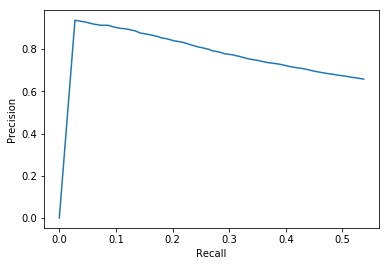

In [25]:
#attack net trained on nn shadow model on nn target
eval_attack_net(attack_net_nn, target_net, target_train_loader, target_out_loader, k)

In [ ]:
#attack net trained on nn shadow model on svm target, C=10, gamma=.1
# eval_attack_net(attack_net_nn, gen_svm, sv_target_train_loader, sv_target_out_loader, k)

In [ ]:

# do this for 10 & 100 speakers
# .2 S & 3 S
#sufficient training and over-training

#manual data: 

#Attack 1:
df.loc[len(df)] = ['MFCC',25,69.0,.9994,.9632,1,0.89,0.90] 
df.loc[len(df)] = ['MFCC',25,255.0,.9961,.9443,1,0.88,0.91] 
df.loc[len(df)] = ['STFT',25,69.0,0.9989,0.9451,1,0.89,0.92] 
df.loc[len(df)] = ['STFT',25,255.0,0.9958,0.9181,1,0.85,0.86] 

#Attack 3 w/max data: 
df.loc[len(df)] = ['STFT',25,139.0,.9985,.9073,3,.81,.90] 
df.loc[len(df)] = ['STFT',50,511.0,.9942,.9057,3,.84,.87] 
df.loc[len(df)] = ['MFCC',25,139.0,.9969,.9136,3,.82,.92] 
df.loc[len(df)] = ['MFCC',25,511.0,.9960,.9321,3,0.83,0.93]


#Attack 3 on Attack1 models:
df.loc[len(df)] = ['MFCC',25,69.0,.9994,.9632,3,0.84,0.95] 
df.loc[len(df)] = ['MFCC',25,255.0,.9961,.9443,3,0.84,0.94] 
df.loc[len(df)] = ['STFT',25,69.0,0.9989,0.9451,3,0.81,0.97] 
df.loc[len(df)] = ['STFT',25,255.0,0.9958,0.9181,3,0.81,0.90] 

df['Training epochs'] =df['Training epochs'].astype(float)
df['Attack type'] =df['Attack type'].astype(float)

#style table
import seaborn as sns

cg = sns.light_palette("green", as_cmap=True)
cm = sns.light_palette("magenta", as_cmap=True)
bl = sns.light_palette("blue", as_cmap=True)
orr = sns.light_palette("orange", as_cmap=True)
gr = sns.light_palette("gray", as_cmap=True)

# df.style.bar(subset=['Train accuracy', 'Test accuracy'], align='mid', color=['#d65f5f', '#5fba7d'])
s = df.style.\
    background_gradient(cmap=cg,subset=['Train accuracy', 'Test accuracy']).\
    background_gradient(cmap=bl,subset=['Precision', 'Recall']).\
    background_gradient(cmap=orr,subset=['Training epochs']).\
    background_gradient(cmap=gr,subset=['Attack type']).\
    background_gradient(cmap=cm,subset=['# speakers']).\
    format({"Train accuracy": "{:.2%}","Test accuracy": "{:.2%}"}).\
    hide_index().\
    set_properties(**{'font-size': "16pt",'column-size':"24pt",'width': '100px'})

s